In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from scipy import signal
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import scipy
import meta
import run_model
import seaborn as sns
import matplotlib.pyplot as plt


ERROR: Cython module was not found. This will happen if your installation did not correctly compile the cython modules


In [1]:
# define amino acids
RESIDUES = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
            'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Kyte & Doolittle {kd} index of hydrophobicity
HP = {'A': 1.8, 'R':-4.5, 'N':-3.5, 'D':-3.5, 'C': 2.5,
      'Q':-3.5, 'E':-3.5, 'G':-0.4, 'H':-3.2, 'I': 4.5,
      'L': 3.8, 'K':-3.9, 'M': 1.9, 'F': 2.8, 'P':-1.6,
      'S':-0.8, 'T':-0.7, 'W':-0.9, 'Y':-1.3, 'V': 4.2, 'U': 0.0}

In [4]:
def read_fasta(file_path):
    sequences=[]
    current_sequence=[]
    with open(file_path,"r") as file:
        for line in file:
            if line.startswith(">"):
                if current_sequence:
                    sequences.append(''.join(current_sequence))
                    current_sequence=[]
            else:
                current_sequence.append(line.strip())
        if current_sequence:
            sequences.append(''.join(current_sequence))
    return sequences

def amino_acid_analysis(df):
    seq_length = df['sequence'].str.len()
    for res in RESIDUES:
        df["fraction_"+res] = df['sequence'].str.count(res) / seq_length
    for index, row in df.iterrows():
        seq = row["sequence"]
        seq_analysis = ProteinAnalysis(seq)
        df.loc[index, "isoelectric_point"] = seq_analysis.isoelectric_point()
        #df.loc[index, "molecular_weight"] = seq_analysis.molecular_weight()
        df.loc[index, 'gravy'] = seq_analysis.gravy()

def AA_features(df):
    df["aromaticity"] = df["fraction_F"] + df["fraction_W"] + df["fraction_Y"]
    
    df["fraction_non_polar"] = df["fraction_A"] + df["fraction_C"] + df["fraction_G"] + df["fraction_I"]
    + df["fraction_L"] +df["fraction_M"] + df["fraction_F"] + df["fraction_P"] + df["fraction_W"] + df["fraction_V"]
    
    df["fraction_polar"] = df["fraction_R"] + df["fraction_N"] + df["fraction_D"] + df["fraction_Q"] 
    + df["fraction_E"] + df["fraction_H"] + df["fraction_K"] + df["fraction_S"] + df["fraction_T"] + df["fraction_Y"]
    
    df["fraction_positive_charged"] = df["fraction_R"] + df["fraction_H"] + df["fraction_K"]
    df["fraction_negative_charged"] = df["fraction_E"] + df["fraction_D"]

    df["fraction_small"] = df["fraction_G"] + df["fraction_A"] + df["fraction_S"] 
    + df["fraction_C"] + df["fraction_D"] + df["fraction_P"] + df["fraction_N"] + df["fraction_T"]
    df["fraction_medium"] = df["fraction_E"] + df["fraction_V"] + df["fraction_Q"] + df["fraction_H"]
    df["fraction_large"] = df["fraction_M"] + df["fraction_I"] + df["fraction_L"] + df["fraction_K"] + df["fraction_R"] 
    + df["fraction_F"] + df["fraction_Y"] + df["fraction_W"]


def add_metapredict_scores(df):
    df['metapredict'] = [meta.predict_disorder(seq) for seq in df['sequence']]
    
    #for index,sequence in enumerate(df["sequence"]):
        #df.at[index,"metapredict"] = meta.predict_disorder(sequence)
    
    #df['idr_total'] = df['metapredict'].apply(lambda x: sum(i > 0.5 for i in x))
    df['metapredict_average'] = df['metapredict'].apply(lambda x: sum(i for i in x)/ len(x))
    df['idr_50'] = df['metapredict'].apply(lambda x: sum(i > 0.5 for i in x) / len(x))
    df['idr_60'] = df['metapredict'].apply(lambda x: sum(i > 0.6 for i in x) / len(x))
    df['idr_70'] = df['metapredict'].apply(lambda x: sum(i > 0.7 for i in x) / len(x))
    df['idr_80'] = df['metapredict'].apply(lambda x: sum(i > 0.8 for i in x) / len(x))
    df['idr_90'] = df['metapredict'].apply(lambda x: sum(i > 0.9 for i in x) / len(x))
    df.drop("metapredict", axis=1,inplace=True)

def add_predict_pLDDT_scores(df):
    df['pLDDT'] = [meta.predict_pLDDT(seq, normalized=True) for seq in df['sequence']]
    #for index,sequence in enumerate(df["sequence"]):
        #df.at[index,"pLDDT"] = meta.predict_pLDDT(sequence, normalized=True)
    
    df['pLDDT_average'] = df['pLDDT'].apply(lambda x: sum(i for i in x)/ len(x))
    df['pLDDT_very_low'] = df['pLDDT'].apply(lambda x: sum(i < 0.5 for i in x) / len(x))
    df['pLDDT_low'] = df['pLDDT'].apply(lambda x: sum(0.5 < i < 0.7 for i in x) / len(x))
    df['pLDDT_high'] = df['pLDDT'].apply(lambda x: sum(0.7 < i < 0.9 for i in x) / len(x))
    df['pLDDT_very_high'] = df['pLDDT'].apply(lambda x: sum(i > 0.9 for i in x) / len(x))
    df.drop("pLDDT", axis=1,inplace=True)

def add_s4pred_ss1(df):
    for index, sequence in enumerate(df['sequence']):
        ss, ss_conf = run_model.predict_sequence(sequence)
        ind2char={0:"C", 1:"H", 2:"E"}
        sse=""
        for i in range(len(ss)):
            sse += ind2char[ss[i]]
        df.at[index,"secondary_structure_prediction"] = sse
    df["fraction_coils"] = df['secondary_structure_prediction'].apply(lambda x: x.count("C")/len(x) if x else 0)
    df["fraction_helix"] = df['secondary_structure_prediction'].apply(lambda x: x.count("H")/len(x) if x else 0)
    df["fraction_strand"] = df['secondary_structure_prediction'].apply(lambda x: x.count("E")/len(x) if x else 0)
    df.drop('secondary_structure_prediction', axis=1, inplace=True)
def add_s4pred_ss(df):
    ss_list = []
    for sequence in df['sequence']:
        ss, ss_conf = run_model.predict_sequence(sequence)
        ind2char = {0: "C", 1: "H", 2: "E"}
        sse = "".join([ind2char[i] for i in ss])
        ss_list.append(sse)
    
    df['secondary_structure_prediction'] = ss_list
    df['fraction_coils'] = df['secondary_structure_prediction'].str.count('C') / df['secondary_structure_prediction'].str.len()
    df['fraction_helix'] = df['secondary_structure_prediction'].str.count('H') / df['secondary_structure_prediction'].str.len()
    df['fraction_strand'] = df['secondary_structure_prediction'].str.count('E') / df['secondary_structure_prediction'].str.len()
    df.drop('secondary_structure_prediction', axis=1, inplace=True)


def add_HydrophobicFeatures(df):
    df["HydrophobicIndex"] = df["sequence"].apply(lambda seq: [HP.get(aa, 0) for aa in seq])
    smooth = df["HydrophobicIndex"].apply(lambda x: x if len(x) < 11 else convolve_signal(x, 11))
    df["hpi_<-1.5_frac"] = smooth.apply(lambda x: sum(i < -1.5 for i in x) / len(x))
    df["hpi_<-2.0_frac"] = smooth.apply(lambda x: sum(i < -2.0 for i in x) / len(x))
    df["hpi_<-2.5_frac"] = smooth.apply(lambda x: sum(i < -2.5 for i in x) / len(x))
    df.drop("HydrophobicIndex", axis=1, inplace=True)
    
def convolve_signal(sig, window=25):
    win = scipy.signal.windows.hann(window)
    sig = signal.convolve(sig, win, mode='same') / sum(win)
    return sig

def add_LCRfeatures1(df):
    def overlapping_window(sequence, L):
        return [sequence[i:i+L] for i in range(len(sequence) - L + 1)]
    def sequence_to_repvex(sequence):
        repvec = [sequence.count(residue) for residue in "ACDEFGHIKLMNPQRSTVWY"]
        return sorted(repvec, reverse=True)
    def sequence_entropy(sequence):
        repvec = sequence_to_repvex(sequence)
        L = len(sequence)

        entropy = sum([-(n/L)*np.log2(n/L) for n in repvec if n > 0])
        return entropy
    max_entropy_possible = np.log2(20)
    window_length = 12
    df['entropies'] = [[sequence_entropy(window) for window in overlapping_window(sequence, window_length)] for sequence in df["sequence"] if len(sequence) > window_length]
    df["entropy_mean"] = df["entropies"].apply(lambda x: np.mean(x)/max_entropy_possible)
    df["entropy_max"] = df["entropies"].apply(lambda x: np.max(x)/ max_entropy_possible)
    df["entropy_min"] = df["entropies"].apply(lambda x: np.min(x)/ max_entropy_possible)
    df["total_windows"] = df["sequence"].apply(lambda seq: len(seq) - window_length + 1)
    df["low_entropy_regions"] = df["entropies"].apply(lambda x: sum(i < 2.2 for i in x))
    df["low_entropy_fraction"] = df["low_entropy_regions"] / df["total_windows"]

    df.drop(["entropies", "low_entropy_regions", "total_windows"], axis=1, inplace=True)

def add_LCRfeatures(df):
    def overlapping_window(sequence, L):
        return [sequence[i:i+L] for i in range(len(sequence) - L + 1)]

    def sequence_to_repvex(sequence):
        repvec = [sequence.count(residue) for residue in "ACDEFGHIKLMNPQRSTVWY"]
        return sorted(repvec, reverse=True)

    def sequence_entropy(sequence):
        repvec = sequence_to_repvex(sequence)
        L = len(sequence)
        entropy = sum([-(n/L)*np.log2(n/L) for n in repvec if n > 0])
        return entropy

    max_entropy_possible = np.log2(20)
    window_length = 12

    def process_sequence(sequence):
        if len(sequence) < window_length:
            return {
                "entropy_mean": None,
                "entropy_max": None,
                "entropy_min": None,
                "low_entropy_fraction": None
            }
        entropies = [sequence_entropy(window) for window in overlapping_window(sequence, window_length)]
        total_windows = len(sequence) - window_length + 1
        low_entropy_regions = sum(i < 2.2 for i in entropies)
        return {
            "entropy_mean": np.mean(entropies) / max_entropy_possible,
            "entropy_max": np.max(entropies) / max_entropy_possible,
            "entropy_min": np.min(entropies) / max_entropy_possible,
            "low_entropy_fraction": low_entropy_regions / total_windows
        }

    results = df['sequence'].apply(process_sequence)
    results_df = pd.DataFrame(results.tolist())
    for column in results_df.columns:
        df[column] = results_df[column]

def process_df(df):
    df = df.copy()
    amino_acid_analysis(df)
    AA_features(df)
    add_HydrophobicFeatures(df)
    add_LCRfeatures(df)
    add_metapredict_scores(df)
    add_predict_pLDDT_scores(df)
    add_s4pred_ss(df)
    return df


In [3]:
seq_dd = read_fasta("output_dd_cdhit.fasta")
seq_do = read_fasta("output_do_cdhit.fasta")
print(len(seq_dd), len(seq_do))
common_sequence = set(seq_dd) & set(seq_do)
chars = ["X","U","B", "O", "Z", "J"]
seq_dd = [item for item in seq_dd if item not in common_sequence and all(char not in item for char in chars)]
seq_do = [item for item in seq_do if item not in common_sequence and all(char not in item for char in chars)]
print(len(seq_dd), len(seq_do))

NameError: name 'read_fasta' is not defined

In [17]:
df_do = pd.DataFrame(seq_do, columns=["sequence"])
df_dd = pd.DataFrame(seq_dd, columns=["sequence"])

In [21]:
df_do.to_csv("df_do.csv")
df_dd.to_csv("df_dd.csv")

In [ ]:
df_do_features = process_df(df_do)
df_do_features.to_csv("df_do_features.csv")

In [ ]:
df_dd_features = process_df(df_dd)
df_dd_features.to_csv("df_dd_features.csv")


In [ ]:
df_do_features = pd.read_csv("df_do_features.csv")

In [30]:
df_do_features.head()

Unnamed: 0                                    sequence  fraction_A  \
0           0                              LLPTPPLSPSRRSG    0.000000   
1           1                                 RSSRTRRETQV    0.000000   
2           2  SHMAPEDPNEEAVSQIFPDSVMLAVQEGIDLLTFPPAPGSPE    0.095238   
3           3                               RTYETFKSIMKKS    0.000000   
4           4                       ARTKQTARKSTGGKAPRKQLC    0.142857   

   fraction_C  fraction_D  fraction_E  fraction_F  fraction_G  fraction_H  \
0    0.000000    0.000000    0.000000    0.000000    0.071429     0.00000   
1    0.000000    0.000000    0.090909    0.000000    0.000000     0.00000   
2    0.000000    0.071429    0.119048    0.047619    0.047619     0.02381   
3    0.000000    0.000000    0.076923    0.076923    0.000000     0.00000   
4    0.047619    0.000000    0.000000    0.000000    0.095238     0.00000   

   fraction_I  ...    idr_80    idr_90  pLDDT_average  pLDDT_very_low  \
0    0.000000  ...  0.928571  0.285714       0.611435        0.142857   
1    0.000000  ...  0.818182  0.454545       0.599275        0.090909   
2    0.047619  ...  0.166667  0.023810       0.702507        0.023810   
3    0.076923  ...  0.000000  0.000000       0.822144        0.000000   
4    0.000000  ...  0.761905  0.571429       0.579037        0.142857   

   pLDDT_low  pLDDT_high  pLDDT_very_high  fraction_coils  fraction_helix  \
0   0.642857    0.214286         0.000000        1.000000        0.000000   
1   0.909091    0.000000         0.000000        1.000000        0.000000   
2   0.428571    0.547619         0.000000        0.547619        0.452381   
3   0.230769    0.538462         0.230769        0.384615        0.615385   
4   0.857143    0.000000         0.000000        1.000000        0.000000   

   fraction_strand  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  

[5 rows x 50 columns]

In [ ]:
#df_do_features = df_do_features.drop(columns=['Unnamed: 0', df_do_features.columns[0]])

In [83]:
df_dd_features = df_dd_features.round(4).dropna()
df_do_features = df_do_features.round(4).dropna()

In [84]:
df_do_features.to_csv("df_do_features_clean.csv", index=False)
df_dd_features.to_csv("df_dd_features_clean.csv", index=False)

In [ ]:
df_do_features["labels"] = "Disorder-Order"
df_dd_features["labels"] = "Disorder-Disorder"

sequence  fraction_A  \
0    MASTVSNTSKLEKPVSLIWGCELNEQDKTFEFKVEDDEEKCEHQLA...      0.0900   
1    MDKVLNREESLQLMDLLGLERSAWGNIPLMRKAYLKKCKEFHPDKG...      0.0537   
2    MPEETQTQDQPMEEEEVETFAFQAEIAQLMSLIINTFYSNKEIFLR...      0.0464   
3    MPQLNGGGGDDLGANDELISFKDEGEQEEKSSENSSAERDLADVKS...      0.0679   
4    MLRALVQPATPAYQPLPSHLSAETESTCKGTVVHEAQLNHFYISPG...      0.0801   
..                                                 ...         ...   
314  MSDKPKRPLSAYMLWLNSARESIKRENPGIKVTEVAKRGGELWRAM...      0.1429   
315  MDPSSGGGGGGGGGGSSSSSDSAPDCWDQTDMEAPGPGPCGGGGSG...      0.0645   
316  MSGWSGPLARRGPGPLALLFLFLLGPSSVLAISFHLPVNSRKCLRE...      0.0594   
317  MEQAPEDQGPQREPYNDWTLELLEELKNEAVRHFPRIWLHSLGQHI...      0.0417   
318  MDYYRKYAAIFLVTLSVFLHVLHSAPDVQDCPECTLQENPFFSQPG...      0.0603   

     fraction_C  fraction_D  fraction_E  fraction_F  fraction_G  fraction_H  \
0        0.0150      0.0550      0.1750      0.0200      0.0700      0.0100   
1        0.0212      0.0678      0.0805      0.0508      0.0508      0.0268   
2        0.0096      0.0738      0.1325      0.0342      0.0437      0.0164   
3        0.0145      0.0420      0.0565      0.0178      0.0565      0.0452   
4        0.0212      0.0405      0.0645      0.0580      0.0608      0.0193   
..          ...         ...         ...         ...         ...         ...   
314      0.0000      0.0893      0.1161      0.0089      0.0714      0.0000   
315      0.0220      0.0503      0.0991      0.0346      0.1101      0.0236   
316      0.0137      0.0502      0.0913      0.0639      0.0731      0.0228   
317      0.0104      0.0312      0.0938      0.0312      0.0729      0.0521   
318      0.0862      0.0259      0.0345      0.0517      0.0345      0.0431   

     fraction_I  fraction_K  ...  pLDDT_high  pLDDT_very_high  fraction_coils  \
0        0.0350      0.1250  ...      0.1500           0.4100          0.7000   
1        0.0424      0.0890  ...      0.5141           0.2571          0.4576   
2        0.0683      0.1093  ...      0.2514           0.6038          0.4549   
3        0.0307      0.0646  ...      0.0323           0.0856          0.8805   
4        0.0668      0.0474  ...      0.5325           0.0336          0.5090   
..          ...         ...  ...         ...              ...             ...   
314      0.0179      0.1786  ...      0.0893           0.5268          0.5000   
315      0.0535      0.0723  ...      0.1038           0.5629          0.7060   
316      0.0548      0.0776  ...      0.1826           0.6621          0.4429   
317      0.0938      0.0208  ...      0.6042           0.0000          0.4688   
318      0.0172      0.0603  ...      0.5431           0.3879          0.8017   

     fraction_helix  fraction_strand  entropy_mean  entropy_max  entropy_min  \
0            0.0000           0.3000        0.6292       0.8295       0.1890   
1            0.5367           0.0056        0.6804       0.8295       0.4147   
2            0.4057           0.1393        0.6656       0.8295       0.2750   
3            0.1195           0.0000        0.6389       0.8295       0.4293   
4            0.4910           0.0000        0.6657       0.8295       0.3282   
..              ...              ...           ...          ...          ...   
314          0.5000           0.0000        0.6085       0.7524       0.3432   
315          0.1116           0.1824        0.6578       0.8295       0.1504   
316          0.3379           0.2192        0.6802       0.7909       0.4533   
317          0.5312           0.0000        0.6629       0.7909       0.5210   
318          0.0000           0.1983        0.6950       0.7909       0.5450   

     low_entropy_fraction             labels  
0                  0.1746  Disorder-Disorder  
1                  0.0086  Disorder-Disorder  
2                  0.0596  Disorder-Disorder  
3                  0.0691  Disorder-Disorder  
4                  0.0264  Disorder-Disorder  
..                    ...               

In [93]:
combined_df = pd.concat([df_do_features, df_dd_features]).sample(frac=1).reset_index(drop=True)
combined_df.describe()

fraction_A  fraction_C  fraction_D  fraction_E  fraction_F  fraction_G  \
count  986.000000  986.000000  986.000000  986.000000  986.000000  986.000000   
mean     0.073098    0.011012    0.060018    0.080887    0.029921    0.060579   
std      0.049942    0.019287    0.048487    0.055488    0.029640    0.047414   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.043500    0.000000    0.030500    0.047600    0.000000    0.034500   
50%      0.067250    0.000000    0.053800    0.071400    0.026200    0.056750   
75%      0.102075    0.016400    0.076900    0.106325    0.043875    0.078325   
max      0.333300    0.200000    0.333300    0.375000    0.250000    0.500000   

       fraction_H  fraction_I  fraction_K  fraction_L  ...   pLDDT_low  \
count  986.000000  986.000000  986.000000  986.000000  ...  986.000000   
mean     0.021105    0.045555    0.070204    0.091450  ...    0.313991   
std      0.024301    0.034107    0.054838    0.053359  ...    0.293214   
min      0.000000    0.000000    0.000000    0.000000  ...    0.002800   
25%      0.000000    0.024400    0.034500    0.060600  ...    0.078125   
50%      0.017200    0.043500    0.063150    0.085800  ...    0.192100   
75%      0.029400    0.062500    0.092575    0.117600  ...    0.500000   
max      0.153800    0.250000    0.384600    0.416700  ...    1.000000   

       pLDDT_high  pLDDT_very_high  fraction_coils  fraction_helix  \
count  986.000000       986.000000      986.000000      986.000000   
mean     0.354626         0.227486        0.615185        0.321750   
std      0.257921         0.285576        0.272640        0.283452   
min      0.000000         0.000000        0.014100        0.000000   
25%      0.133300         0.000000        0.419975        0.033925   
50%      0.320200         0.072350        0.580900        0.284500   
75%      0.566475         0.443975        0.864875        0.536075   
max      0.973200         0.978200        1.000000        0.985900   

       fraction_strand  entropy_mean  entropy_max  entropy_min  \
count       986.000000    986.000000   986.000000   986.000000   
mean          0.063061      0.664008     0.762433     0.517548   
std           0.113420      0.045939     0.066413     0.126020   
min           0.000000      0.322600     0.358900     0.000000   
25%           0.000000      0.644825     0.752400     0.453300   
50%           0.000000      0.670650     0.790900     0.545000   
75%           0.081100      0.691200     0.790900     0.605600   
max           0.563000      0.810200     0.829500     0.790900   

       low_entropy_fraction  
count            986.000000  
mean               0.034461  
std                0.104570  
min                0.000000  
25%                0.000000  
50%                0.000000  
75%                0.025350  
max                1.000000  

[8 rows x 52 columns]

In [94]:
combined_df.to_csv("combined_df.csv", index=False)

In [28]:
combined_df = pd.read_csv("combined_df.csv")

In [7]:
combined_df = pd.read_csv("combined_df.csv")
#combined_df.drop("molecular_weight", axis=1, inplace=True)
#combined_df.to_csv("combined_df.csv")

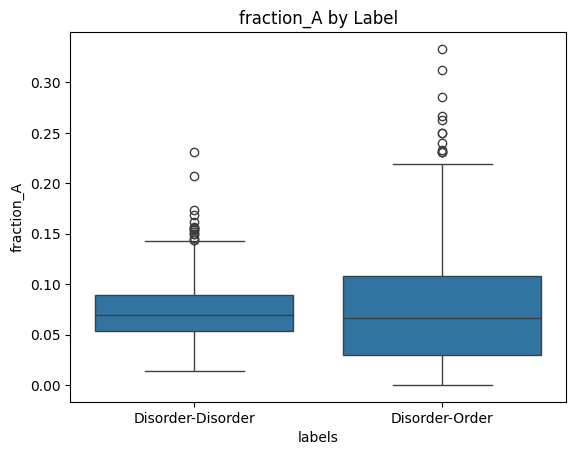

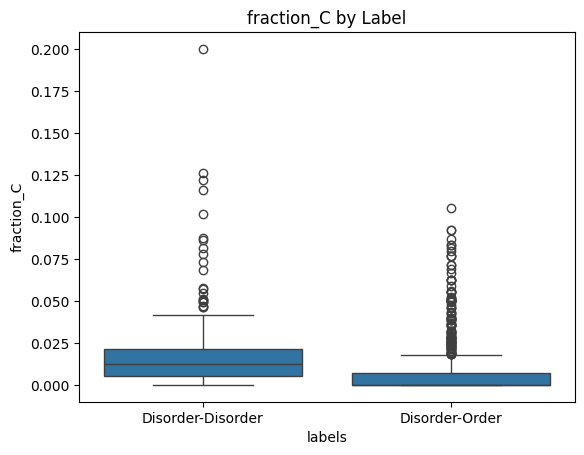

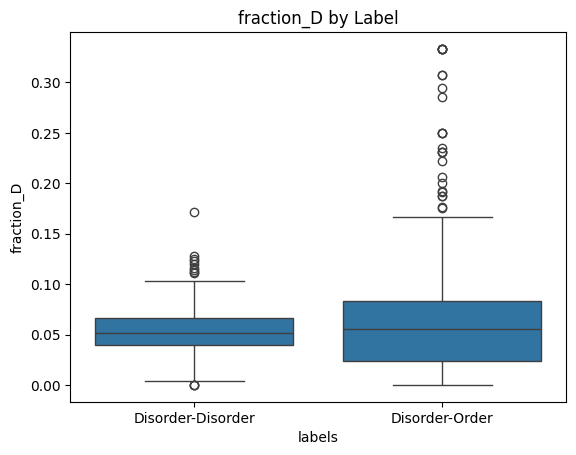

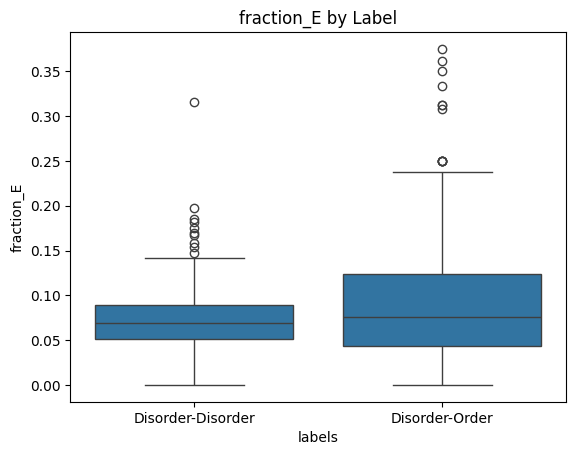

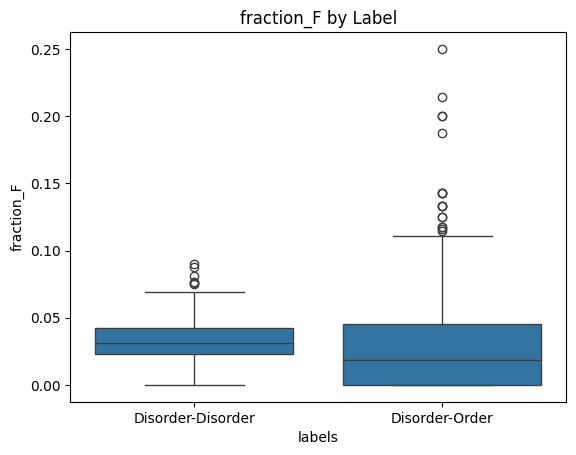

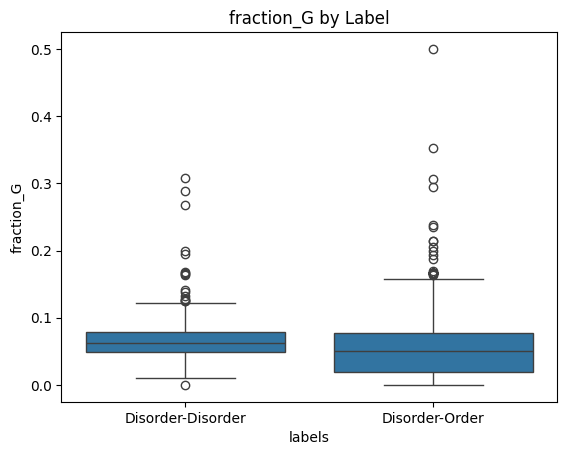

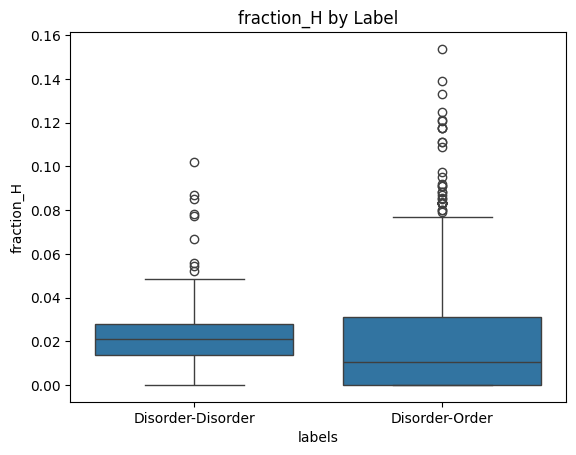

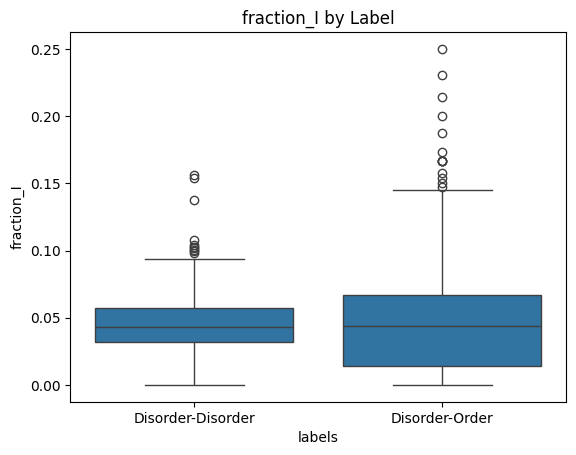

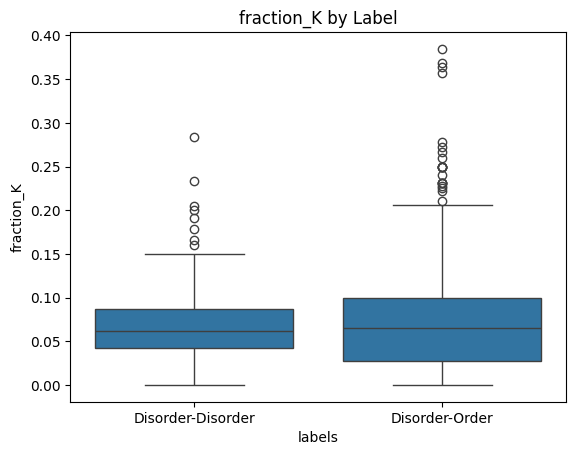

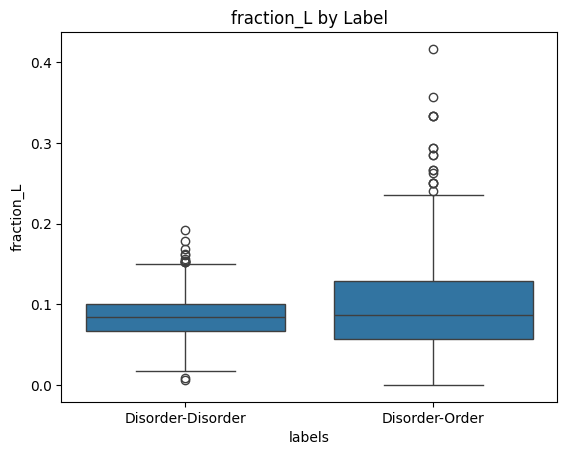

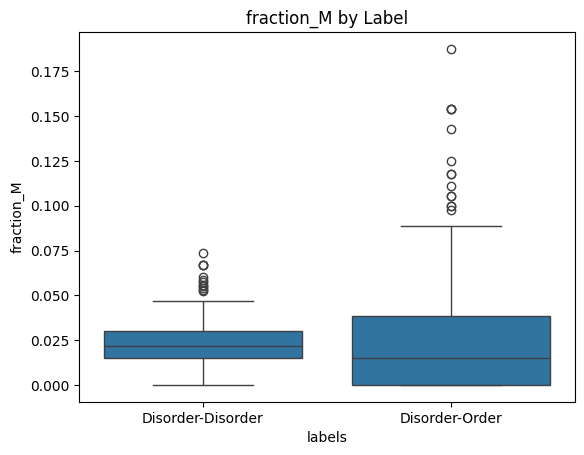

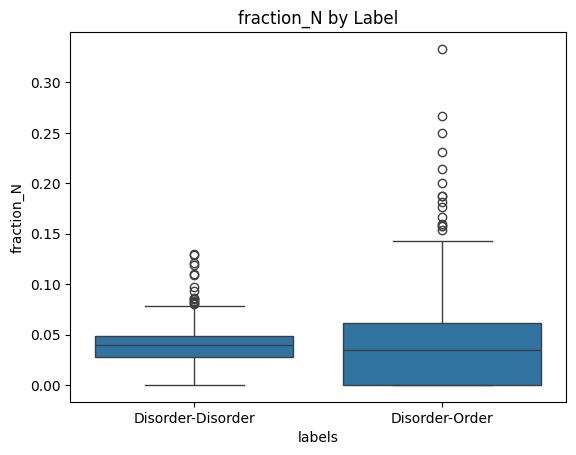

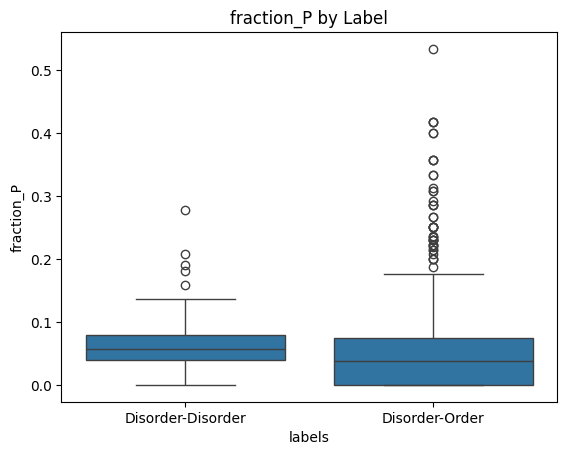

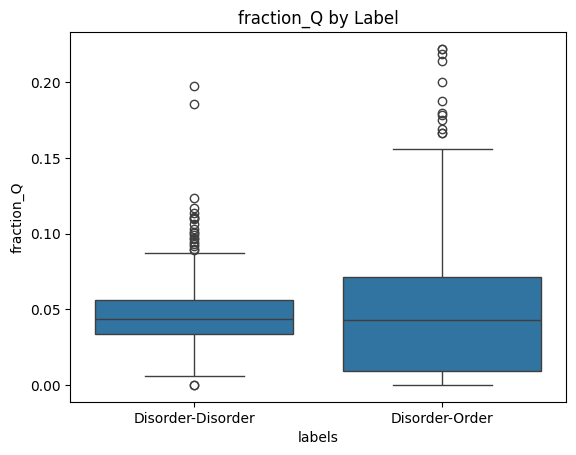

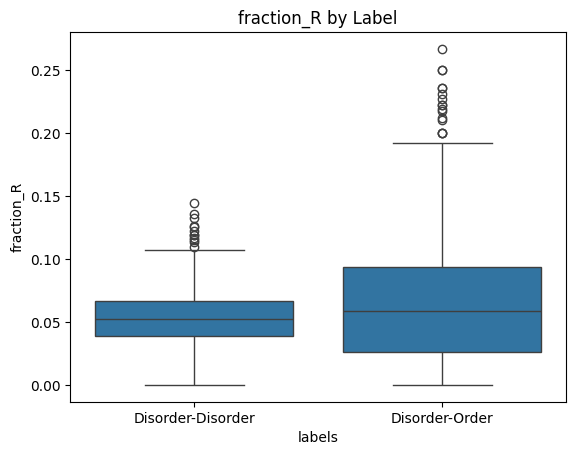

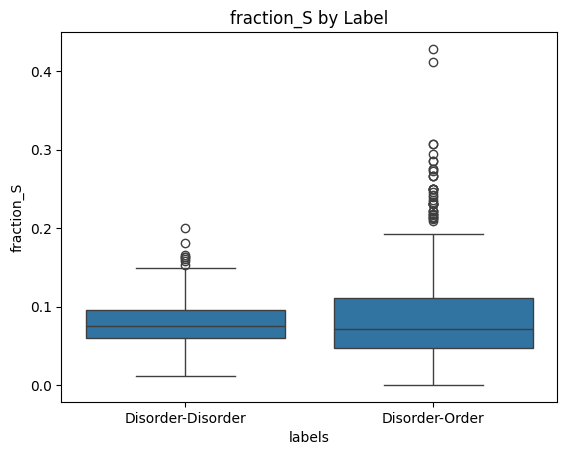

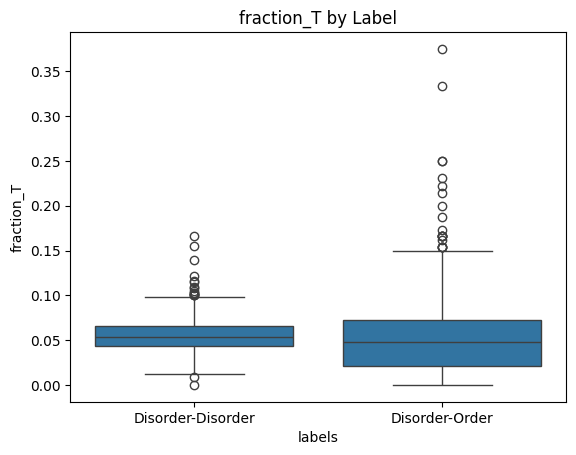

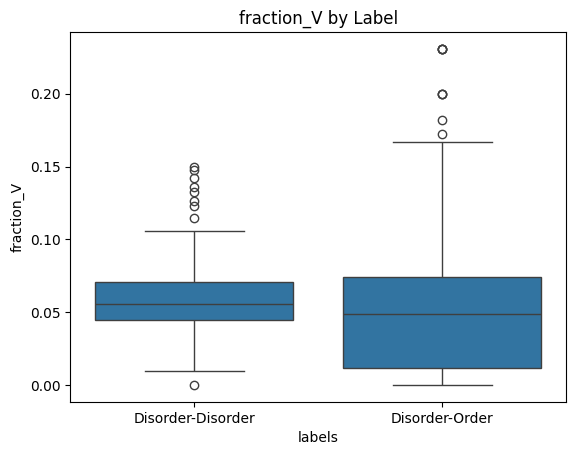

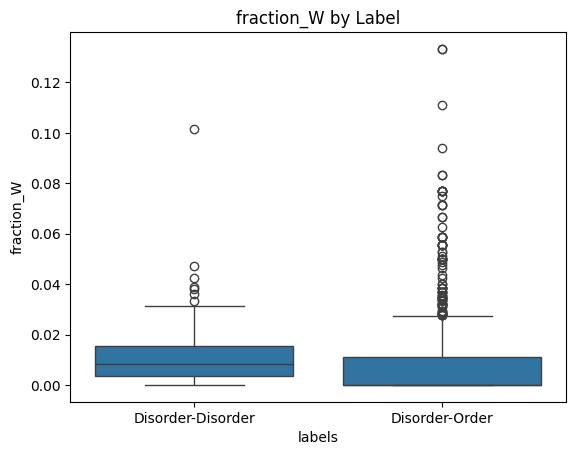

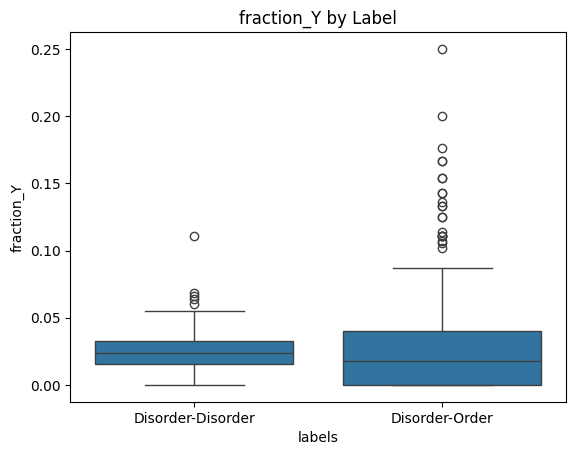

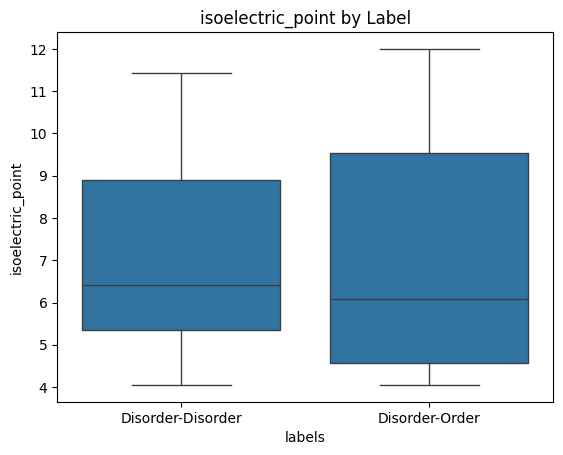

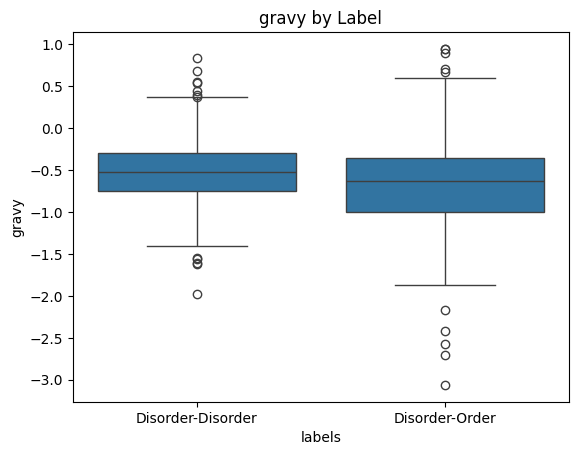

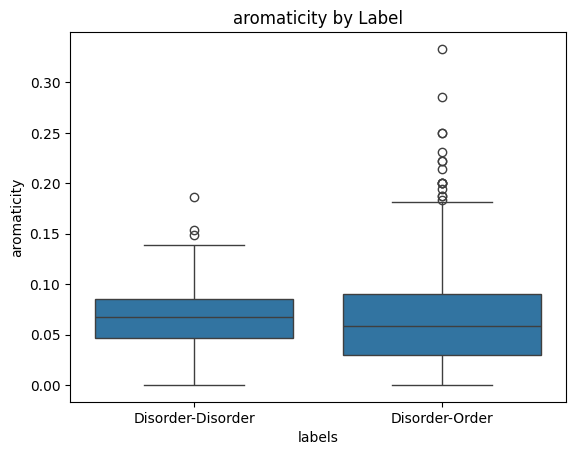

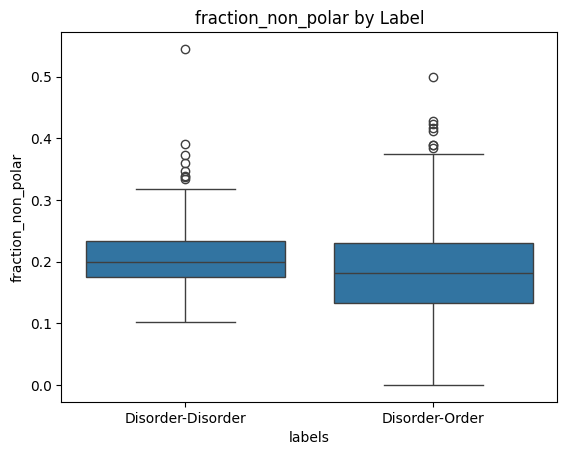

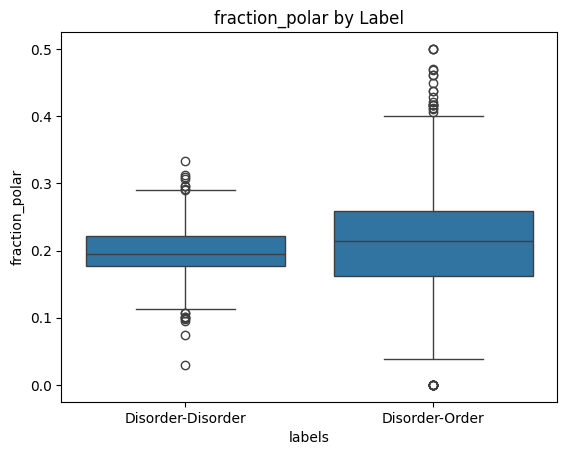

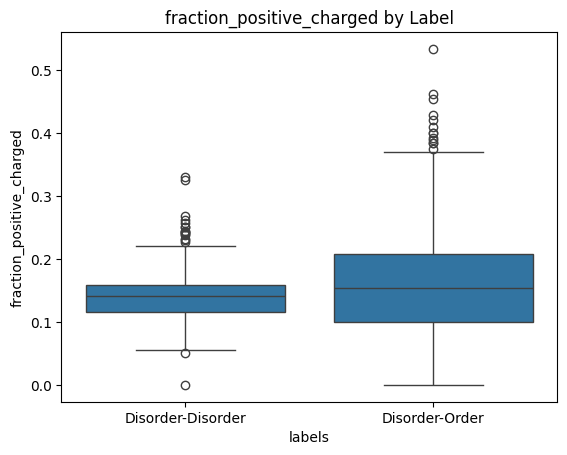

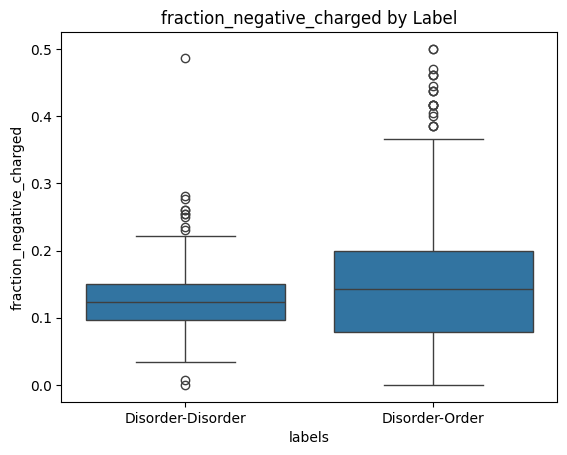

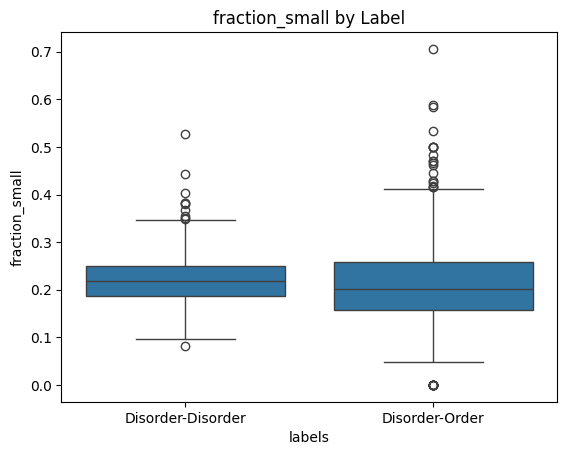

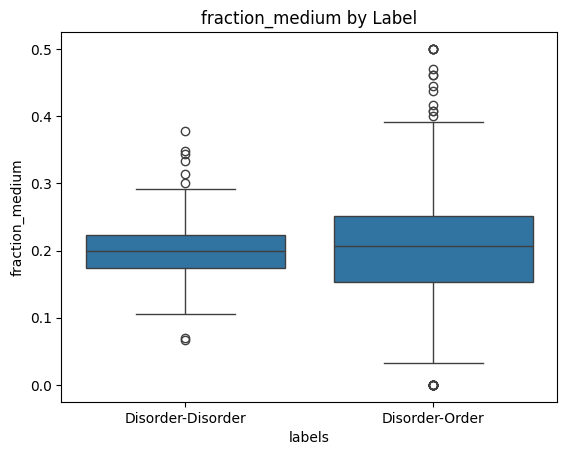

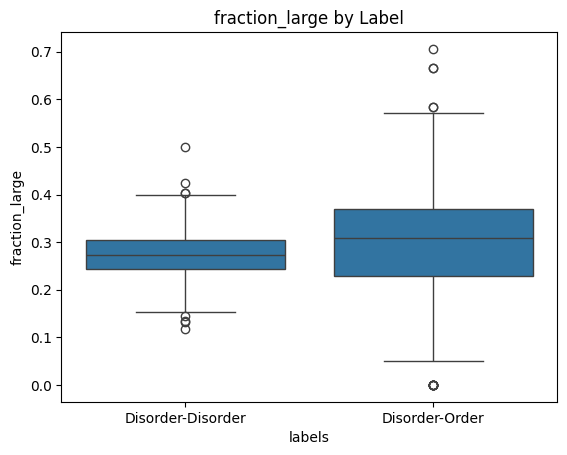

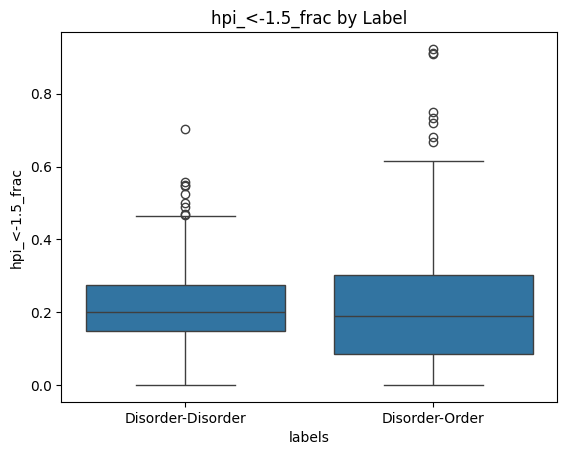

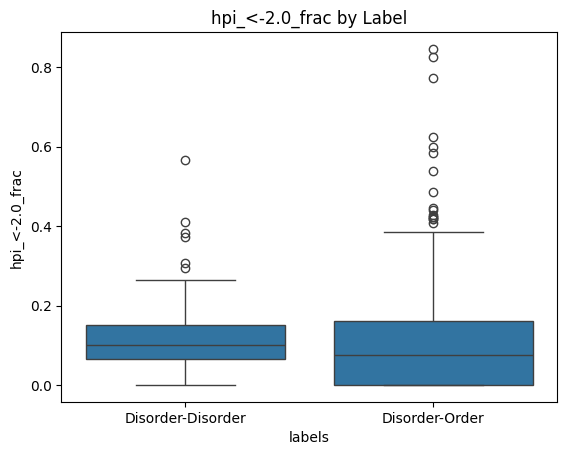

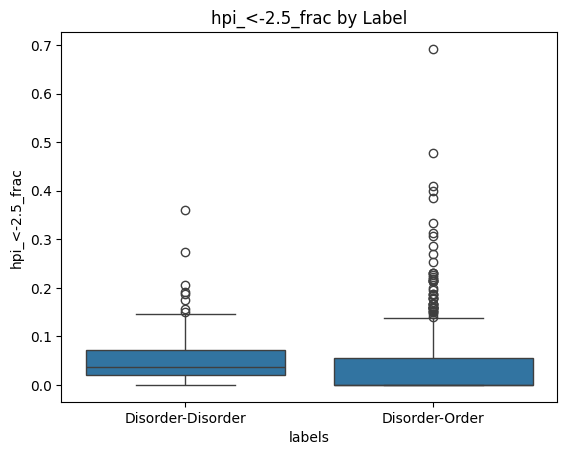

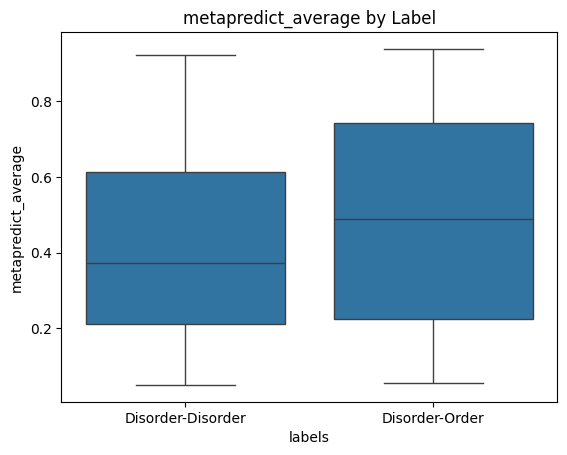

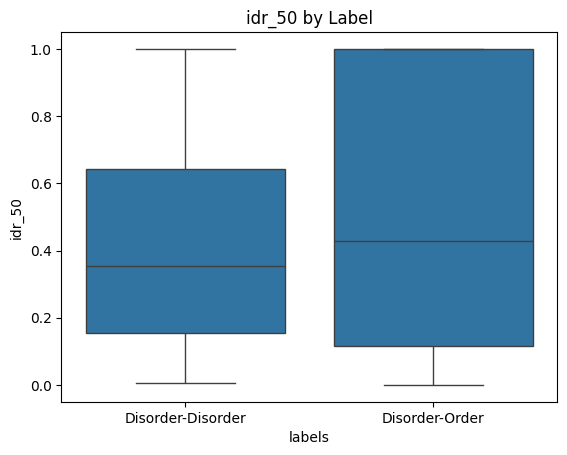

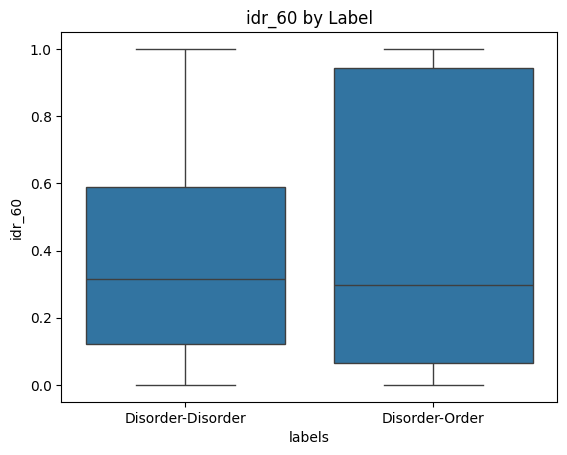

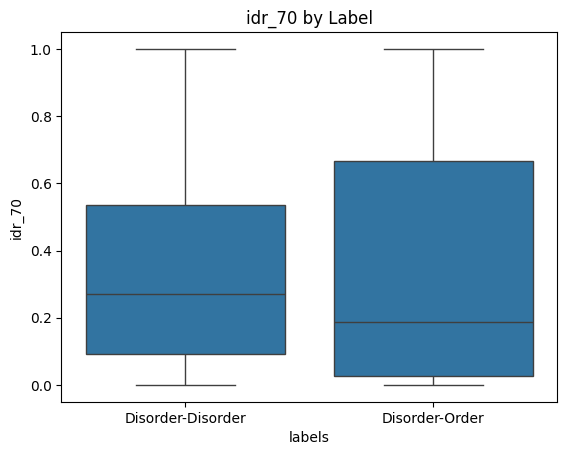

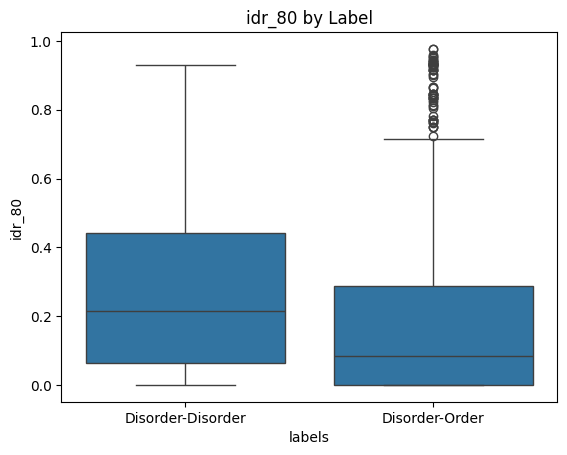

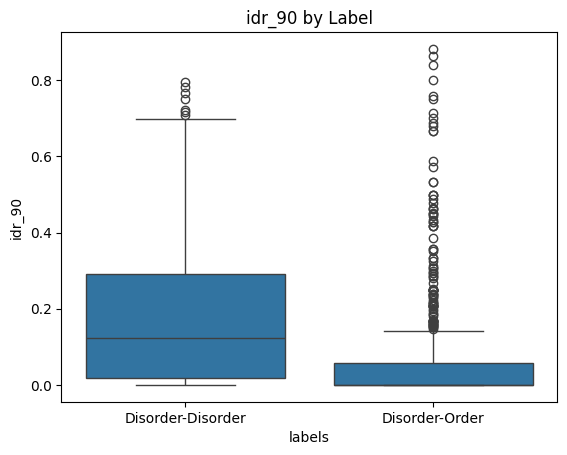

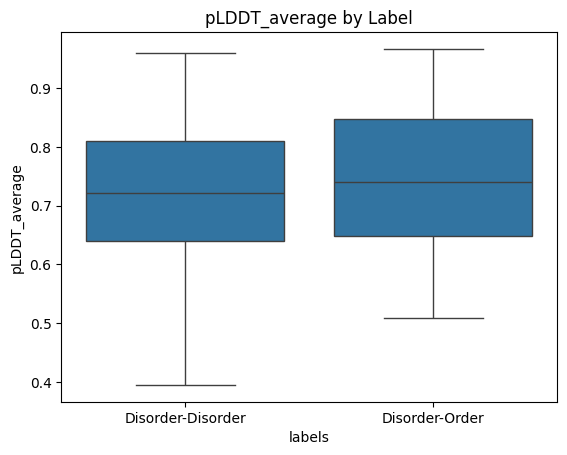

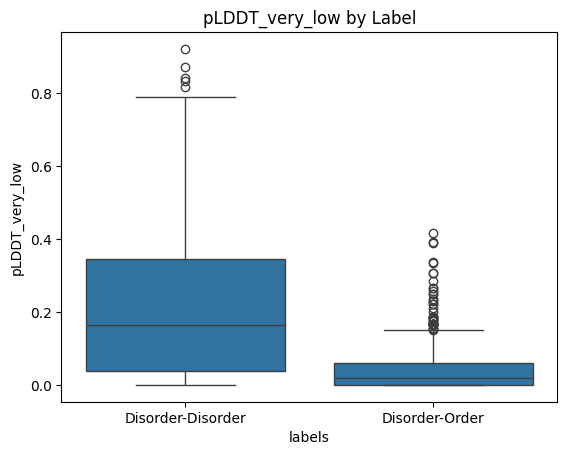

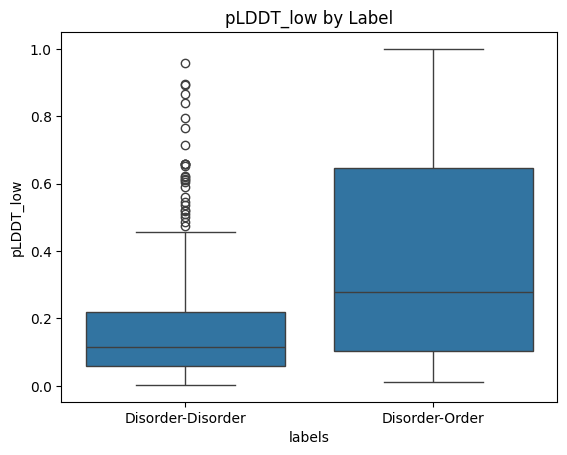

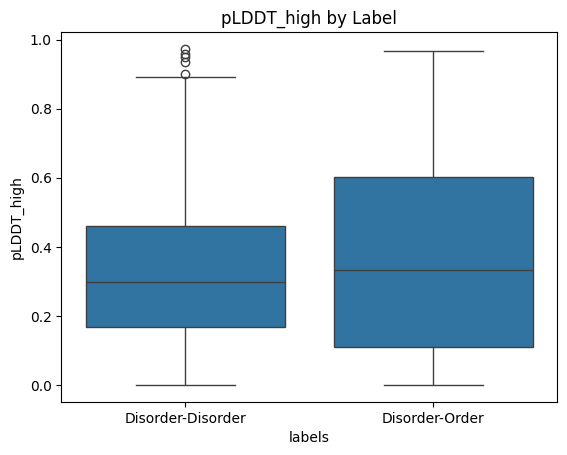

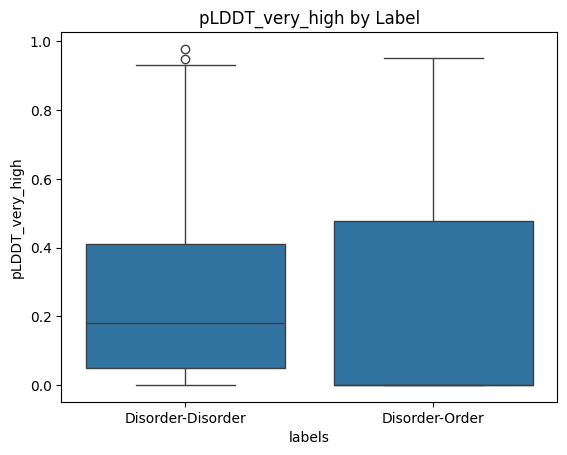

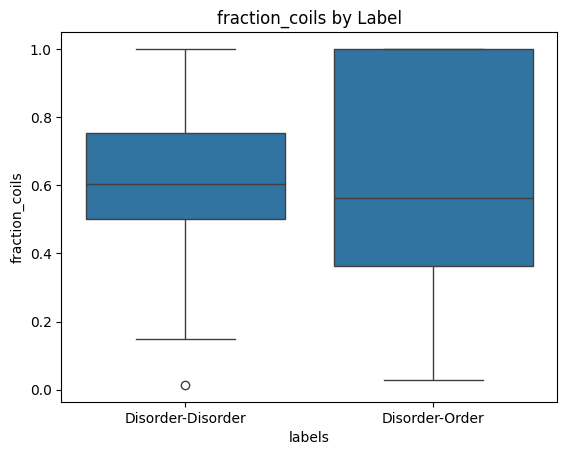

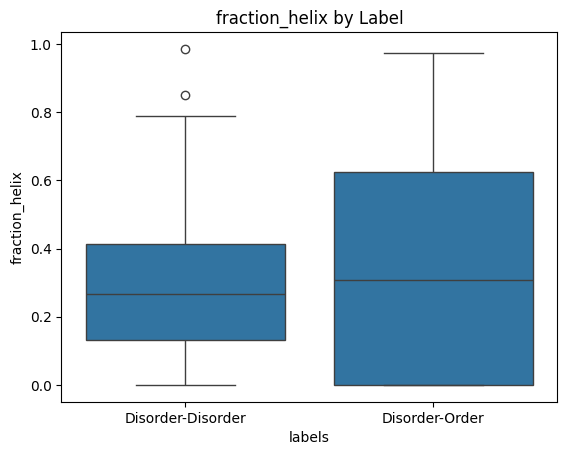

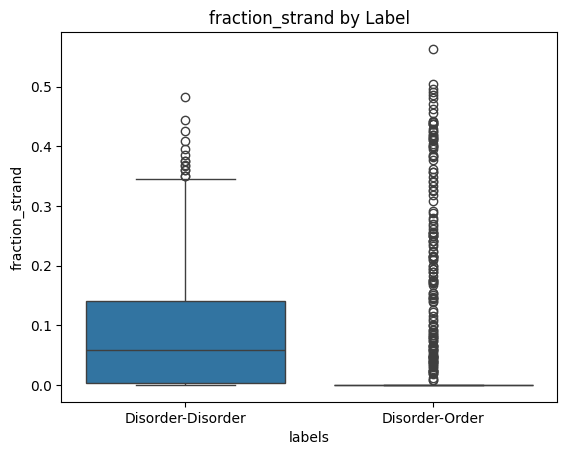

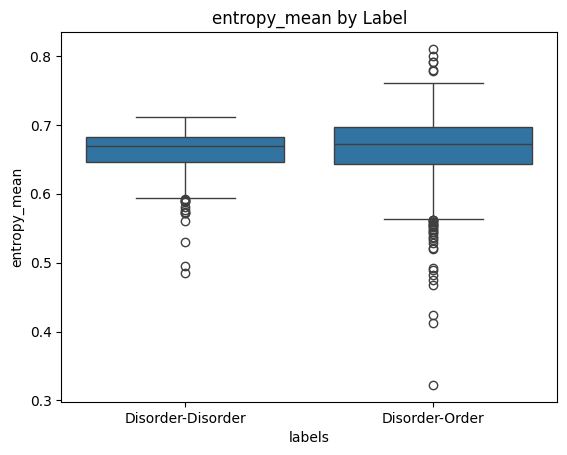

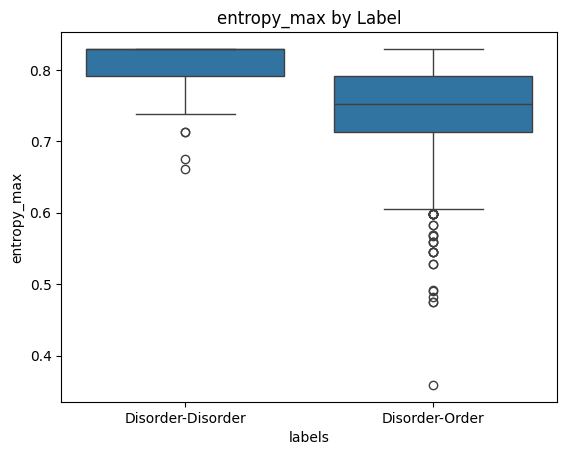

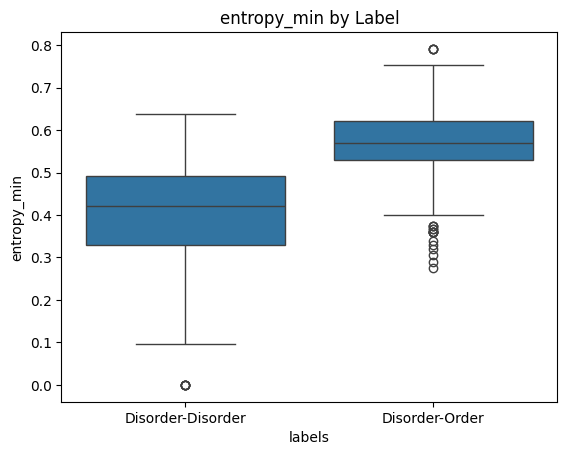

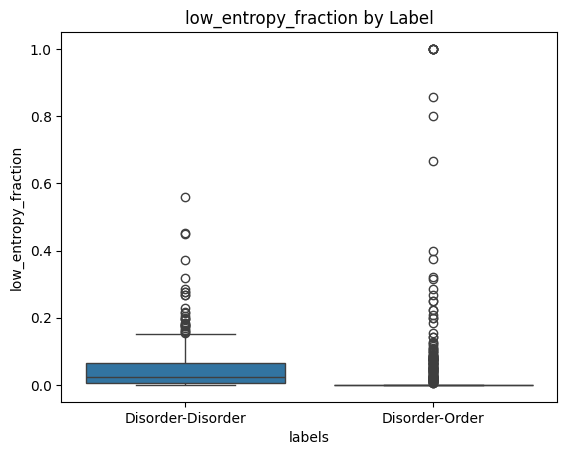

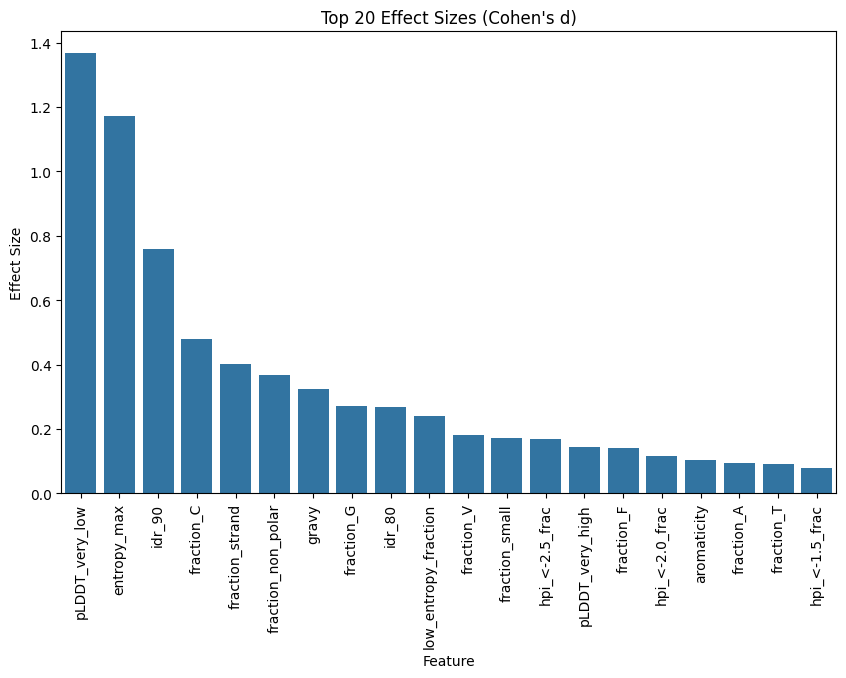

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def calculate_cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = (((nx - 1) * x.std() ** 2 + (ny - 1) * y.std() ** 2) / dof) ** 0.5
    return (x.mean() - y.mean()) / pooled_std

def sanitize_filename(filename):
    return re.sub(r'[<>:"/\\|?*]', '', filename)


numeric_features = combined_df.select_dtypes(include=['number']).columns.tolist()

effect_sizes = {}
for feature in numeric_features:
    class_a = combined_df[combined_df['labels'] == 'Disorder-Disorder'][feature]
    class_b = combined_df[combined_df['labels'] == 'Disorder-Order'][feature]
    effect_size = calculate_cohens_d(class_a, class_b)
    effect_sizes[feature] = effect_size

for feature in numeric_features:
    plt.figure()
    sns.boxplot(x='labels', y=feature, data=combined_df)
    plt.title(f'{feature} by Label')
    sanitized_feature = sanitize_filename(feature)
    plt.savefig(f"{sanitized_feature}_boxplot.png")
    plt.show()

effect_size_df = pd.DataFrame(list(effect_sizes.items()), columns=['Feature', 'Effect Size'])

effect_size_df = effect_size_df.nlargest(20, 'Effect Size')

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Effect Size', data=effect_size_df)
plt.title('Top 20 Effect Sizes (Cohen\'s d)')
plt.xticks(rotation=90)
plt.savefig("Top_20_Feature_effect_size.png")
plt.show()


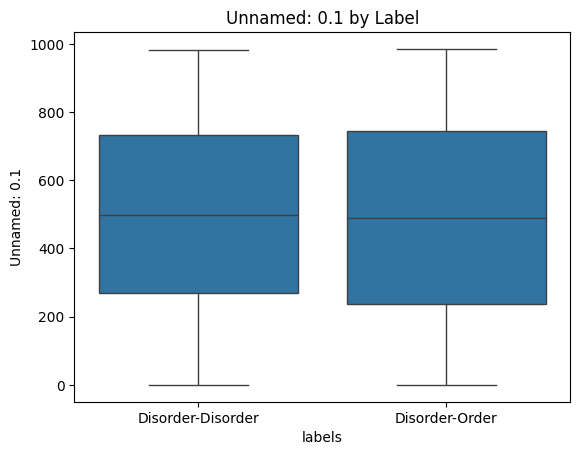

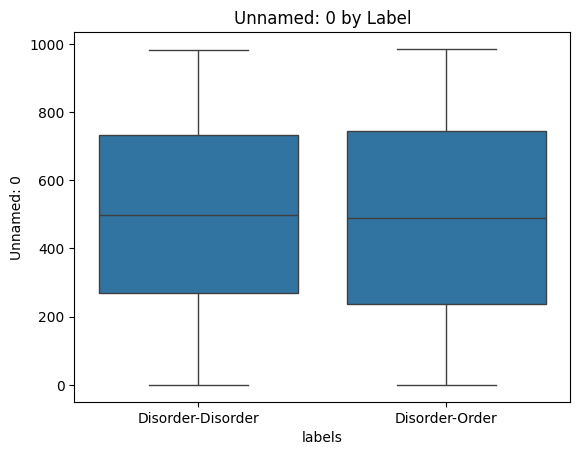

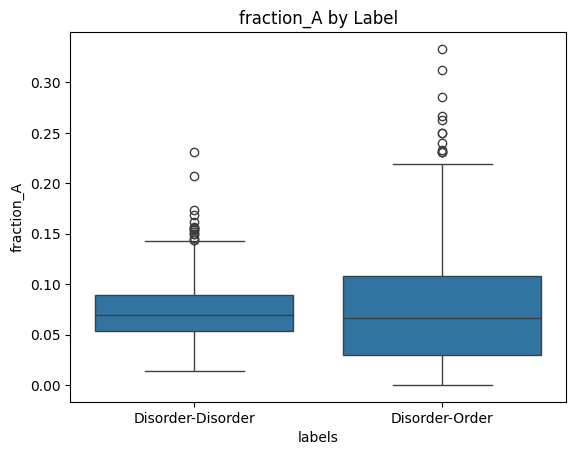

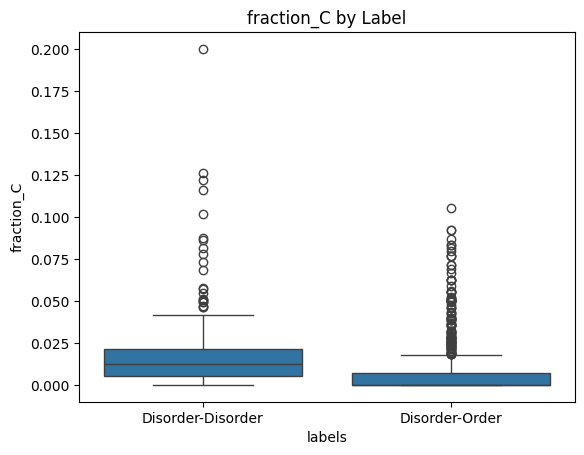

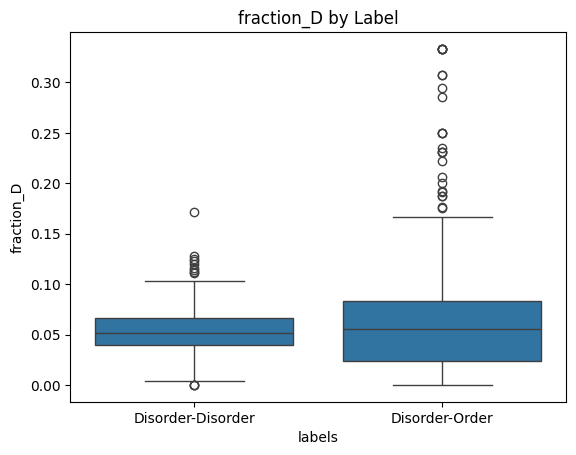

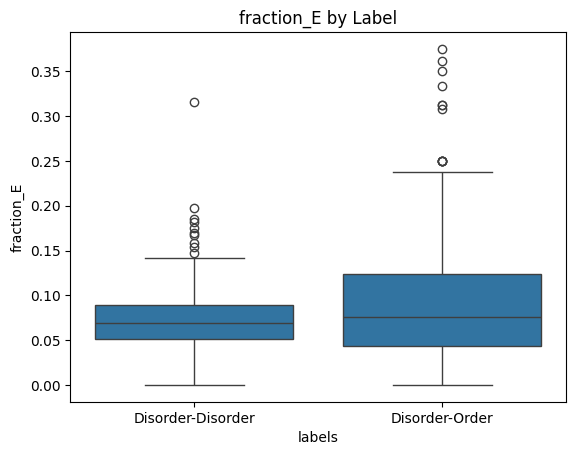

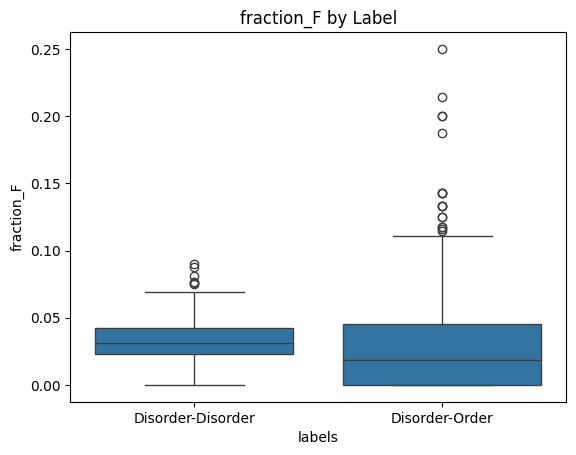

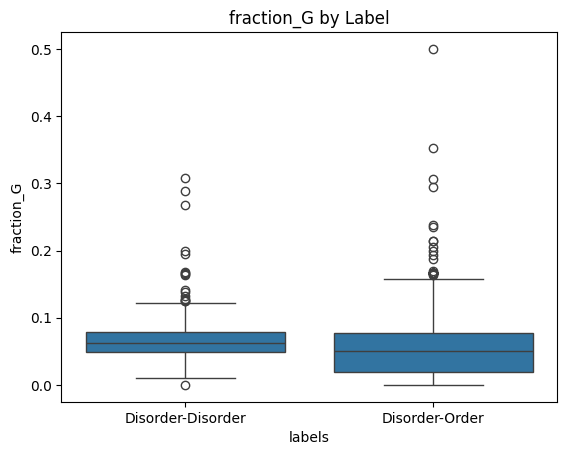

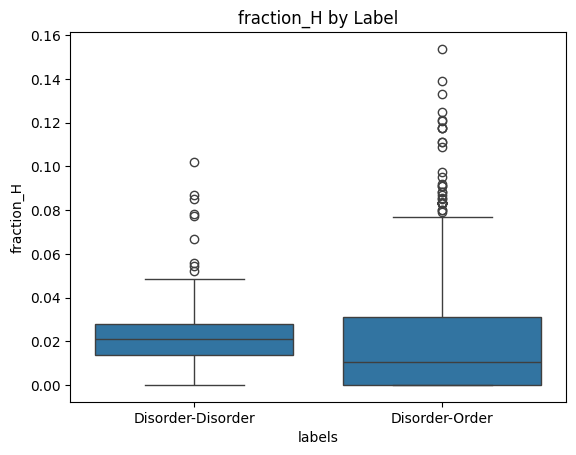

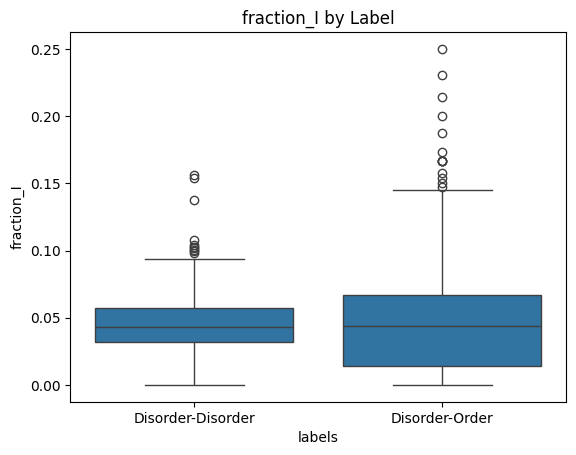

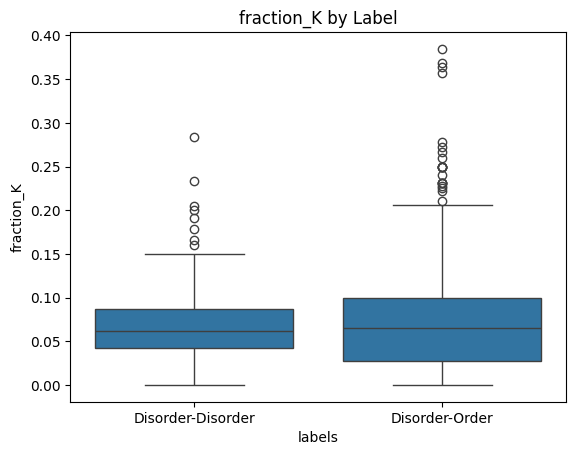

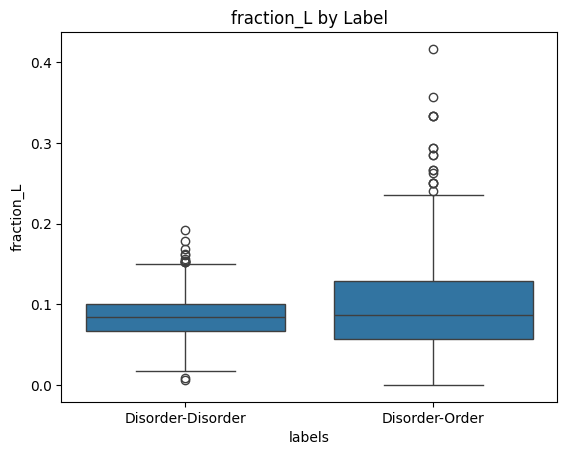

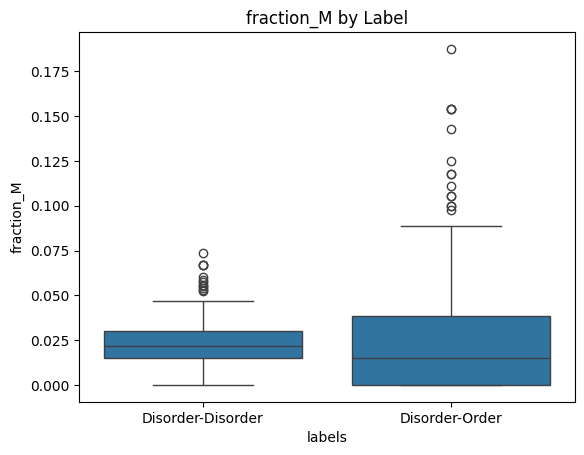

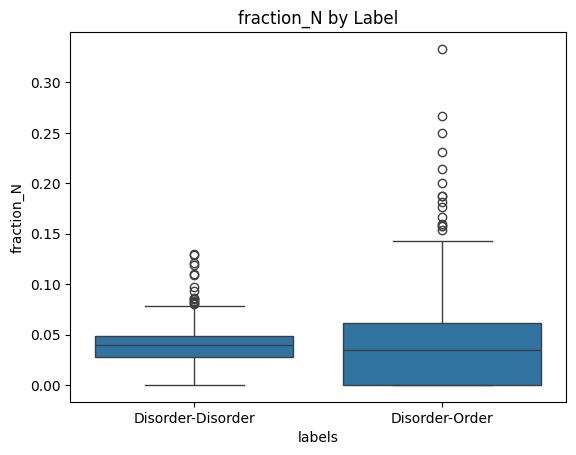

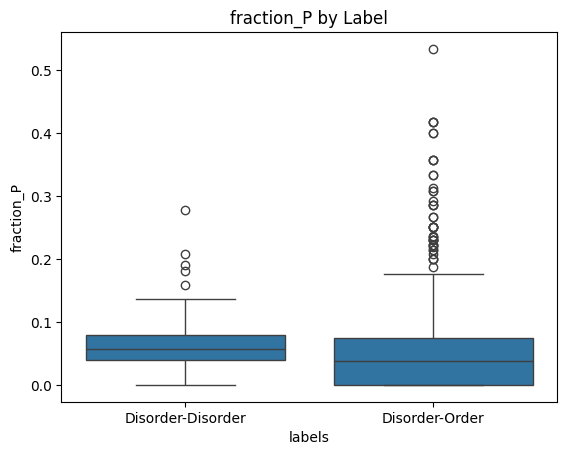

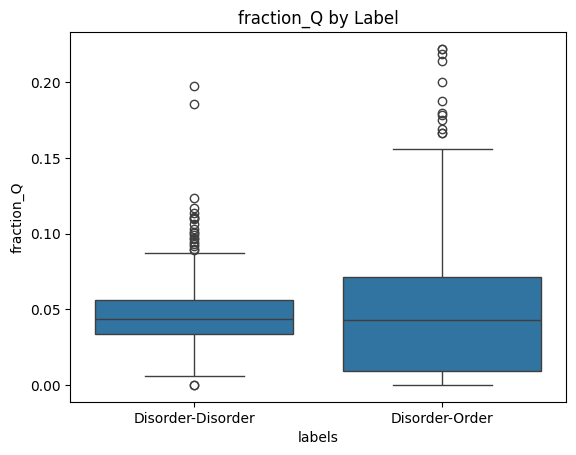

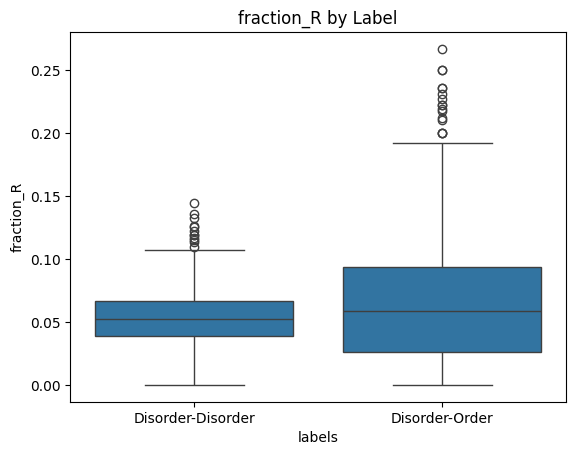

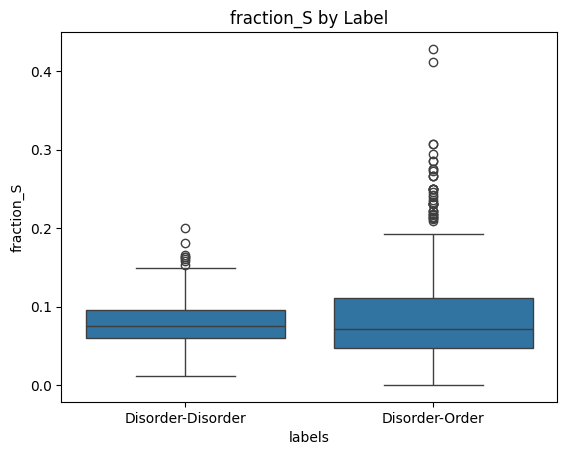

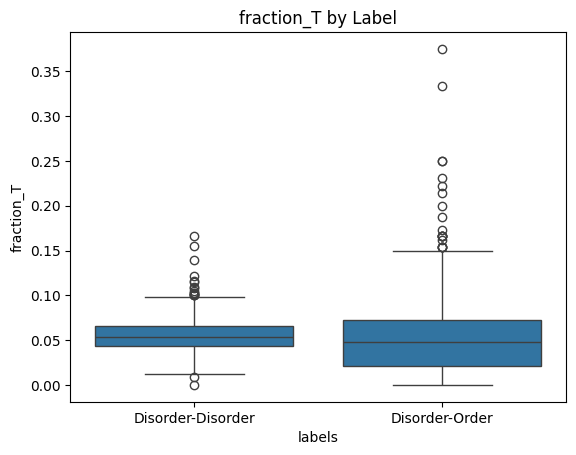

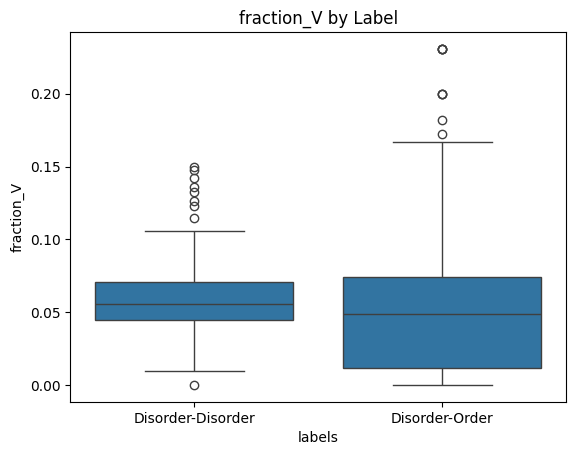

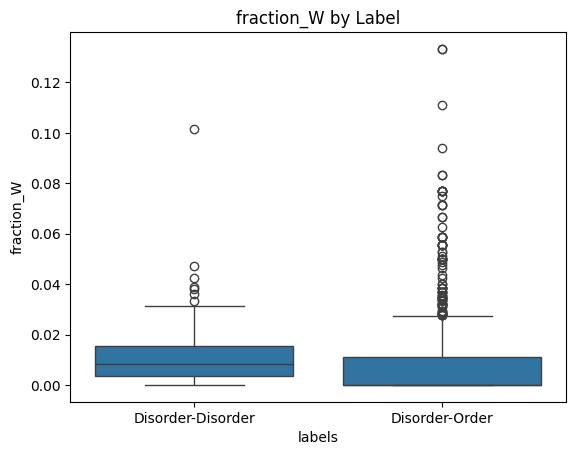

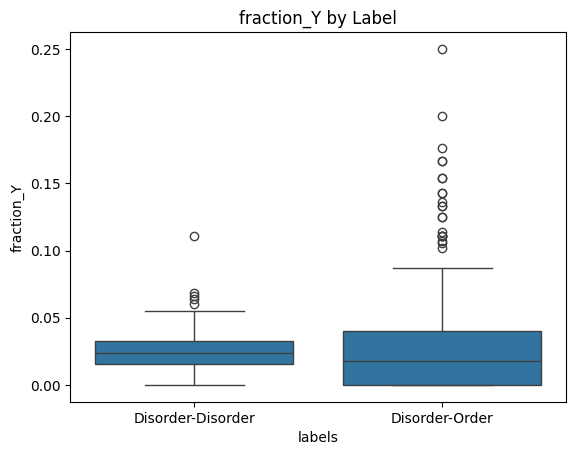

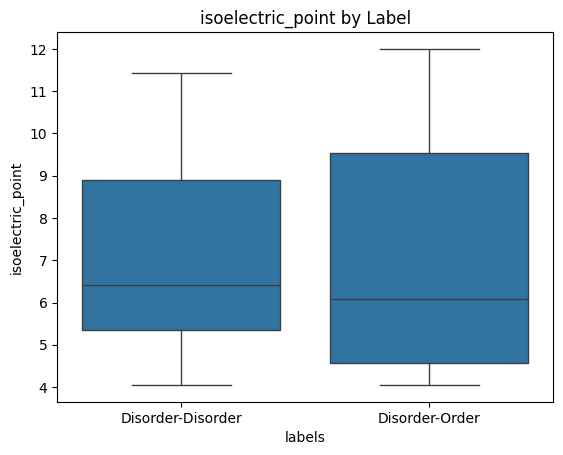

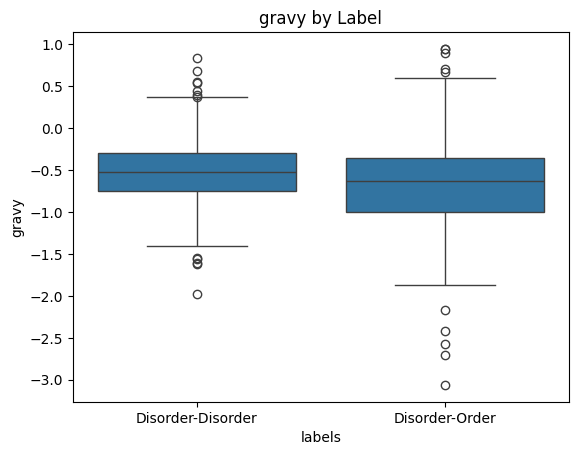

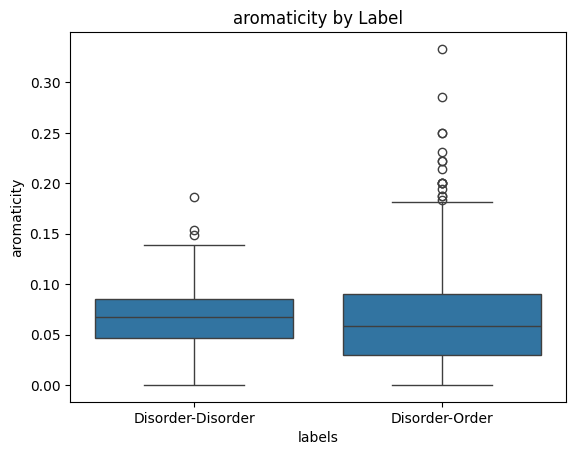

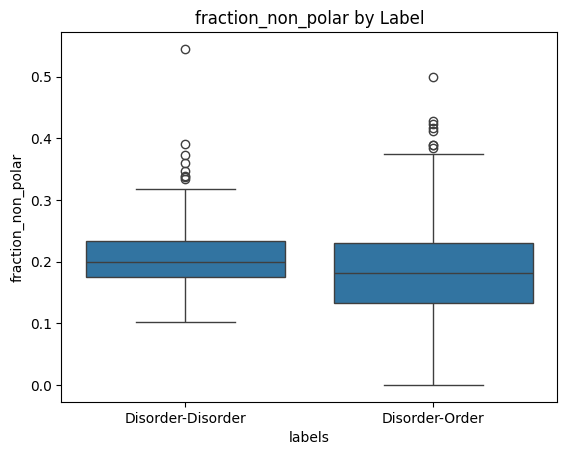

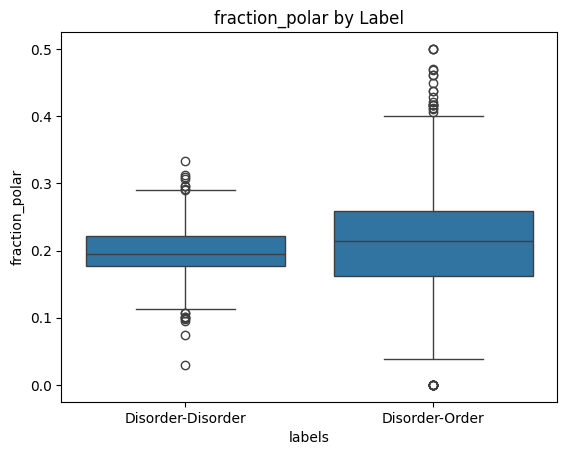

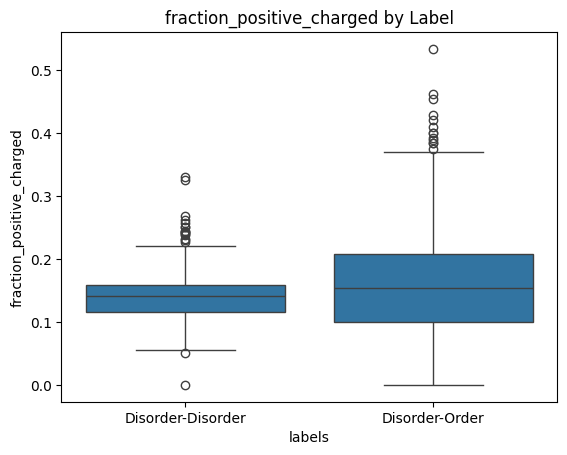

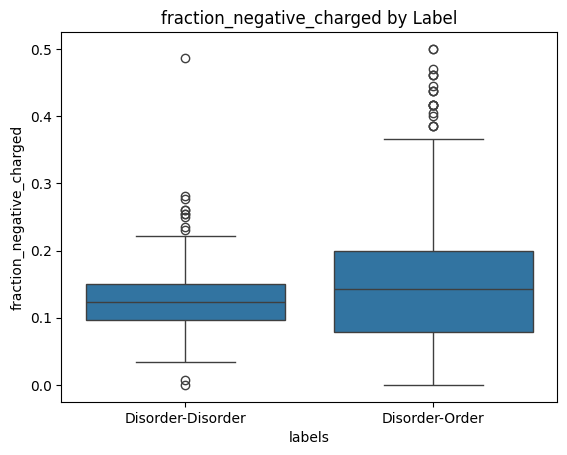

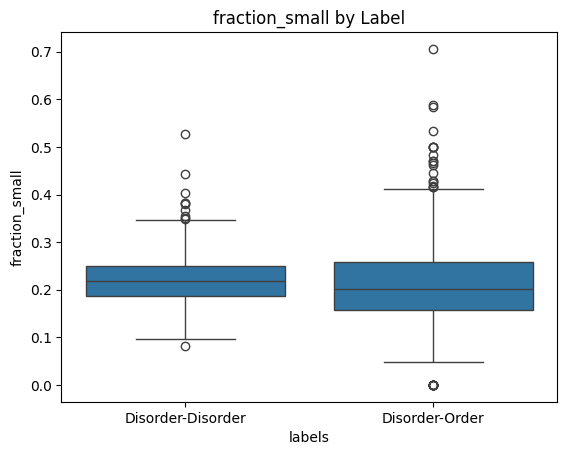

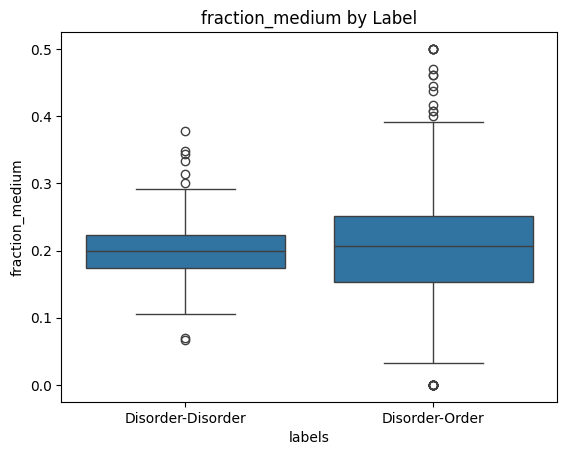

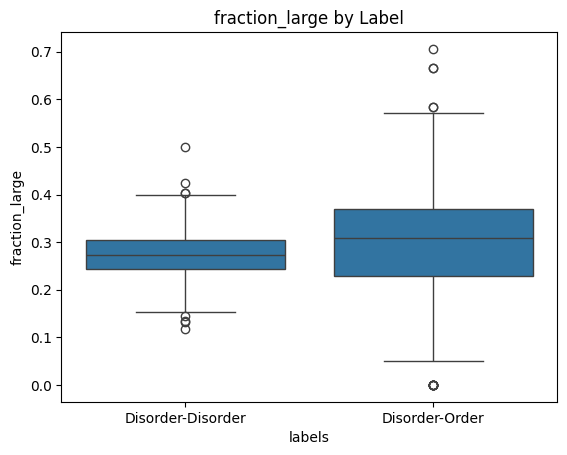

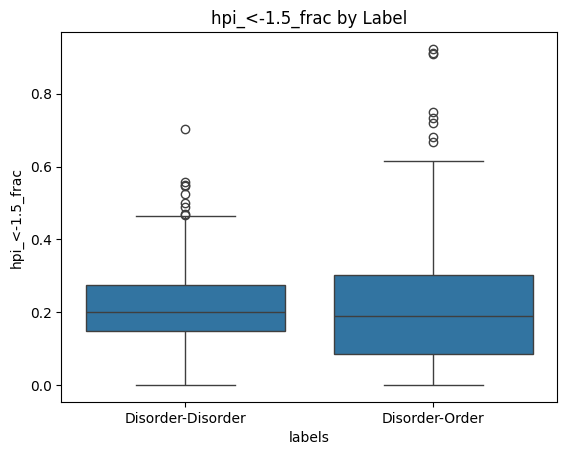

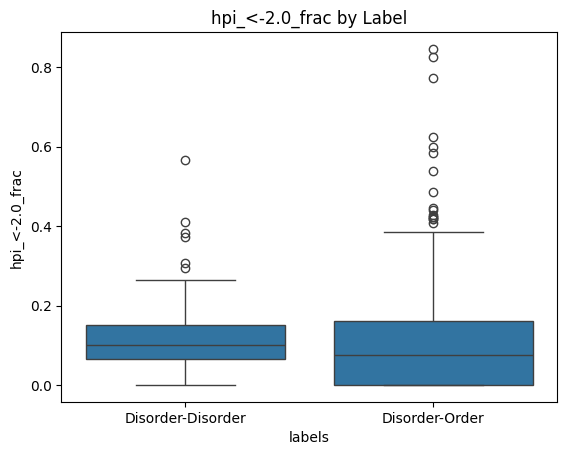

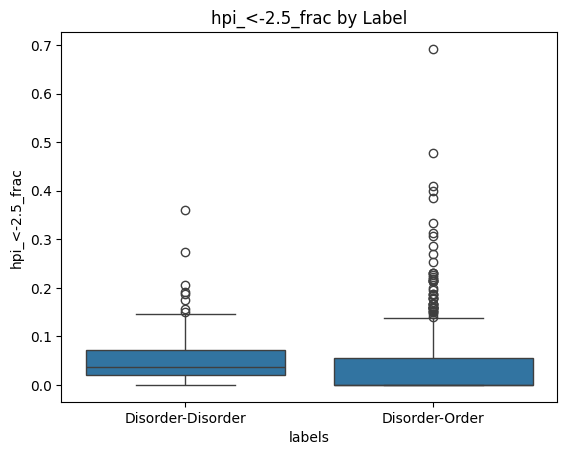

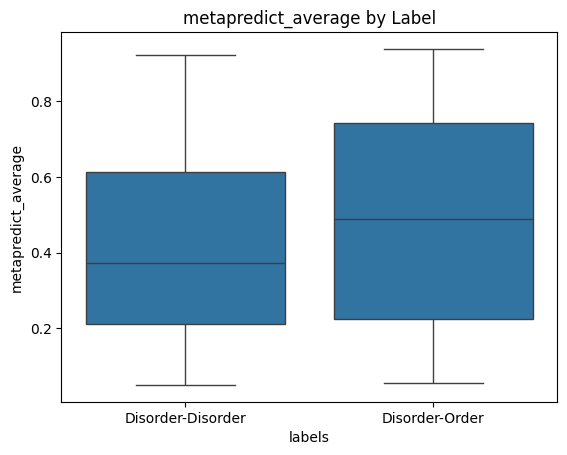

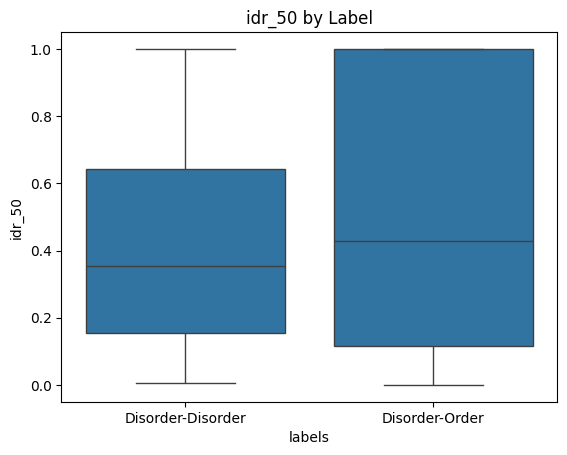

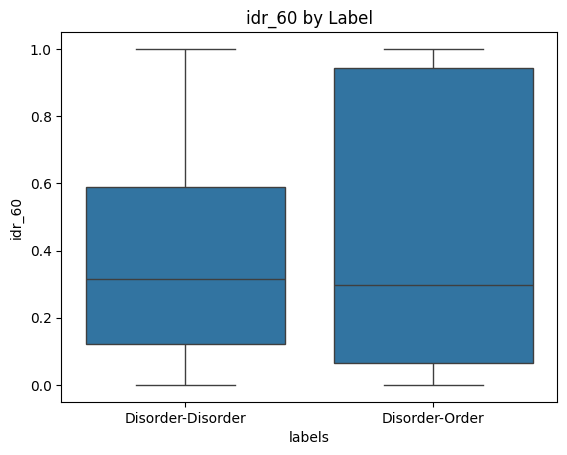

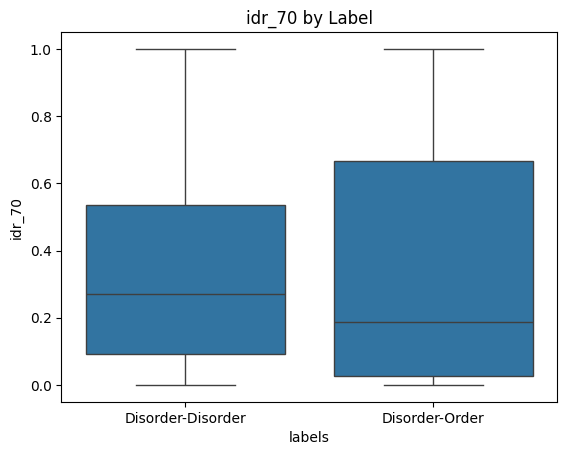

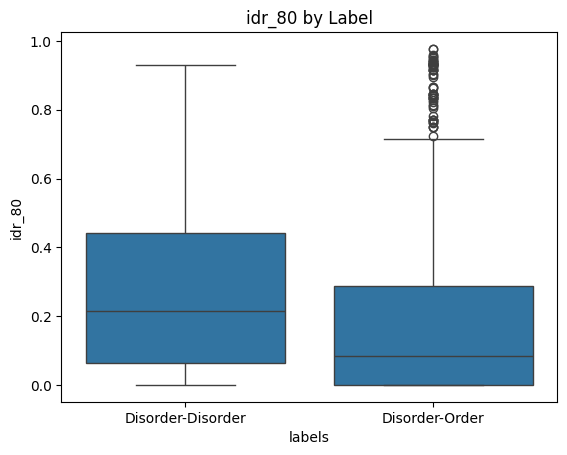

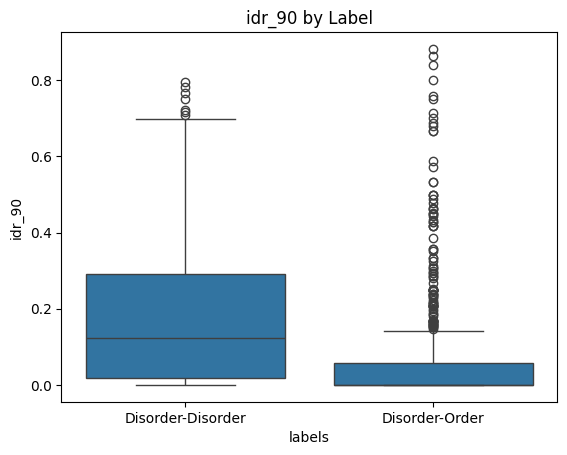

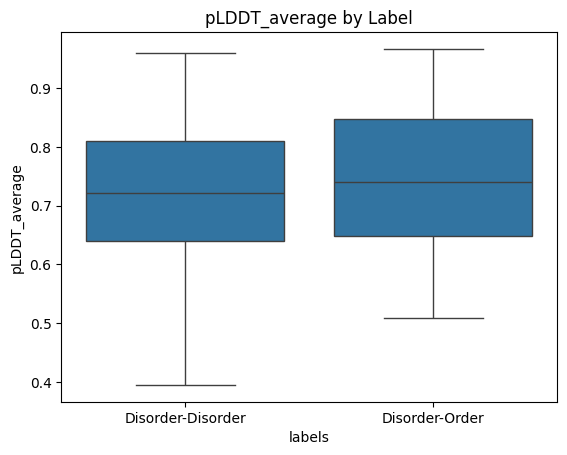

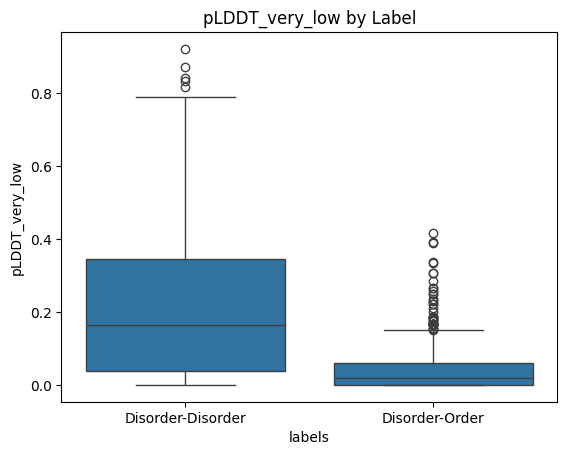

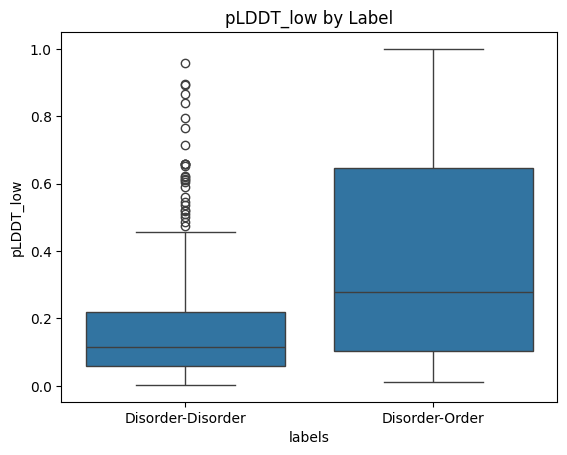

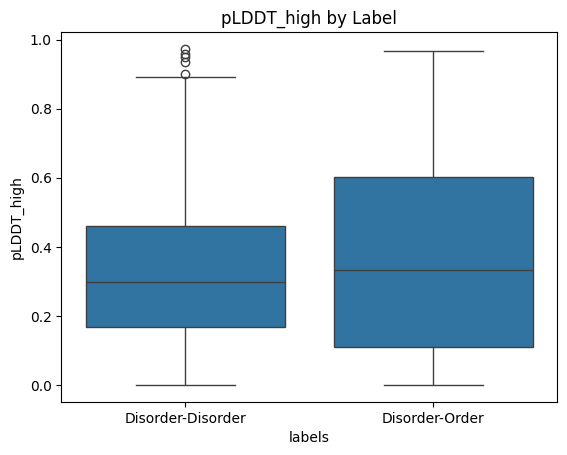

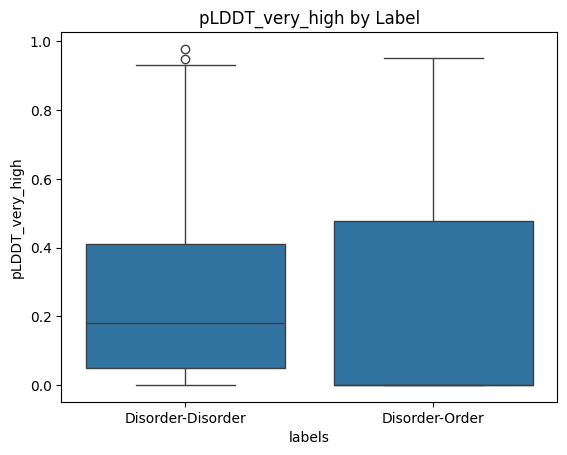

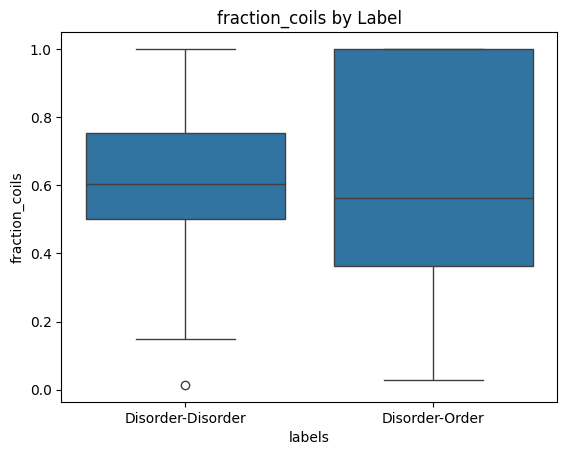

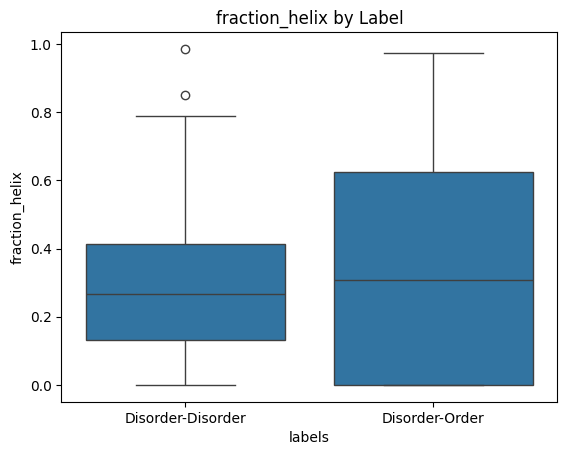

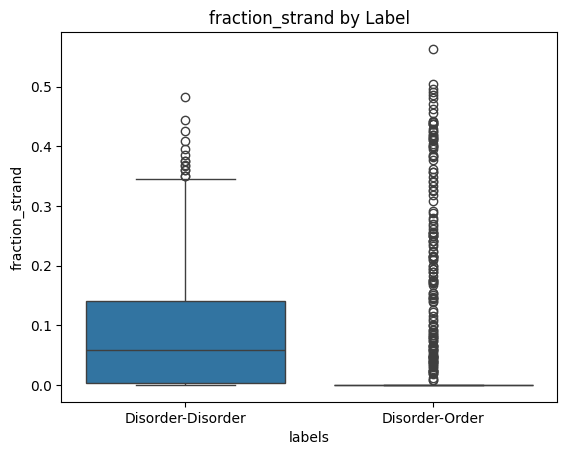

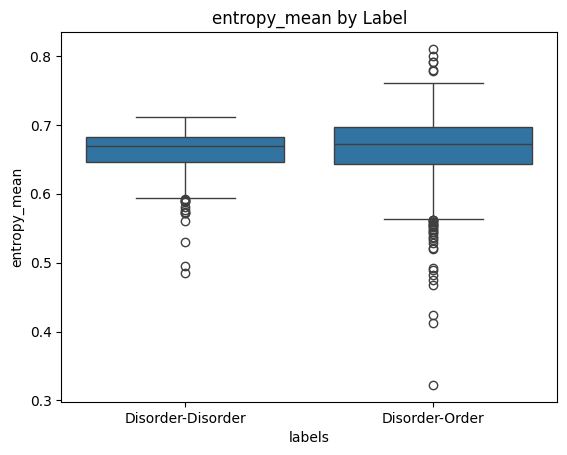

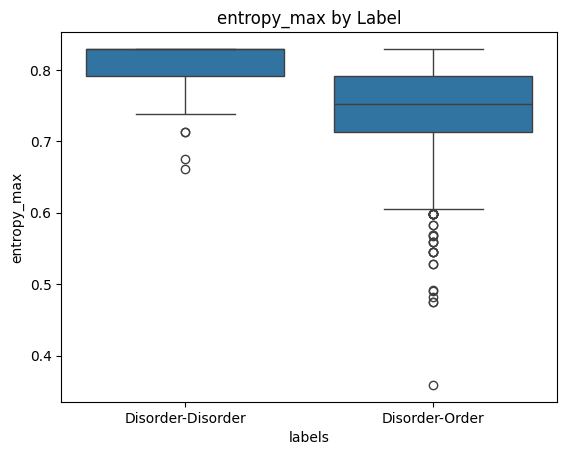

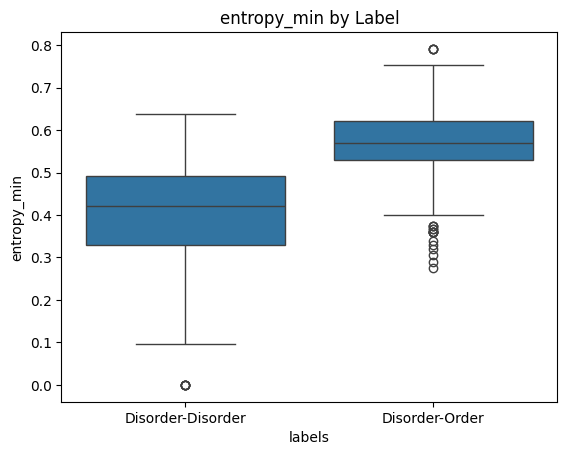

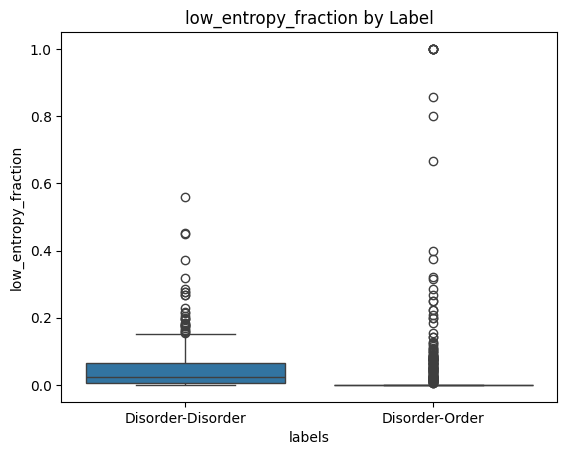

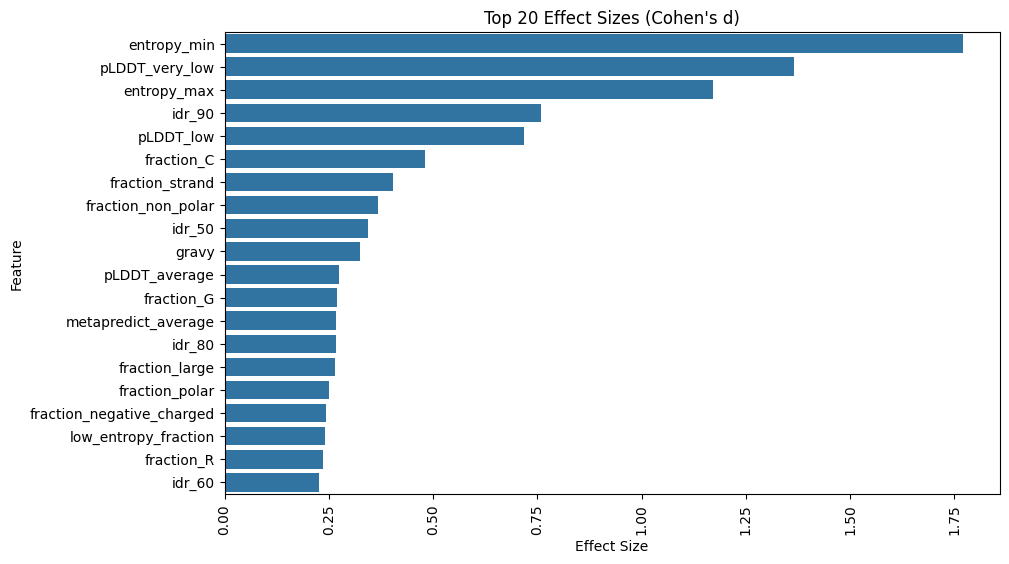

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def calculate_cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = (((nx - 1) * x.std() ** 2 + (ny - 1) * y.std() ** 2) / dof) ** 0.5
    return (x.mean() - y.mean()) / pooled_std


def sanitize_filename(filename):
    return re.sub(r'[<>:"/\\|?*]', '', filename)


numeric_features = combined_df.select_dtypes(include=['number']).columns.tolist()

effect_sizes = {}
for feature in numeric_features:
    class_a = combined_df[combined_df['labels'] == 'Disorder-Disorder'][feature]
    class_b = combined_df[combined_df['labels'] == 'Disorder-Order'][feature]
    effect_size = calculate_cohens_d(class_a, class_b)
    effect_sizes[feature] = abs(effect_size)  

for feature in numeric_features:
    plt.figure()
    sns.boxplot(x='labels', y=feature, data=combined_df)
    plt.title(f'{feature} by Label')
    sanitized_feature = sanitize_filename(feature)
    plt.savefig(f"{sanitized_feature}_boxplot.png")
    plt.show()

effect_size_df = pd.DataFrame(list(effect_sizes.items()), columns=['Feature', 'Effect Size'])

effect_size_df = effect_size_df.nlargest(20, 'Effect Size')

plt.figure(figsize=(10, 6))
sns.barplot(x='Effect Size', y='Feature', data=effect_size_df)
plt.title('Top 20 Effect Sizes (Cohen\'s d)')
plt.xticks(rotation=90)
plt.savefig("Top_20_Feature_effect_size.png")
plt.show()


In [71]:
seq_dd = read_fasta("output_dd_cdhit.fasta")
seq_do = read_fasta("output_do_cdhit.fasta")

In [72]:
seq_mobidb_dd = read_fasta("cdhit_mobidb_DD.fasta")
seq_mobidb_do = read_fasta("cdhit_mobidb_DO.fasta")

common_sequence = set(seq_mobidb_dd) & set(seq_mobidb_do) & set(seq_dd) & set(seq_do)
chars = ["X","U","B", "O", "Z", "J"]
seq_mobidb_dd = [item for item in seq_mobidb_dd if item not in common_sequence and all(char not in item for char in chars)]
seq_mobidb_do = [item for item in seq_mobidb_do if item not in common_sequence and all(char not in item for char in chars)]
print(len(seq_mobidb_dd), len(seq_mobidb_do))

11186 6738


In [ ]:
df_mobidb_do = pd.DataFrame(seq_mobidb_do, columns=["sequence"])
df_mobidb_dd = pd.DataFrame(seq_mobidb_dd, columns=["sequence"])

df_mobidb_dd_sample = df_mobidb_dd[df_mobidb_dd["sequence"].str.len() > 12].sample(n = 100)
df_mobidb_do_sample = df_mobidb_do[df_mobidb_do["sequence"].str.len() > 12].sample(n = 100)

In [74]:
df_mobidb_dd_sample = df_mobidb_dd[df_mobidb_dd["sequence"].str.len() > 12].sample(n = 100)
df_mobidb_do_sample = df_mobidb_do[df_mobidb_do["sequence"].str.len() > 12].sample(n = 100)


In [75]:
df_mobidb_do_sample.to_csv("df_mobidb_do_sample.csv", index=False)
df_mobidb_dd_sample.to_csv("df_mobidb_dd_sample.csv", index=False)

In [113]:
df_mobidb_dd_sample

sequence
1683                                   MSDVEEVVEVQEETVVE
7275                                    QEEEVRPKGRQRKLWK
2772                              MIEHVPMEDKRKGAAALDEARL
10897                                    QKVRGHGGYVGEDEI
7050                            TQVFGDLPRPRLNTSDFQKLKRKY
...                                                  ...
2757                              MATHHTLWMGLALLGVLGDLQA
9331                                     PGFSLFGDETLQKYQ
9792                                  MGSDEPAQAESSQQAQVK
4499                  MKNNSTVAKSTLVLLVVTCLTAFKGLAFDSISPD
7543   MKKTKNNYYTRPLAIGLSTFALASIVYGGIQNETHASEKSNMDVSK...

[100 rows x 1 columns]

In [125]:
#process_df(df_mobidb_dd_sample.head(2))
#print(df_mobidb_dd_sample.head(2))
test = df_mobidb_dd_sample.head(2)
#add_predict_pLDDT_scores(test)
#test
test = test.reset_index(drop=True)
process_df(test)

sequence  fraction_A  fraction_C  fraction_D  fraction_E  \
0  MSDVEEVVEVQEETVVE         0.0         0.0    0.058824    0.352941   
1   QEEEVRPKGRQRKLWK         0.0         0.0    0.000000    0.187500   

   fraction_F  fraction_G  fraction_H  fraction_I  fraction_K  ...    idr_80  \
0         0.0      0.0000         0.0         0.0      0.0000  ...  0.411765   
1         0.0      0.0625         0.0         0.0      0.1875  ...  0.625000   

   idr_90  pLDDT_average  pLDDT_very_low  pLDDT_low  pLDDT_high  \
0  0.0000       0.640475        0.058824   0.941176         0.0   
1  0.1875       0.580067        0.062500   0.937500         0.0   

   pLDDT_very_high  fraction_coils  fraction_helix  fraction_strand  
0              0.0             1.0             0.0              0.0  
1              0.0             1.0             0.0              0.0  

[2 rows x 52 columns]

In [129]:
df_mobidb_dd_sample = df_mobidb_dd_sample.reset_index(drop=True)
df_mobidb_do_sample = df_mobidb_do_sample.reset_index(drop=True)

In [130]:
df_mobidb_dd_sample_features = process_df(df_mobidb_dd_sample)

In [145]:
df_mobidb_dd_sample_features["labels"] = "Disorder-Disorder"

In [137]:
df_mobidb_dd_sample_features.to_csv("df_dd_test_mobidb.csv", index=False)

In [ ]:
df_mobidb_do_sample_features = process_df(df_mobidb_do_sample)
df_mobidb_do_sample_features["labels"] = "Disorder-Order"

In [141]:
df_mobidb_do_sample_features["labels"] = "Disorder-Order"

In [142]:
df_mobidb_do_sample_features.to_csv("df_do_test_mobidb.csv", index=False)

In [147]:
df_mobidb_do_sample_features = df_mobidb_do_sample_features.round(4)
df_mobidb_dd_sample_features = df_mobidb_dd_sample_features.round(4)
df_mobidb_do_sample_features.to_csv("df_do_test_mobidb.csv", index=False)
df_mobidb_dd_sample_features.to_csv("df_dd_test_mobidb.csv", index=False)

In [169]:
seq_mobidb_dd = read_fasta("cdhit_mobidb_DD.fasta")
seq_mobidb_do = read_fasta("cdhit_mobidb_DO.fasta")

common_sequence = set(seq_mobidb_dd) & set(seq_mobidb_do)
chars = ["X","U","B", "O", "Z", "J"]
seq_mobidb_dd = [item for item in seq_mobidb_dd if item not in common_sequence and all(char not in item for char in chars)]
seq_mobidb_do = [item for item in seq_mobidb_do if item not in common_sequence and all(char not in item for char in chars)]
print(len(seq_mobidb_dd), len(seq_mobidb_do))

10517 6472


In [170]:
df_mobidb_do = pd.DataFrame(seq_mobidb_do, columns=["sequence"])
df_mobidb_dd = pd.DataFrame(seq_mobidb_dd, columns=["sequence"])
df_mobidb_dd_subset = df_mobidb_dd[df_mobidb_dd["sequence"].str.len() > 12].sample(n = 1000)
df_mobidb_do_subset = df_mobidb_do[df_mobidb_do["sequence"].str.len() > 12].sample(n = 1000)
df_mobidb_dd_subset = df_mobidb_dd_subset.reset_index(drop=True)
df_mobidb_do_subset = df_mobidb_do_subset.reset_index(drop=True)

In [174]:
df_mobidb_do_subset_features = process_df(df_mobidb_do_subset)
df_mobidb_do_subset_features.to_csv("df_mobidb_do_subset_features.csv", index=False)

In [177]:
df_mobidb_dd_subset_features = process_df(df_mobidb_dd_subset)
df_mobidb_dd_subset_features.to_csv("df_mobidb_dd_subset_features.csv", index=False)

In [182]:
df_mobidb_do = pd.DataFrame(seq_mobidb_do, columns=["sequence"])
df_mobidb_dd = pd.DataFrame(seq_mobidb_dd, columns=["sequence"])
df_mobidb_dd_subset = df_mobidb_dd[df_mobidb_dd["sequence"].str.len() > 12].sample(n = 2500)
df_mobidb_do_subset = df_mobidb_do[df_mobidb_do["sequence"].str.len() > 12].sample(n = 2500)
df_mobidb_dd_subset = df_mobidb_dd_subset.reset_index(drop=True)
df_mobidb_do_subset = df_mobidb_do_subset.reset_index(drop=True)

In [183]:
df_mobidb_do_subset_features = process_df(df_mobidb_do_subset)
df_mobidb_do_subset_features.to_csv("df_mobidb_do_subset_features1.csv", index=False)
df_mobidb_dd_subset_features = process_df(df_mobidb_dd_subset)
df_mobidb_dd_subset_features.to_csv("df_mobidb_dd_subset_features1.csv", index=False)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score,accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [185]:
df_dd = pd.read_csv("df_mobidb_dd_subset_features1.csv")
df_dd = df_dd.round(4)
df_do = pd.read_csv("df_mobidb_do_subset_features1.csv")
df_do = df_do.round(4)
df_dd["labels"] = "DD"
df_do["labels"] = "DO"
df = pd.concat([df_dd, df_do]).sample(frac=1).reset_index(drop=True)
df.to_csv("df_mobidb_features1.csv", index=False)

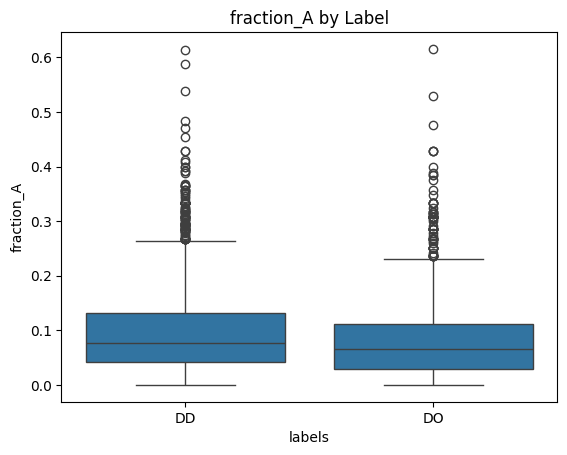

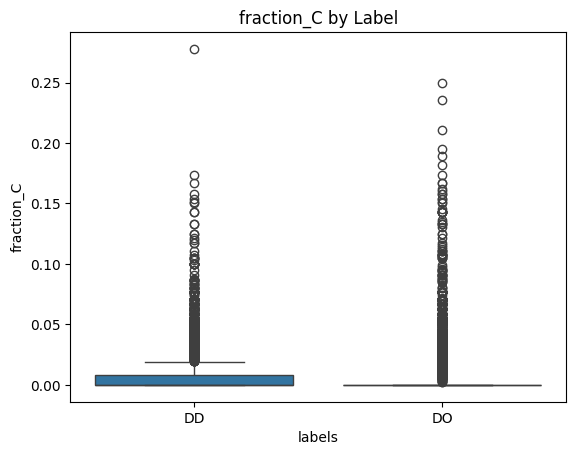

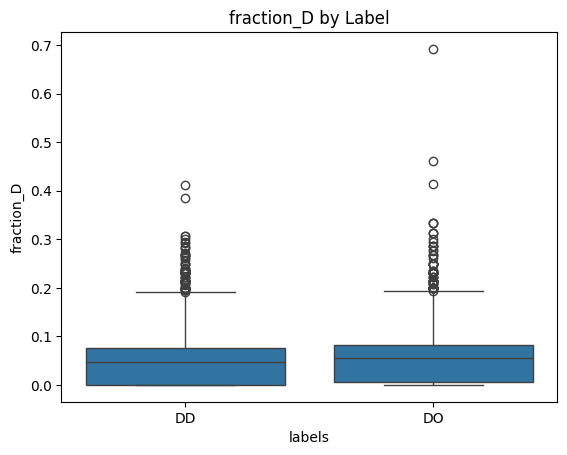

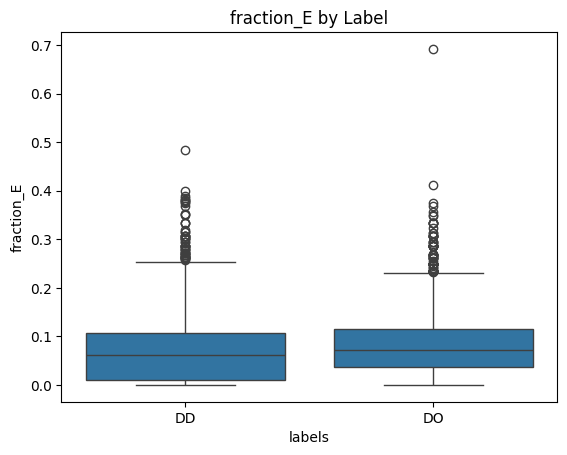

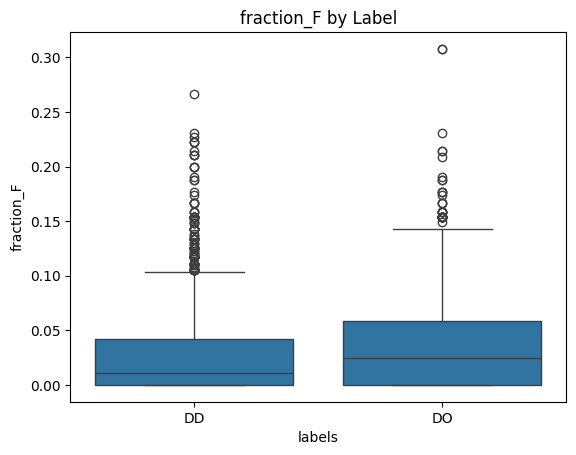

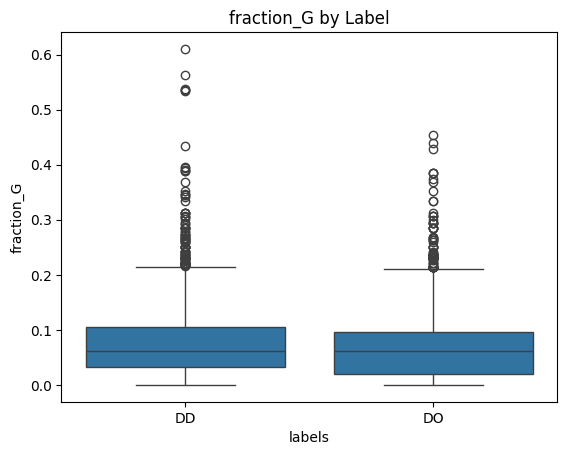

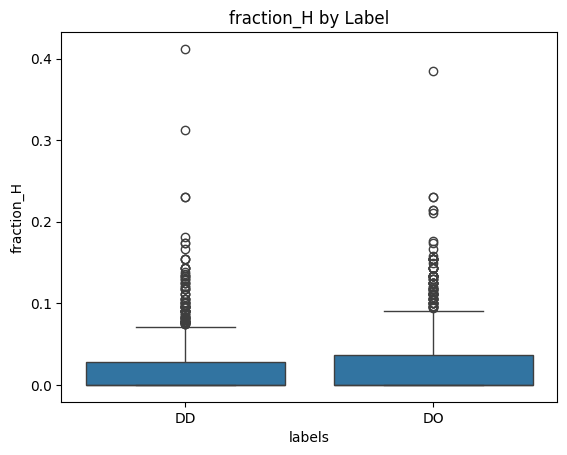

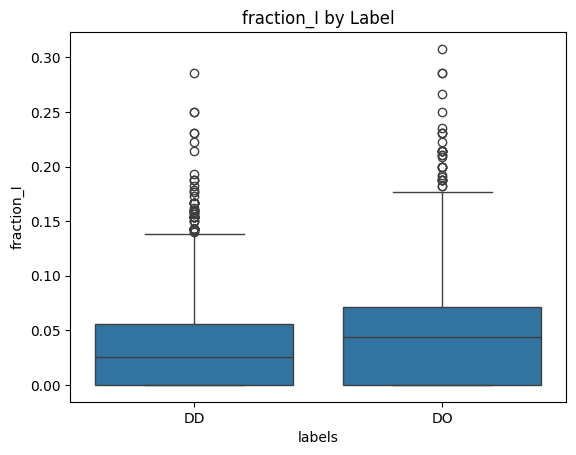

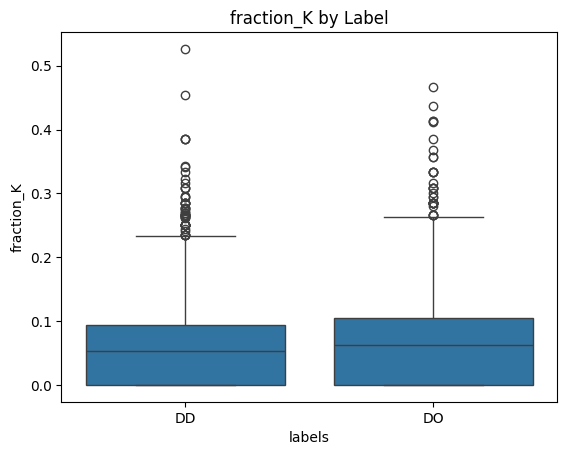

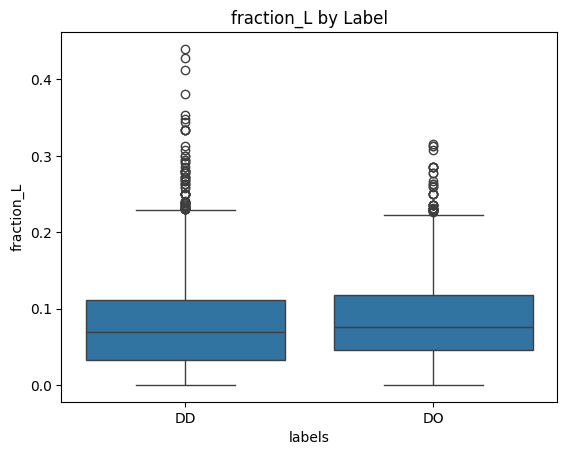

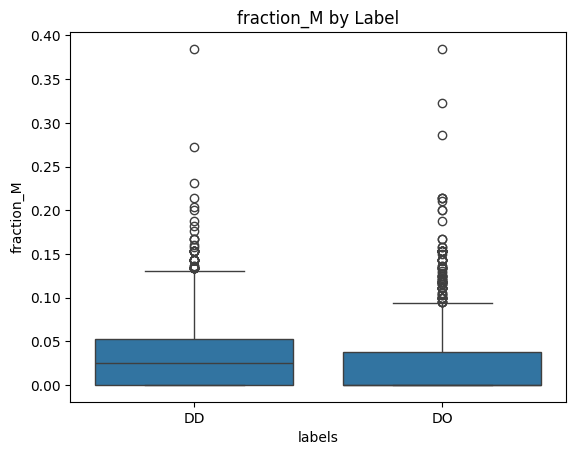

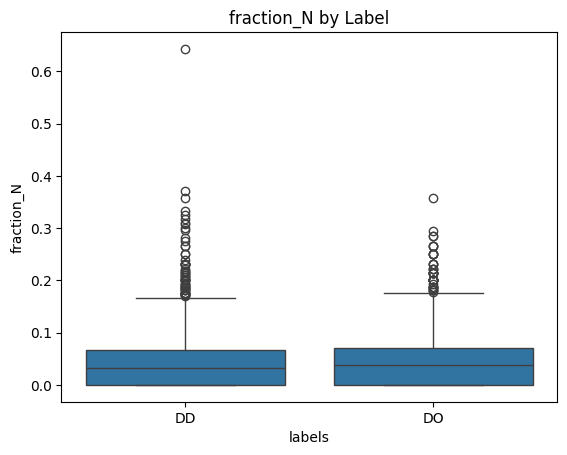

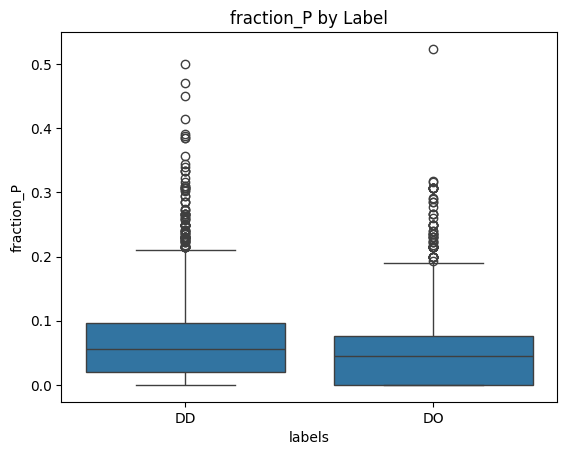

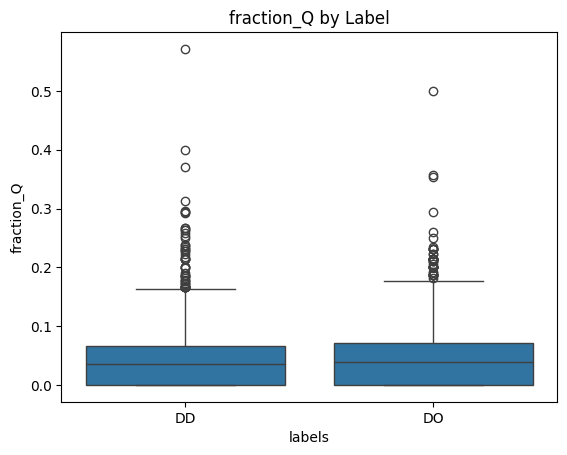

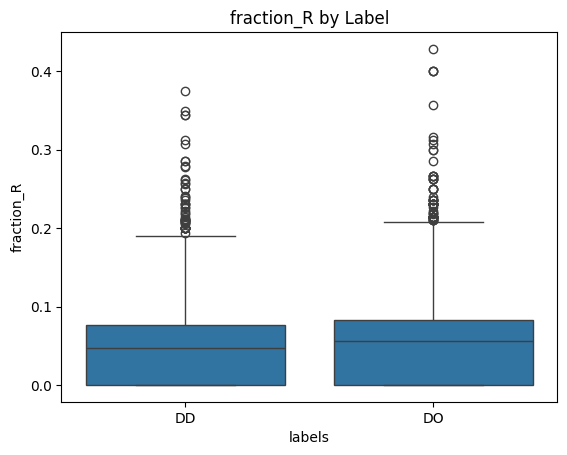

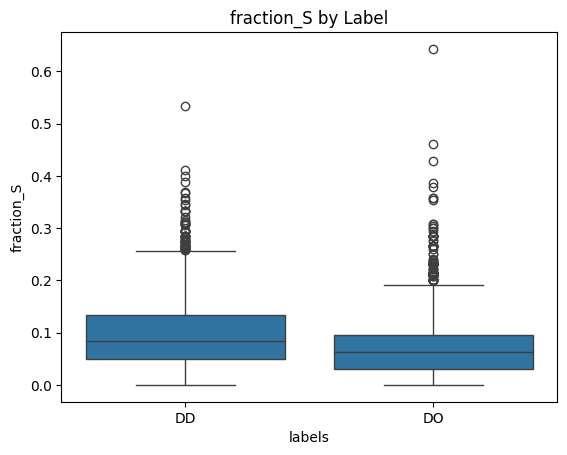

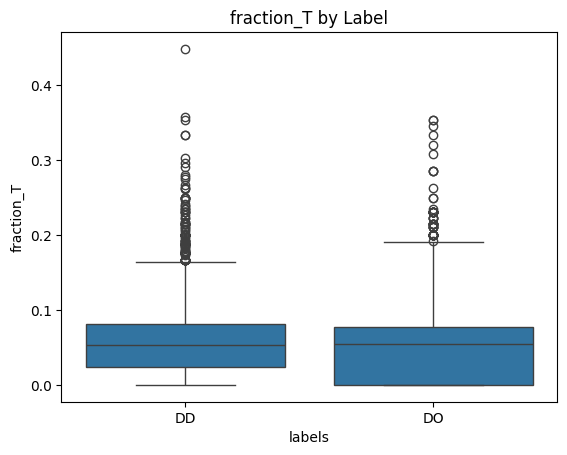

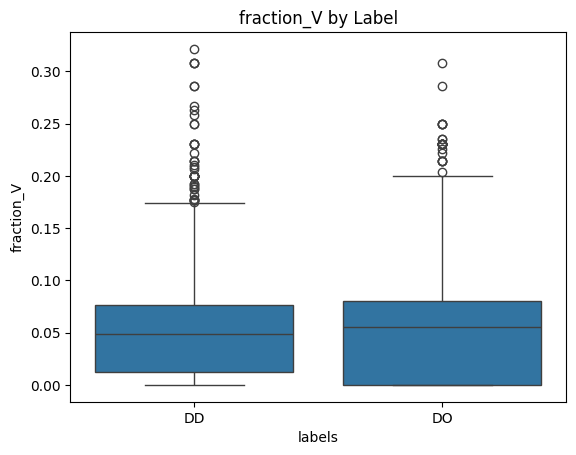

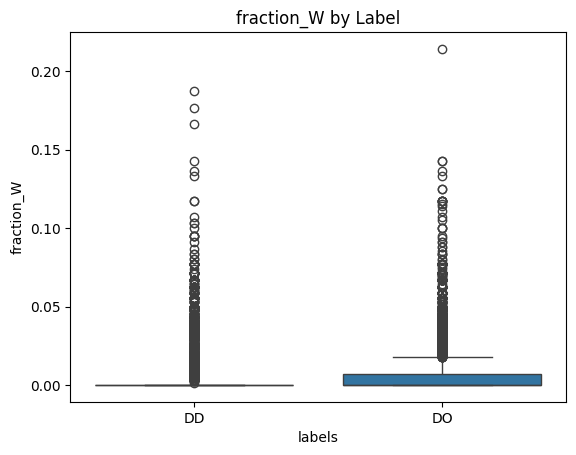

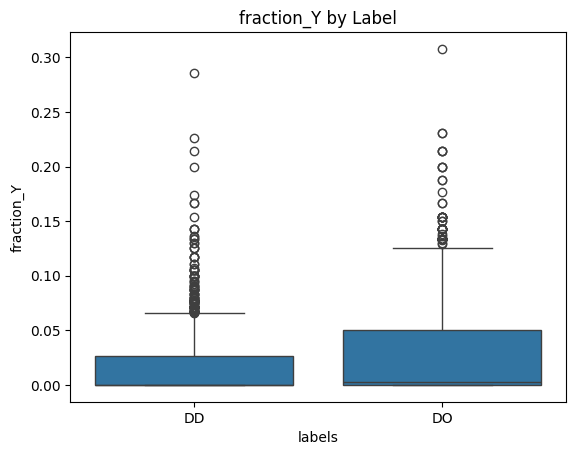

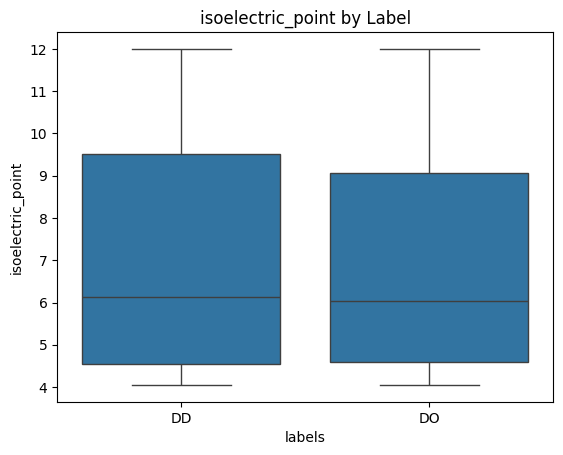

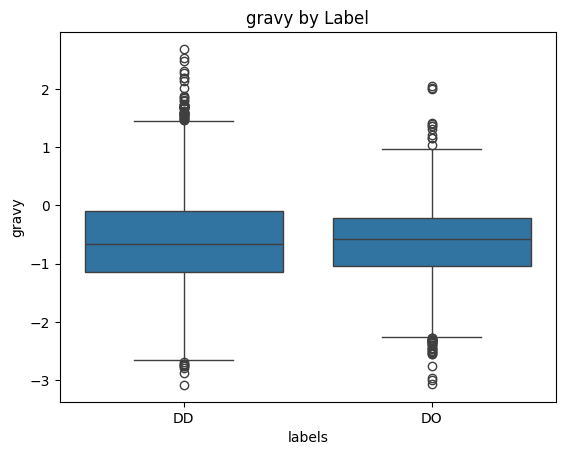

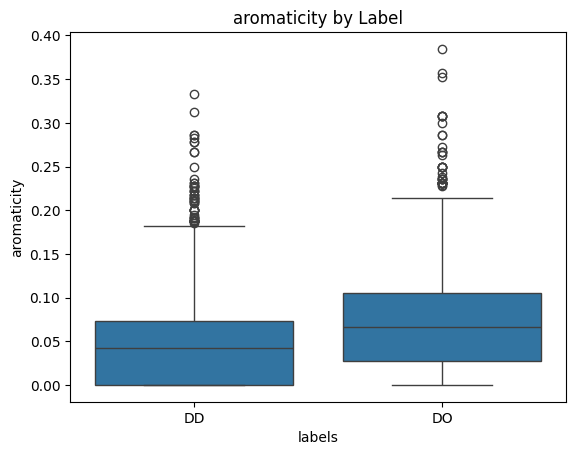

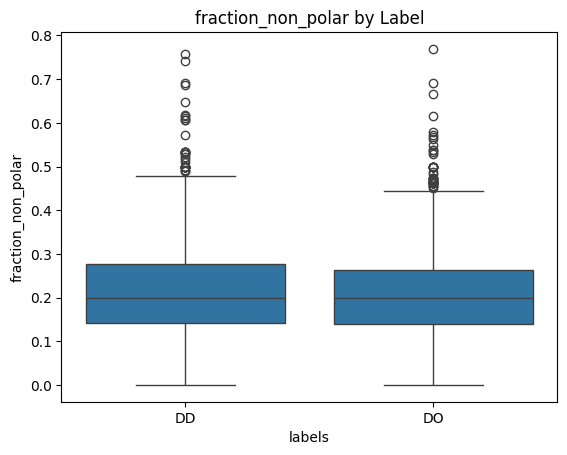

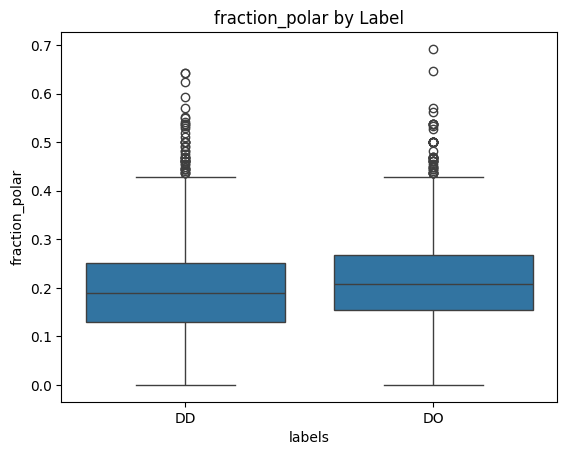

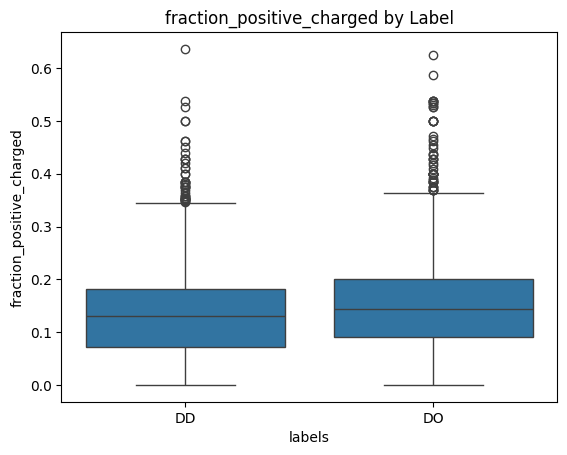

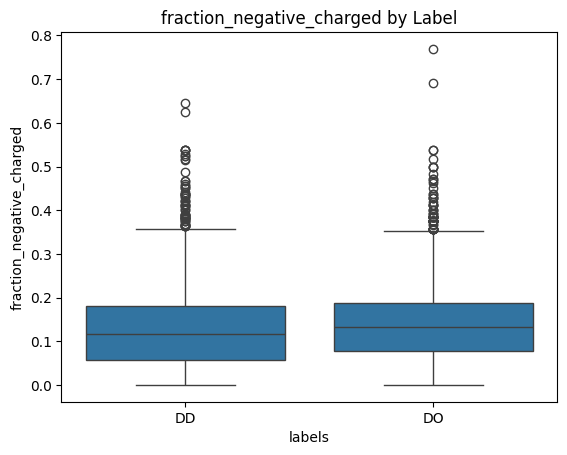

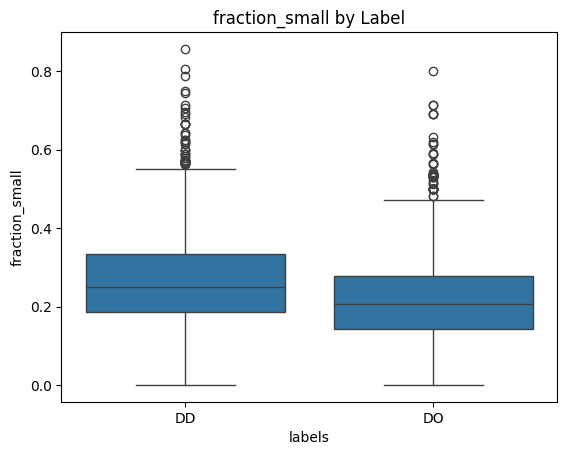

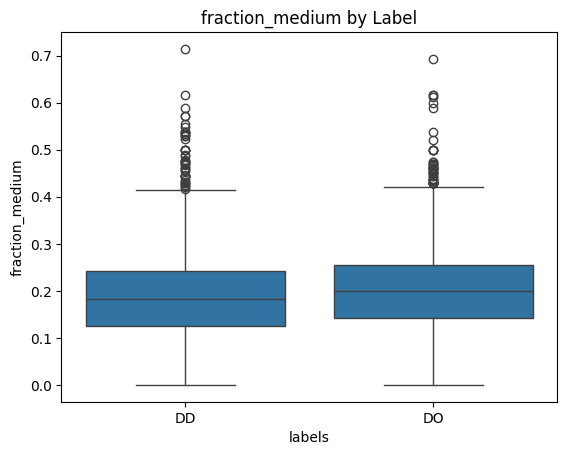

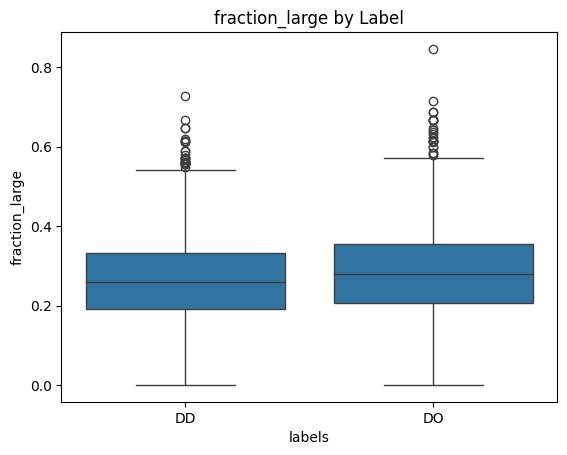

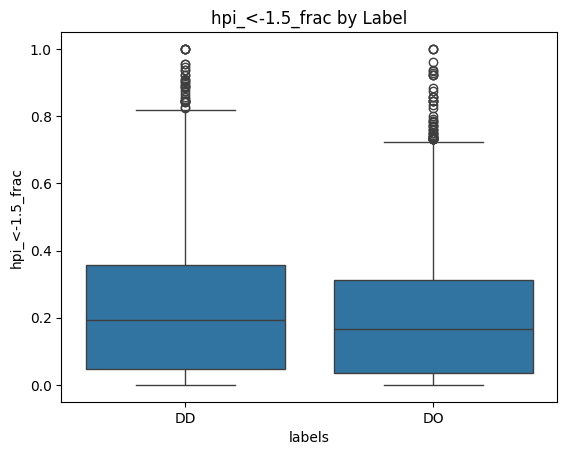

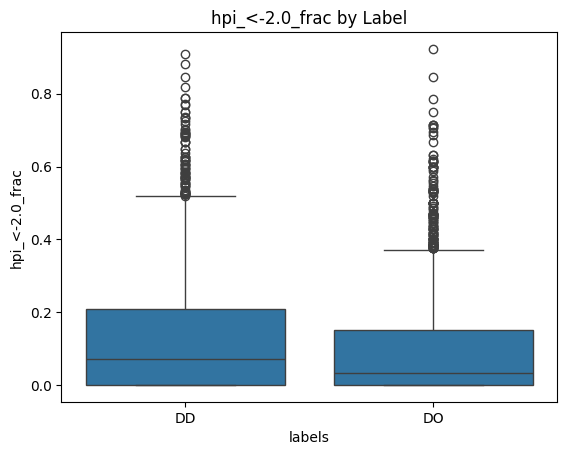

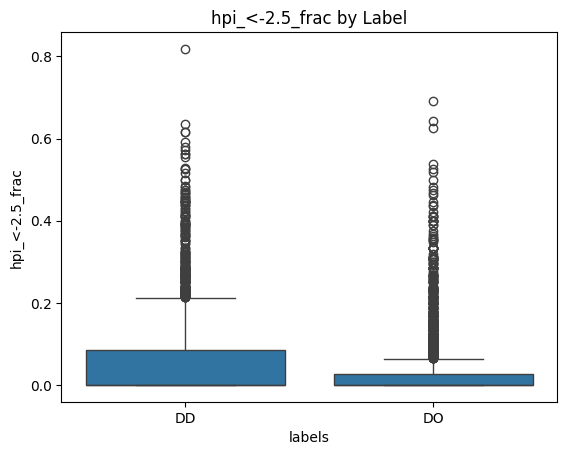

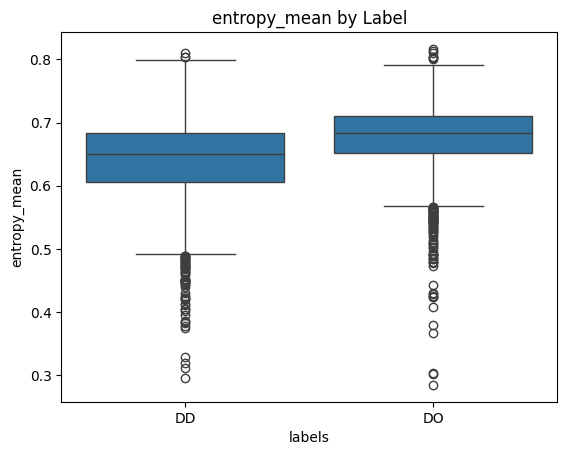

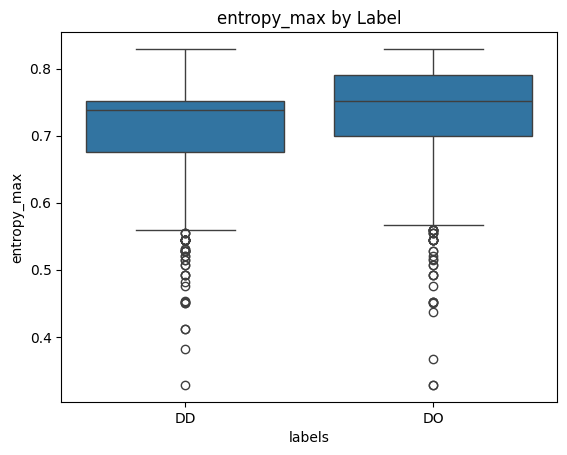

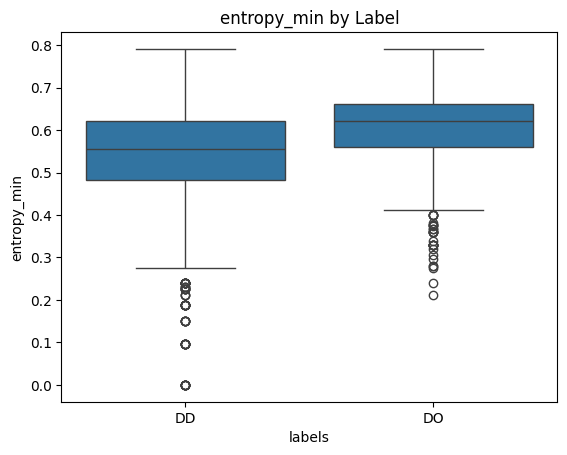

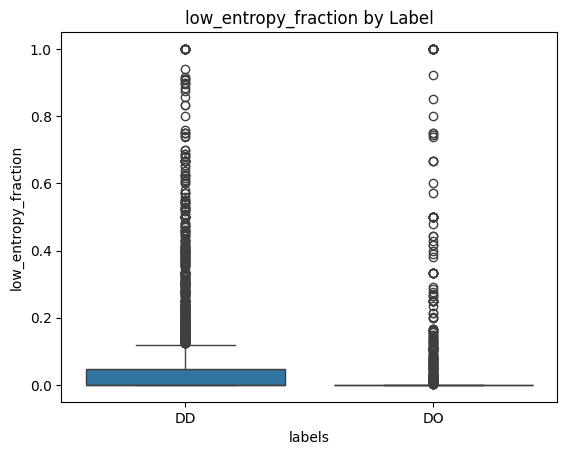

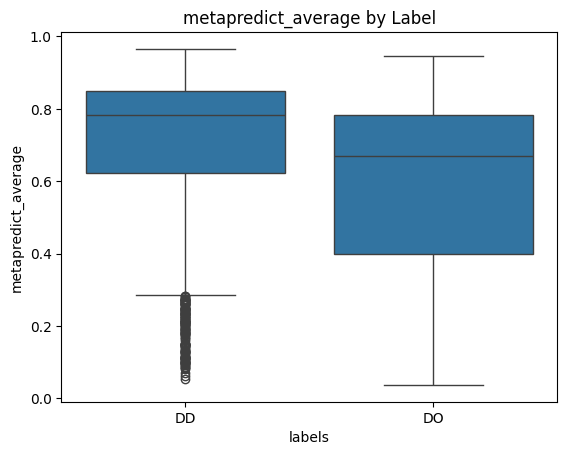

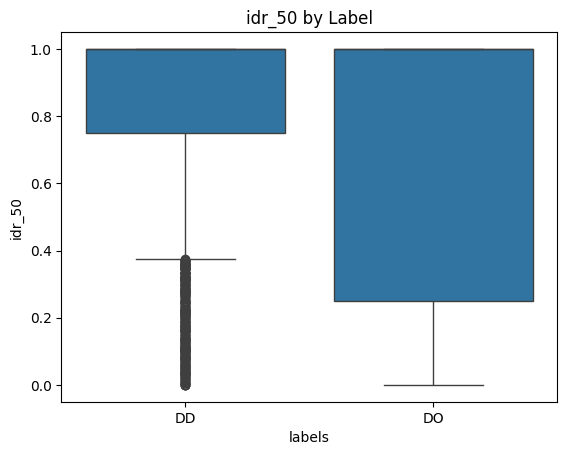

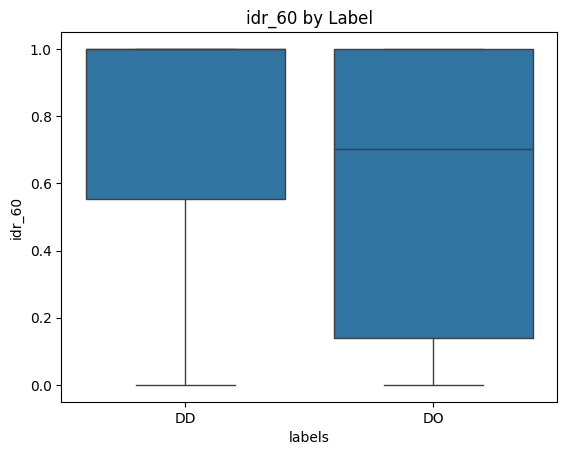

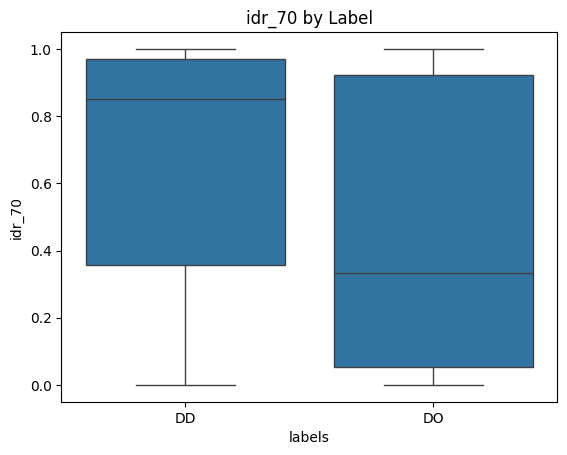

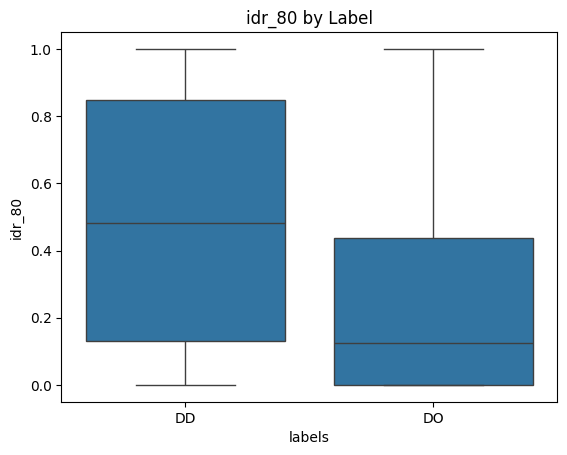

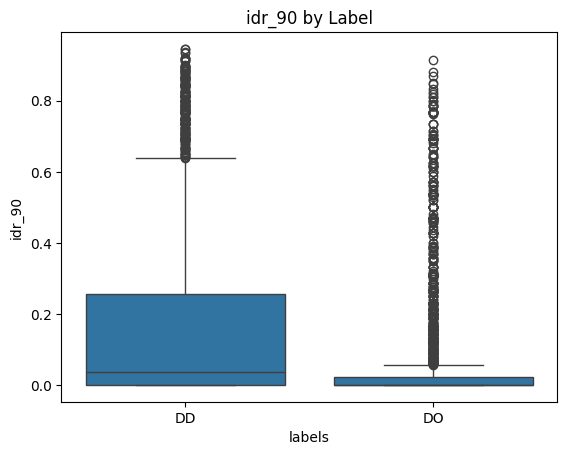

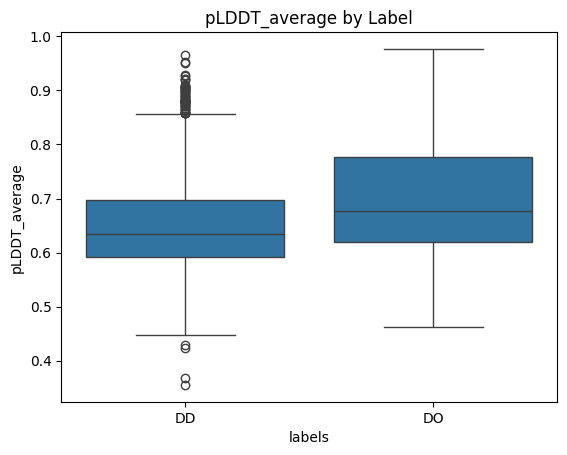

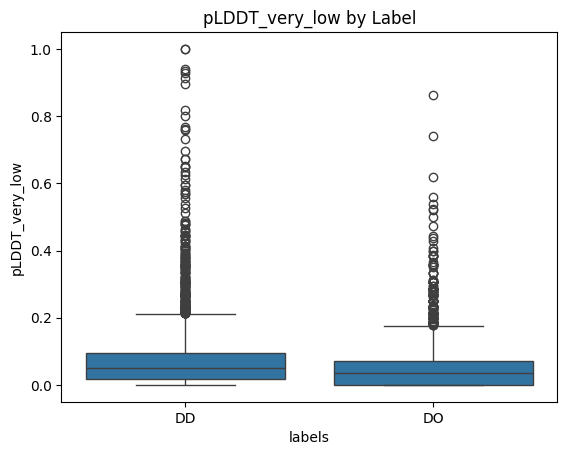

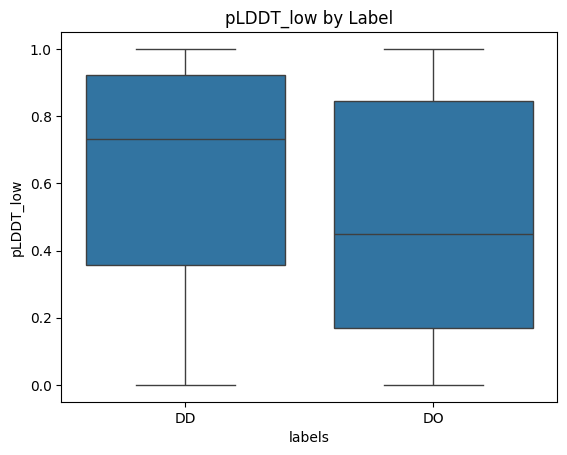

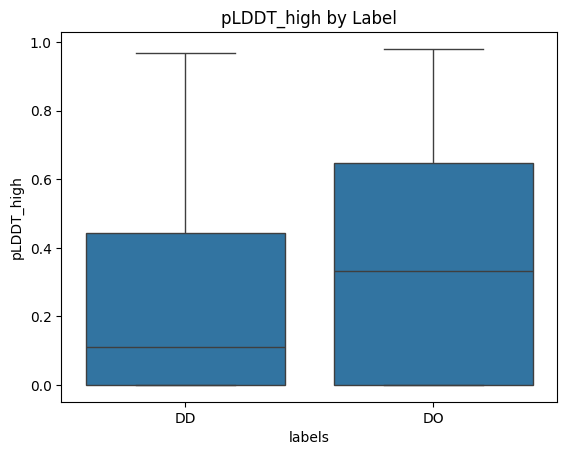

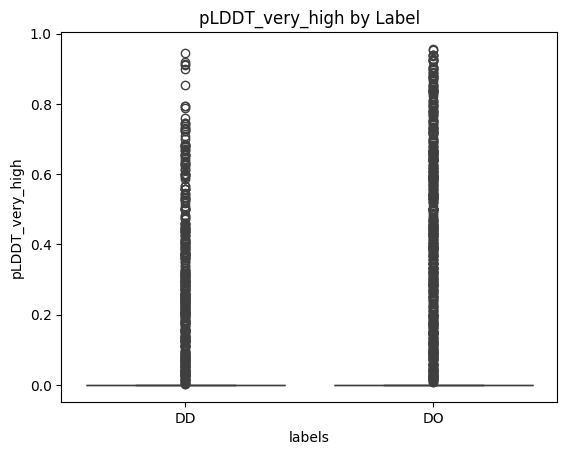

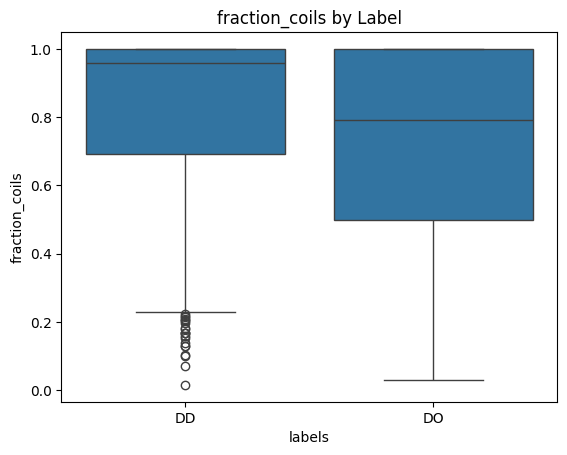

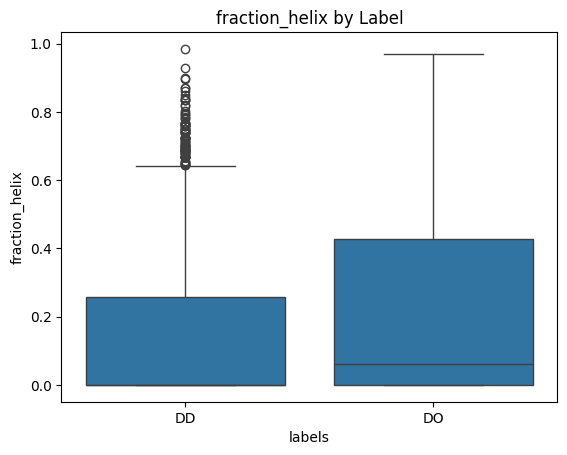

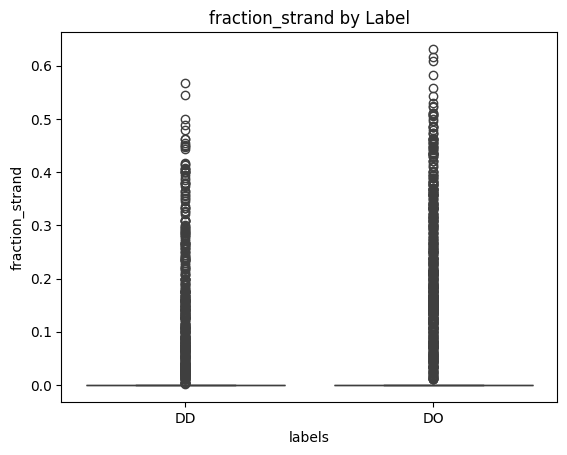

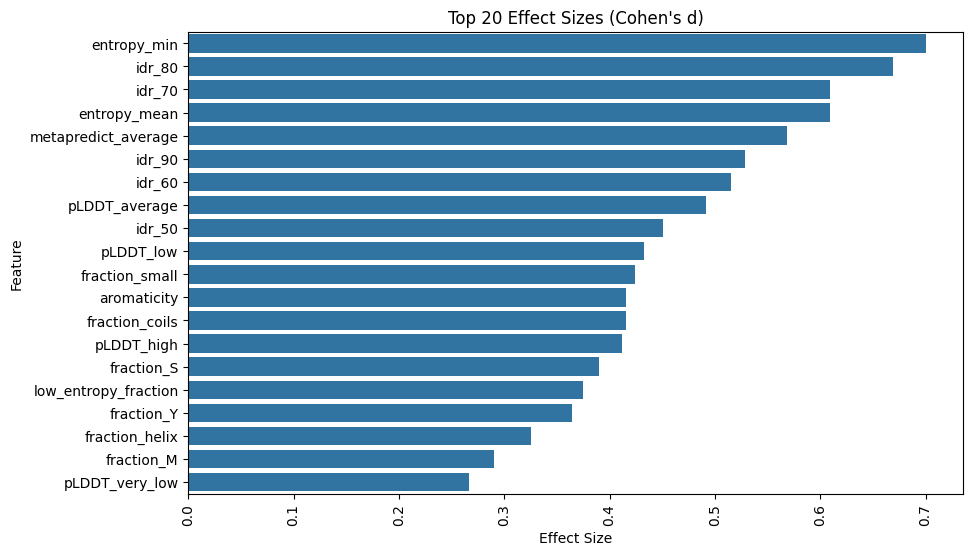

In [186]:

def calculate_cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = (((nx - 1) * x.std() ** 2 + (ny - 1) * y.std() ** 2) / dof) ** 0.5
    return (x.mean() - y.mean()) / pooled_std

def sanitize_filename(filename):
    return re.sub(r'[<>:"/\\|?*]', '', filename)


numeric_features = df.select_dtypes(include=['number']).columns.tolist()

effect_sizes = {}
for feature in numeric_features:
    class_a = df[df['labels'] == 'DD'][feature]
    class_b = df[df['labels'] == 'DO'][feature]
    effect_size = calculate_cohens_d(class_a, class_b)
    effect_sizes[feature] = abs(effect_size)  # Use absolute value

for feature in numeric_features:
    plt.figure()
    sns.boxplot(x='labels', y=feature, data=df)
    plt.title(f'{feature} by Label')
    sanitized_feature = sanitize_filename(feature)
    plt.savefig(f"images/{sanitized_feature}_boxplot.png")
    plt.show()

effect_size_df = pd.DataFrame(list(effect_sizes.items()), columns=['Feature', 'Effect Size'])

effect_size_df = effect_size_df.nlargest(20, 'Effect Size')

plt.figure(figsize=(10, 6))
sns.barplot(x='Effect Size', y='Feature', data=effect_size_df)
plt.title('Top 20 Effect Sizes (Cohen\'s d)')
plt.xticks(rotation=90)
plt.savefig("images/Top_20_Feature_effect_size.png")
plt.show()


In [ ]:

df['labels'] = df['labels'].apply(lambda x: 0 if x == "DD" else 1)
df.columns
X = df.loc[:,"fraction_A":"fraction_strand"]
y = df.loc[:,"labels"]
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)
rf = RandomForestClassifier()

In [188]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
}

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 50}
Best Score: 0.74575


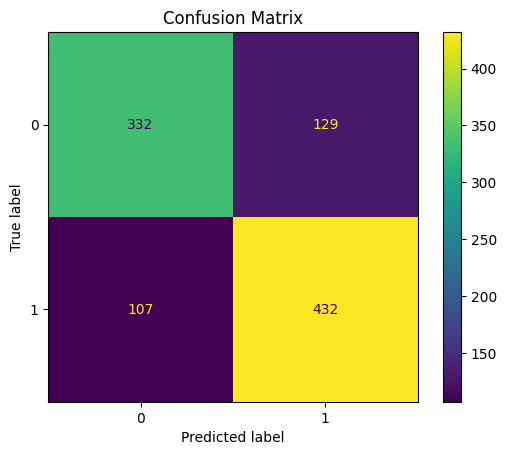

In [189]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

plt.title("Confusion Matrix")
plt.savefig("images/confusion_matrix_mobidb.png")
plt.show()

In [190]:
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Test ROC AUC:", roc_auc)
print("Test PR AUC:", pr_auc)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.764
Test Precision: 0.7700534759358288
Test Recall: 0.8014842300556586
Test F1 Score: 0.7854545454545455
Test ROC AUC: 0.8296958696710788
Test PR AUC: 0.8222223581803465

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74       461
           1       0.77      0.80      0.79       539

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



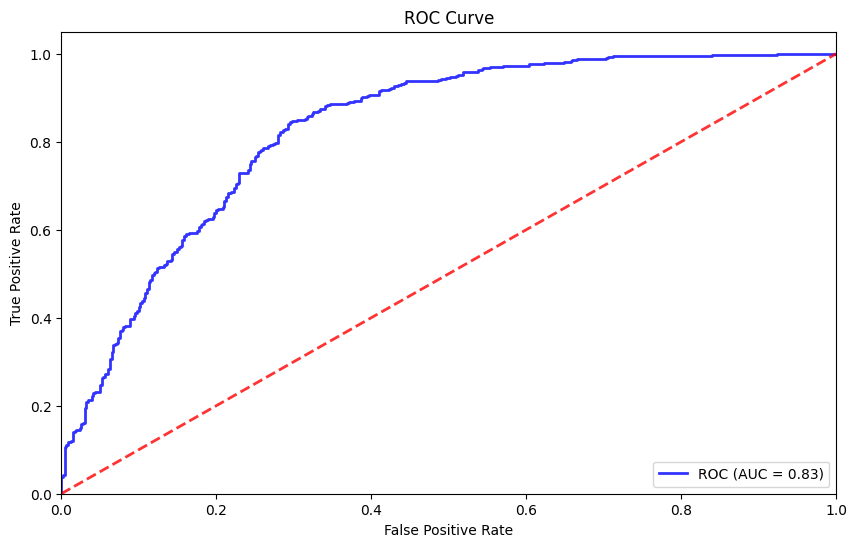

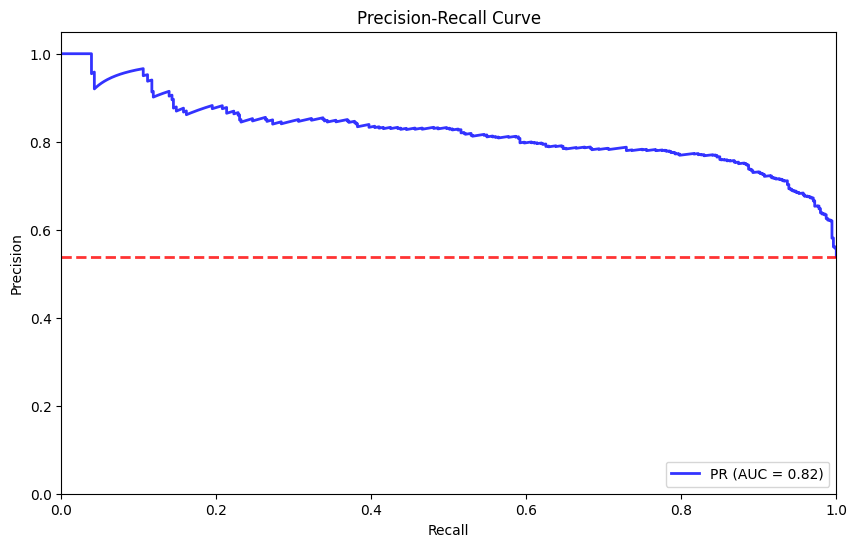

In [191]:

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='b', lw=2, alpha=0.8, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("images/test_roc_curve.png")
plt.show()

precision_baseline = sum(y_test) / len(y_test)

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='b', lw=2, alpha=0.8, label=f'PR (AUC = {pr_auc:.2f})')
plt.axhline(y=precision_baseline, color='r', linestyle='--',lw=2, alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.savefig("images/test_precision_recall_curve.png")
plt.show()


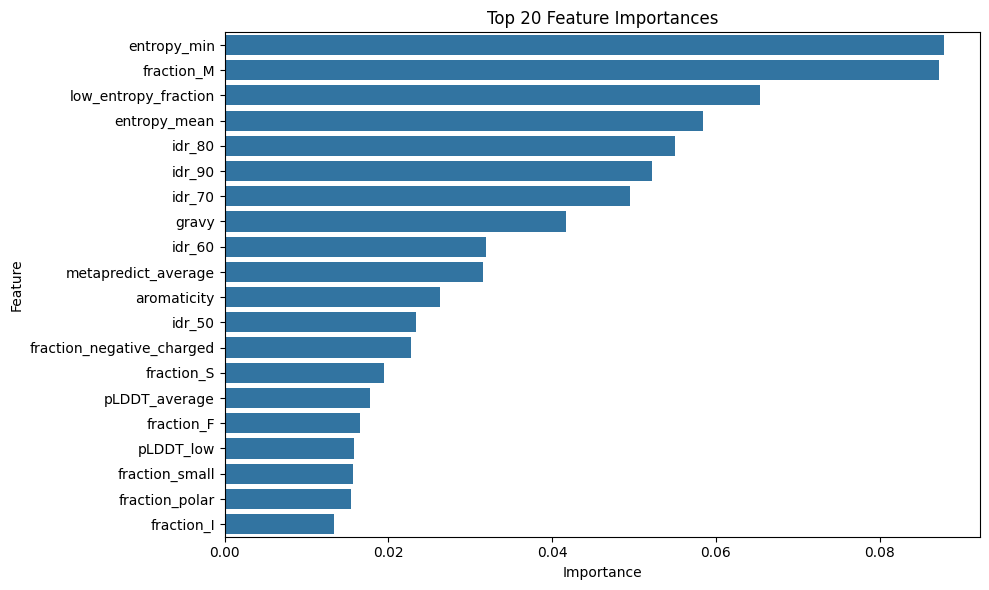

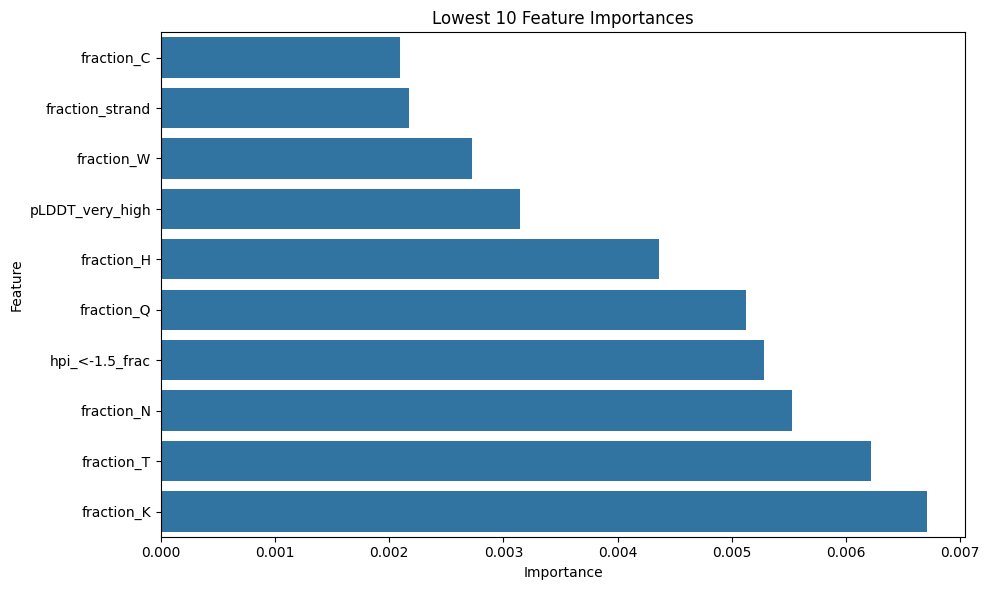

In [192]:
feature_importances = best_rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

top_20_features = importance_df.nlargest(20, 'Importance')
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.savefig("images/top_20_features_importance.png")
plt.show()

lowest_10_features = importance_df.nsmallest(10, 'Importance')
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=lowest_10_features)
plt.title('Lowest 10 Feature Importances')
plt.tight_layout()
plt.savefig("images/lowest_10_features_importance.png")
plt.show()


In [ ]:
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

param_space = {
    'n_estimators': (50, 200),             
    'learning_rate': (0.01, 0.2, 'log-uniform'),   
    'max_depth': (3, 5),
    'subsample': (0.6, 1.0),
    'max_features': ['sqrt', 'log2']
}

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=20,                  
    scoring='accuracy',         
    cv=5,                       
    n_jobs=-1,                 
    verbose=2,
    random_state=42            
)

bayes_search.fit(X_train, y_train)

print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

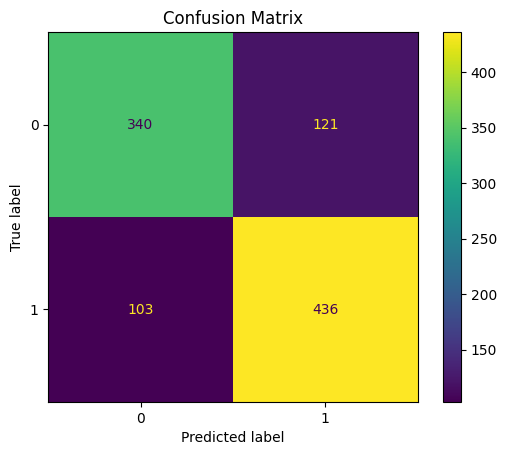

In [201]:
best_gb = bayes_search.best_estimator_
best_gb.fit(X_train, y_train)
y_pred = best_gb.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

plt.title("Confusion Matrix")
plt.savefig("images/confusion_matrix_mobidb_gb.png")
plt.show()

In [202]:
y_pred_proba = bayes_search.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Test ROC AUC:", roc_auc)
print("Test PR AUC:", pr_auc)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.776
Test Precision: 0.7827648114901257
Test Recall: 0.8089053803339518
Test F1 Score: 0.7956204379562044
Test ROC AUC: 0.831760430458912
Test PR AUC: 0.8108782690832831

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75       461
           1       0.78      0.81      0.80       539

    accuracy                           0.78      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.78      0.78      1000



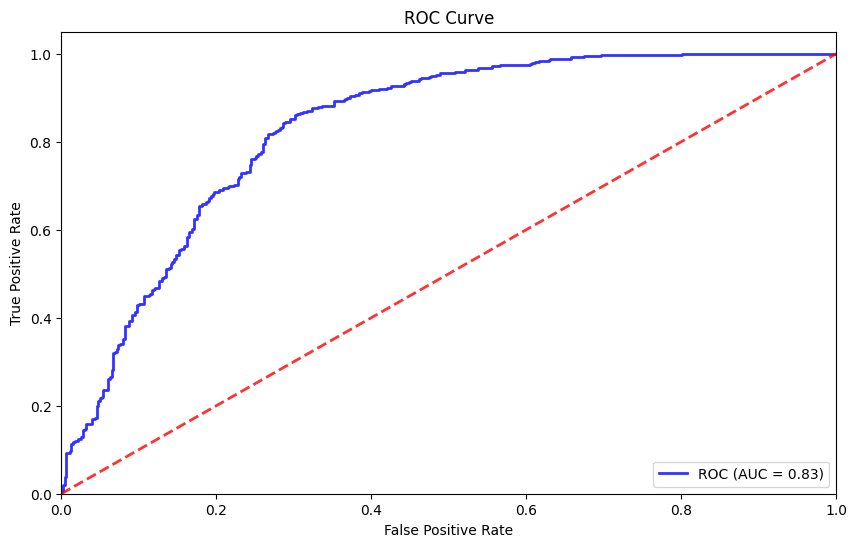

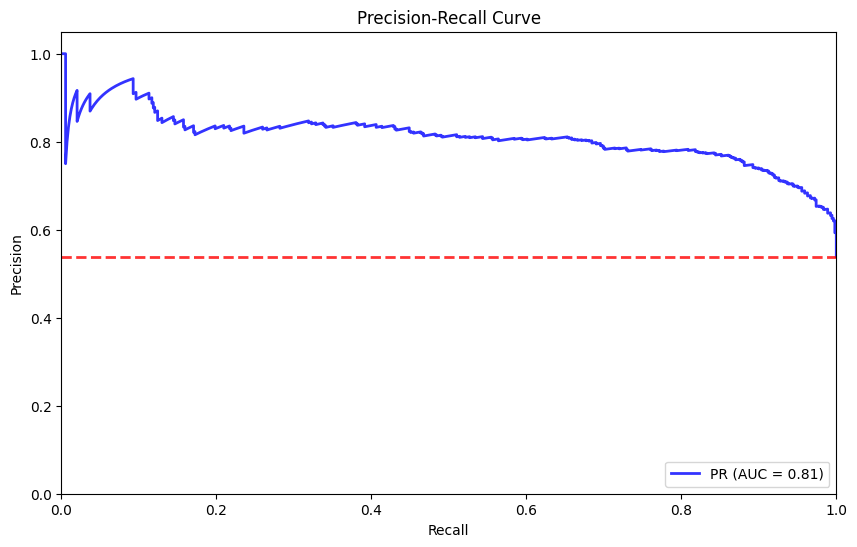

In [203]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='b', lw=2, alpha=0.8, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("images/test_roc_curve_gb.png")
plt.show()

precision_baseline = sum(y_test) / len(y_test)

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='b', lw=2, alpha=0.8, label=f'PR (AUC = {pr_auc:.2f})')
plt.axhline(y=precision_baseline, color='r', linestyle='--',lw=2, alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.savefig("images/test_precision_recall_curve_gb.png")
plt.show()


In [204]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test,y_train, y_test = train_test_split(X_scaled,y,test_size=0.2, shuffle=True)


In [205]:
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
}

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'n_estimators': 50}
Best Score: 0.7550000000000001


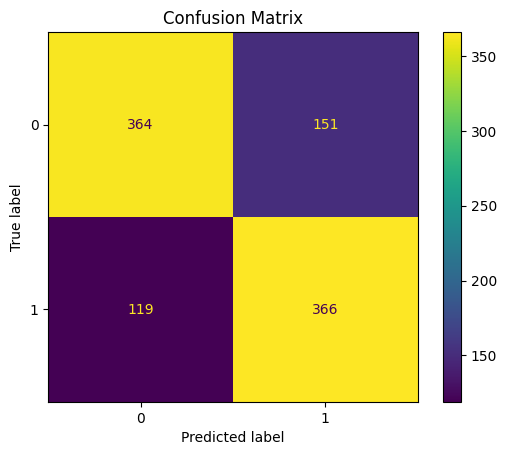

In [206]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

plt.title("Confusion Matrix")
#plt.savefig("images/confusion_matrix_mobidb.png")
plt.show()

In [208]:
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Test ROC AUC:", roc_auc)
print("Test PR AUC:", pr_auc)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.73
Test Precision: 0.7079303675048356
Test Recall: 0.7546391752577319
Test F1 Score: 0.7305389221556886
Test ROC AUC: 0.8003843459113202
Test PR AUC: 0.7570354491528883

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.71      0.73       515
           1       0.71      0.75      0.73       485

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



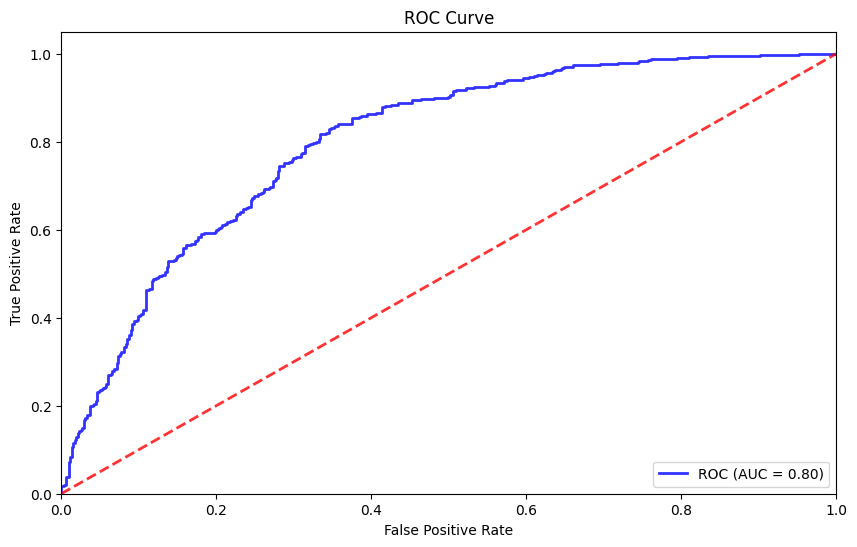

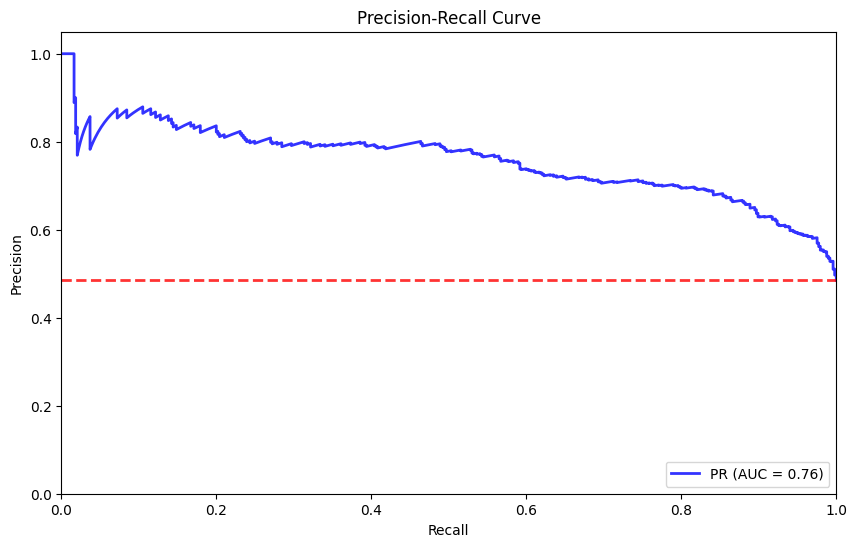

In [210]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='b', lw=2, alpha=0.8, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
#plt.savefig("images/test_roc_curve_gb.png")
plt.show()

precision_baseline = sum(y_test) / len(y_test)

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='b', lw=2, alpha=0.8, label=f'PR (AUC = {pr_auc:.2f})')
plt.axhline(y=precision_baseline, color='r', linestyle='--',lw=2, alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
#plt.savefig("images/test_precision_recall_curve_gb.png")
plt.show()

In [207]:
model = GradientBoostingClassifier()

param_space = {
    'n_estimators': (50, 200),             
    'learning_rate': (0.01, 0.2, 'log-uniform'),   
    'max_depth': (3, 5),
    'subsample': (0.6, 1.0),
    'max_features': ['sqrt', 'log2']
}

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=20,                  
    scoring='accuracy',         
    cv=5,                       
    n_jobs=-1,                 
    verbose=2,
    random_state=42            
)

bayes_search.fit(X_train, y_train)

print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

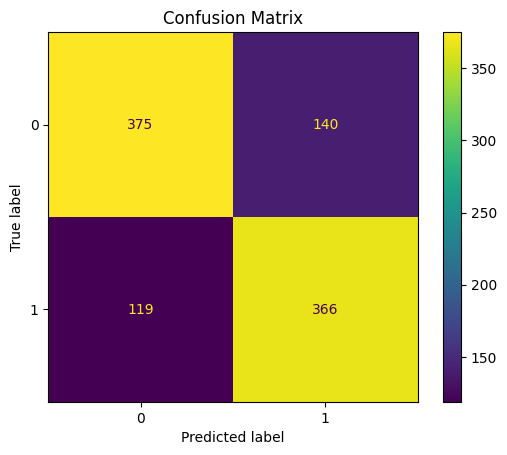

Test Accuracy: 0.741
Test Precision: 0.7233201581027668
Test Recall: 0.7546391752577319
Test F1 Score: 0.7386478304742684
Test ROC AUC: 0.8003843459113202
Test PR AUC: 0.7570354491528883

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74       515
           1       0.72      0.75      0.74       485

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



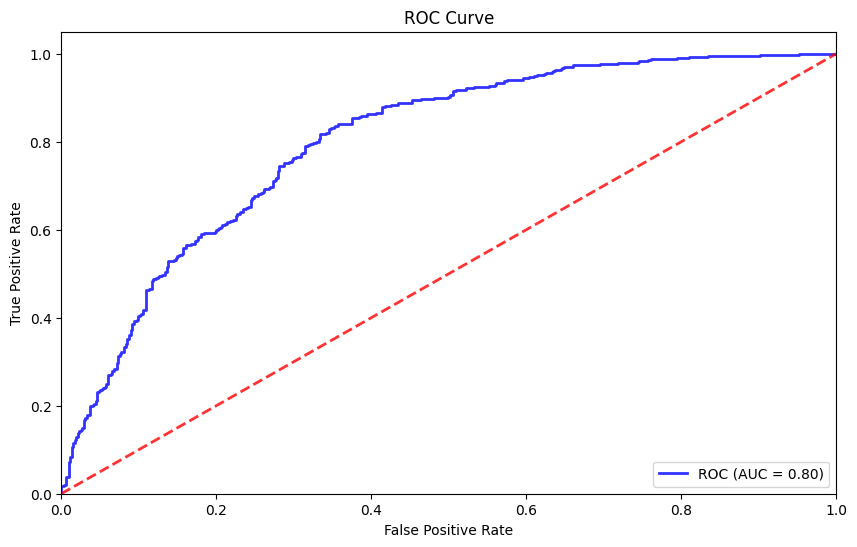

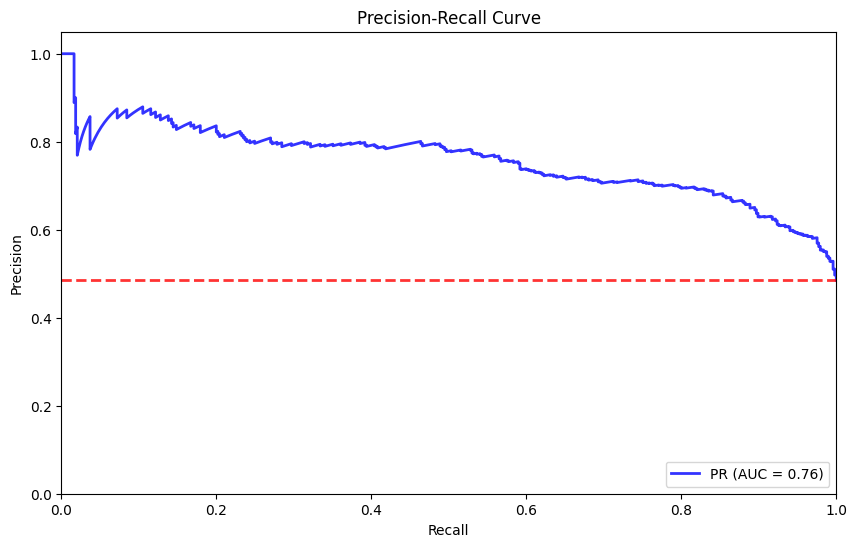

In [ ]:
best_gb = bayes_search.best_estimator_
best_gb.fit(X_train, y_train)
y_pred = best_gb.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

plt.title("Confusion Matrix")
#plt.savefig("images/confusion_matrix_mobidb_gb.png")
plt.show()

y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Test ROC AUC:", roc_auc)
print("Test PR AUC:", pr_auc)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='b', lw=2, alpha=0.8, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
#plt.savefig("images/test_roc_curve_gb.png")
plt.show()

precision_baseline = sum(y_test) / len(y_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='b', lw=2, alpha=0.8, label=f'PR (AUC = {pr_auc:.2f})')
plt.axhline(y=precision_baseline, color='r', linestyle='--',lw=2, alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
#plt.savefig("images/test_precision_recall_curve_gb.png")
plt.show()

In [223]:
seq_dibs = read_fasta("output_DIBS.fasta")
seq_fuzdb = read_fasta("output_fuzdb.fasta")
seq_mfib = read_fasta("output_MFIB.fasta")

chars = ["X","U","B", "O", "Z", "J"]
seq_dibs = [item for item in seq_dibs if all(char not in item for char in chars)]
seq_fuzdb = [item for item in seq_fuzdb if all(char not in item for char in chars)]
seq_mfib = [item for item in seq_mfib if all(char not in item for char in chars)]

In [224]:
df_dibs = pd.DataFrame(seq_dibs, columns=["sequence"])
df_fuzdb = pd.DataFrame(seq_fuzdb, columns=["sequence"])
df_mfib = pd.DataFrame(seq_mfib, columns=["sequence"])

In [ ]:
df_dibs_features = process_df(df_dibs)
df_dibs_features.to_csv("df_dibs_features.csv")

df_fuzdb_features = process_df(df_fuzdb)
df_fuzdb_features.to_csv("df_fuzdb_features.csv")

df_mfib_features = process_df(df_mfib)
df_mfib_features.to_csv("df_mfib_features.csv")

In [7]:
df = pd.read_csv("df_mobidb_features1.csv")

In [8]:
df

sequence  fraction_A  \
0                      PAERASLKKIFEGVSAEVFSQPAPVSAVATGA      0.2188   
1     ADREDDPNFFKMVEGFFDRGASIVEDKLVEDLKTRETEEQKRNRVR...      0.0385   
2                          MLRTTLHKRGLARLSRGFATTQDATPKA      0.1429   
3                                        EKTHDVIRSNLDRS      0.0000   
4     MIRSLNLLKYSLNVSQRAQLRLLSSSKWTGHRIVPAAFTGVDTNGR...      0.0476   
...                                                 ...         ...   
4995                                      MSIQTSDPNETSD      0.0000   
4996  AEDYAKERYGISSMIQSQEKPDRVLVRVRDLTIQKADEVVWVRARV...      0.0845   
4997  PGPYTPQPPDLYDTNTSLSMSRDASVFQDESNMSVLDIPSATPEKQ...      0.0342   
4998  VSSLKIFYKTVSFIMADEQLKRISKVQAKPAVEHRVAELMVYREAD...      0.0683   
4999                            IASQLLTLSAPAEAAVKTNVGPS      0.2174   

      fraction_C  fraction_D  fraction_E  fraction_F  fraction_G  fraction_H  \
0         0.0000      0.0000      0.0938      0.0625      0.0625      0.0000   
1         0.0000      0.1154      0.1346      0.0769      0.0385      0.0000   
2         0.0000      0.0357      0.0000      0.0357      0.0714      0.0357   
3         0.0000      0.1429      0.0714      0.0000      0.0000      0.0714   
4         0.0119      0.0119      0.0476      0.0238      0.0476      0.0595   
...          ...         ...         ...         ...         ...         ...   
4995      0.0000      0.1538      0.0769      0.0000      0.0000      0.0000   
4996      0.0141      0.0634      0.0563      0.0211      0.0352      0.0211   
4997      0.0000      0.1282      0.1667      0.0171      0.0897      0.0128   
4998      0.0195      0.0439      0.0634      0.0244      0.0341      0.0293   
4999      0.0000      0.0000      0.0435      0.0000      0.0435      0.0000   

      fraction_I  fraction_K  ...  idr_90  pLDDT_average  pLDDT_very_low  \
0         0.0312      0.0625  ...  0.0000         0.6583          0.0312   
1         0.0769      0.0769  ...  0.0000         0.7997          0.0192   
2         0.0000      0.0714  ...  0.0000         0.6461          0.0714   
3         0.0714      0.0714  ...  0.0000         0.6747          0.0714   
4         0.0238      0.0238  ...  0.1786         0.5246          0.4762   
...          ...         ...  ...     ...            ...             ...   
4995      0.0769      0.0000  ...  0.3846         0.6420          0.0769   
4996      0.0563      0.0775  ...  0.0000         0.8526          0.0000   
4997      0.0256      0.0128  ...  0.1667         0.5335          0.2094   
4998      0.0537      0.0976  ...  0.0000         0.8692          0.0000   
4999      0.0435      0.0435  ...  0.0000         0.6308          0.0435   

      pLDDT_low  pLDDT_high  pLDDT_very_high  fraction_coils  fraction_helix  \
0        0.6875      0.2812           0.0000          0.5625          0.4375   
1        0.1154      0.8269           0.0385          0.2500          0.7500   
2        0.8929      0.0357           0.0000          0.9643          0.0357   
3        0.3571      0.5714           0.0000          0.7857          0.2143   
4        0.5238      0.0000           0.0000          0.9167          0.0833   
...         ...         ...              ...             ...             ...   
4995     0.6154      0.3077           0.0000          1.0000          0.0000   
4996     0.0423      0.5986           0.3592          0.4930          0.1690   
4997     0.7906      0.0000           0.0000          1.0000          0.0000   
4998     0.0146      0.7122           0.2732          0.1561          0.8439   
4999     0.7391      0.2174           0.0000          1.0000          0.0000   

      fraction_strand  labels  
0               0.000      DD  
1               0.000      DO  
2               0.000      DD  
3               0.000      DO  
4               0.000      DD  
...               ...     ...  
4995            0.000      DD  
4996            0.338      DO  
4997            0.000      DD  
4998            0.000      DO  
4999   

In [10]:
df['labels'] = df['labels'].apply(lambda x: 0 if x == "DD" else 1)
df.columns
X = df.loc[:,"fraction_A":"fraction_strand"]
y = df.loc[:,"labels"]
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

In [15]:
from sklearn.svm import SVC
from skopt import BayesSearchCV

svm = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

bayes_search = BayesSearchCV(
    estimator=svm,
    search_spaces=param_grid,
    n_iter=20,                  
    scoring='accuracy',         
    cv=5,                       
    n_jobs=-1,                 
    verbose=2,
    random_state=42            
)

bayes_search.fit(X_train, y_train)

print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

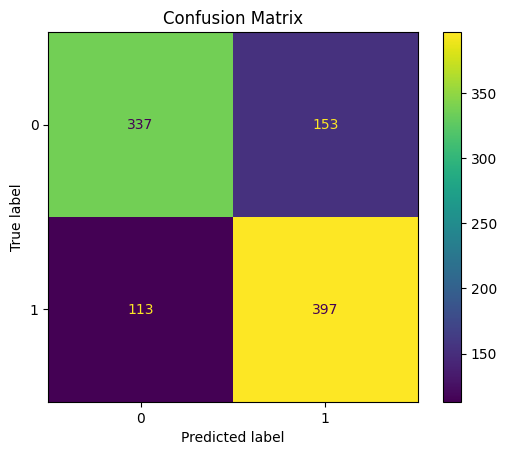

In [22]:
best_svm = bayes_search.best_estimator_
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

plt.title("Confusion Matrix")
#plt.savefig("images/confusion_matrix_mobidb.png")
plt.show()

In [43]:
best_svm = SVC(probability=True, C= 10, gamma= 0.1, kernel='poly')
best_svm.fit(X_train, y_train)

SVC(C=10, gamma=0.1, kernel='poly', probability=True)

In [44]:
y_pred_proba = best_svm.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Test ROC AUC:", roc_auc)
print("Test PR AUC:", pr_auc)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.734
Test Precision: 0.7218181818181818
Test Recall: 0.7784313725490196
Test F1 Score: 0.7490566037735849
Test ROC AUC: 0.7954861944777911
Test PR AUC: 0.7573402041648647

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.69      0.72       490
           1       0.72      0.78      0.75       510

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



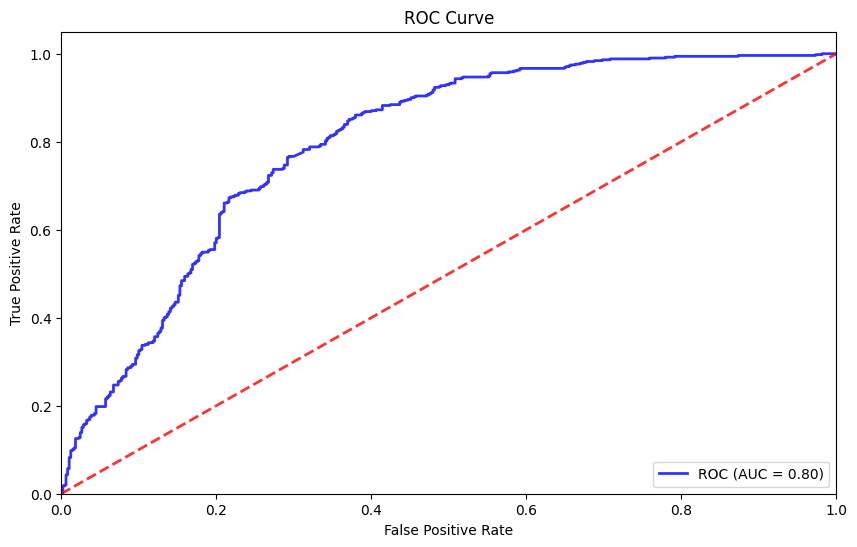

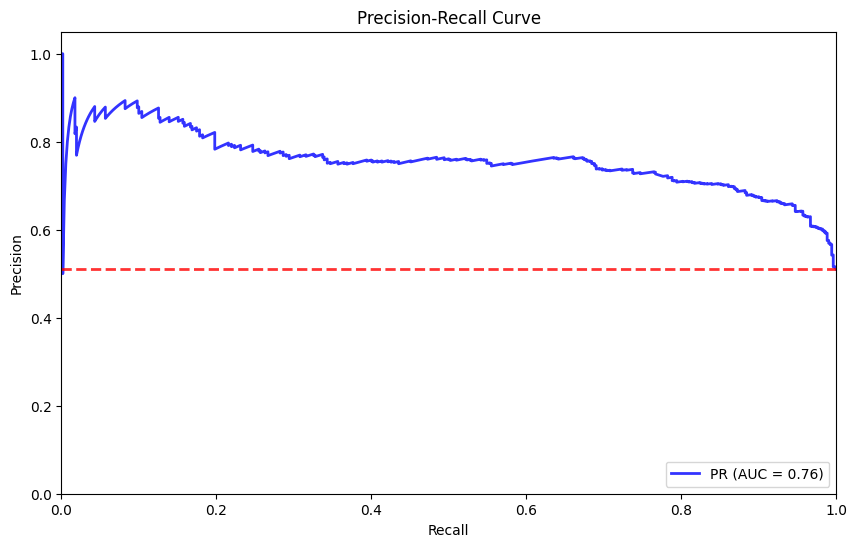

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='b', lw=2, alpha=0.8, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
#plt.savefig("images/test_roc_curve_gb.png")
plt.show()

precision_baseline = sum(y_test) / len(y_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='b', lw=2, alpha=0.8, label=f'PR (AUC = {pr_auc:.2f})')
plt.axhline(y=precision_baseline, color='r', linestyle='--',lw=2, alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
#plt.savefig("images/test_precision_recall_curve_gb.png")
plt.show()

In [5]:
combined_df = pd.read_csv("combined_df.csv")

In [9]:
combined_df
test_datasets = combined_df.copy()

In [10]:
test_datasets['labels'] = test_datasets['labels'].apply(lambda x: 0 if x == "DD" else 1)
X = test_datasets.loc[:,"fraction_A":"fraction_strand"]
y = test_datasets.loc[:,"labels"]

In [11]:
X

fraction_A  fraction_C  fraction_D  fraction_E  fraction_F  fraction_G  \
0        0.0615      0.0308      0.0359      0.0667      0.0256      0.0513   
1        0.0000      0.0000      0.0333      0.1167      0.0000      0.0167   
2        0.0900      0.0150      0.0550      0.1750      0.0200      0.0700   
3        0.0667      0.0000      0.0667      0.0000      0.0667      0.0667   
4        0.0000      0.0556      0.0000      0.0556      0.1111      0.1111   
..          ...         ...         ...         ...         ...         ...   
981      0.0000      0.0000      0.0000      0.0000      0.0000      0.0000   
982      0.0976      0.0244      0.0000      0.0244      0.0000      0.0488   
983      0.0651      0.0064      0.0651      0.0727      0.0408      0.0612   
984      0.0625      0.0625      0.0625      0.0625      0.0000      0.0625   
985      0.0541      0.0360      0.0631      0.0631      0.0180      0.0631   

     fraction_H  fraction_I  fraction_K  fraction_L  ...  idr_80  idr_90  \
0        0.0256      0.0359      0.0462      0.1359  ...  0.0128  0.0051   
1        0.0500      0.0500      0.0333      0.1667  ...  0.0000  0.0000   
2        0.0100      0.0350      0.1250      0.0600  ...  0.3800  0.3000   
3        0.0000      0.0667      0.1333      0.0667  ...  0.1333  0.0000   
4        0.0000      0.0556      0.1111      0.0000  ...  0.2222  0.0556   
..          ...         ...         ...         ...  ...     ...     ...   
981      0.0000      0.0588      0.0588      0.1176  ...  0.2941  0.0000   
982      0.0000      0.0244      0.0000      0.0488  ...  0.8049  0.1220   
983      0.0217      0.0651      0.0599      0.0727  ...  0.1416  0.1059   
984      0.0000      0.0000      0.0000      0.1875  ...  0.1875  0.0000   
985      0.0180      0.0631      0.0721      0.0360  ...  0.0270  0.0000   

     pLDDT_average  pLDDT_very_low  pLDDT_low  pLDDT_high  pLDDT_very_high  \
0           0.8274          0.0231     0.1256      0.5897           0.2615   
1           0.8318          0.0000     0.1167      0.6500           0.2333   
2           0.7249          0.3100     0.1300      0.1500           0.4100   
3           0.7031          0.0667     0.3333      0.6000           0.0000   
4           0.6909          0.0000     0.5000      0.5000           0.0000   
..             ...             ...        ...         ...              ...   
981         0.6464          0.0588     0.7647      0.1765           0.0000   
982         0.6154          0.0244     0.9512      0.0244           0.0000   
983         0.7671          0.1990     0.0893      0.3520           0.3597   
984         0.6448          0.0000     0.6875      0.3125           0.0000   
985         0.8847          0.0000     0.0450      0.3604           0.5946   

     fraction_coils  fraction_helix  fraction_strand  
0            0.5256          0.3359           0.1385  
1            0.3667          0.6333           0.0000  
2            0.7000          0.0000           0.3000  
3            1.0000          0.0000           0.0000  
4            0.8889          0.1111           0.0000  
..              ...             ...              ...  
981          0.8235          0.0000           0.1765  
982          1.0000          0.0000           0.0000  
983          0.5880          0.0842           0.3278  
984          1.0000          0.0000           0.0000  
985          0.3514          0.3243           0.3243  

[986 rows x 48 columns]

In [6]:
df = pd.read_csv("df_mobidb_features1.csv")
df['labels'] = df['labels'].apply(lambda x: 0 if x == "DD" else 1)
df.columns
X = df.loc[:,"fraction_A":"fraction_strand"]
y = df.loc[:,"labels"]
#X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)


In [7]:
X

fraction_A  fraction_C  fraction_D  fraction_E  fraction_F  fraction_G  \
0         0.2188      0.0000      0.0000      0.0938      0.0625      0.0625   
1         0.0385      0.0000      0.1154      0.1346      0.0769      0.0385   
2         0.1429      0.0000      0.0357      0.0000      0.0357      0.0714   
3         0.0000      0.0000      0.1429      0.0714      0.0000      0.0000   
4         0.0476      0.0119      0.0119      0.0476      0.0238      0.0476   
...          ...         ...         ...         ...         ...         ...   
4995      0.0000      0.0000      0.1538      0.0769      0.0000      0.0000   
4996      0.0845      0.0141      0.0634      0.0563      0.0211      0.0352   
4997      0.0342      0.0000      0.1282      0.1667      0.0171      0.0897   
4998      0.0683      0.0195      0.0439      0.0634      0.0244      0.0341   
4999      0.2174      0.0000      0.0000      0.0435      0.0000      0.0435   

      fraction_H  fraction_I  fraction_K  fraction_L  ...  idr_80  idr_90  \
0         0.0000      0.0312      0.0625      0.0312  ...  0.2188  0.0000   
1         0.0000      0.0769      0.0769      0.0577  ...  0.0962  0.0000   
2         0.0357      0.0000      0.0714      0.1429  ...  0.7500  0.0000   
3         0.0714      0.0714      0.0714      0.0714  ...  0.3571  0.0000   
4         0.0595      0.0238      0.0238      0.1071  ...  0.7024  0.1786   
...          ...         ...         ...         ...  ...     ...     ...   
4995      0.0000      0.0769      0.0000      0.0000  ...  0.9231  0.3846   
4996      0.0211      0.0563      0.0775      0.0704  ...  0.0000  0.0000   
4997      0.0128      0.0256      0.0128      0.0556  ...  0.9701  0.1667   
4998      0.0293      0.0537      0.0976      0.1707  ...  0.0000  0.0000   
4999      0.0000      0.0435      0.0435      0.1304  ...  0.6522  0.0000   

      pLDDT_average  pLDDT_very_low  pLDDT_low  pLDDT_high  pLDDT_very_high  \
0            0.6583          0.0312     0.6875      0.2812           0.0000   
1            0.7997          0.0192     0.1154      0.8269           0.0385   
2            0.6461          0.0714     0.8929      0.0357           0.0000   
3            0.6747          0.0714     0.3571      0.5714           0.0000   
4            0.5246          0.4762     0.5238      0.0000           0.0000   
...             ...             ...        ...         ...              ...   
4995         0.6420          0.0769     0.6154      0.3077           0.0000   
4996         0.8526          0.0000     0.0423      0.5986           0.3592   
4997         0.5335          0.2094     0.7906      0.0000           0.0000   
4998         0.8692          0.0000     0.0146      0.7122           0.2732   
4999         0.6308          0.0435     0.7391      0.2174           0.0000   

      fraction_coils  fraction_helix  fraction_strand  
0             0.5625          0.4375            0.000  
1             0.2500          0.7500            0.000  
2             0.9643          0.0357            0.000  
3             0.7857          0.2143            0.000  
4             0.9167          0.0833            0.000  
...              ...             ...              ...  
4995          1.0000          0.0000            0.000  
4996          0.4930          0.1690            0.338  
4997          1.0000          0.0000            0.000  
4998          0.1561          0.8439            0.000  
4999          1.0000          0.0000            0.000  

[5000 rows x 51 columns]

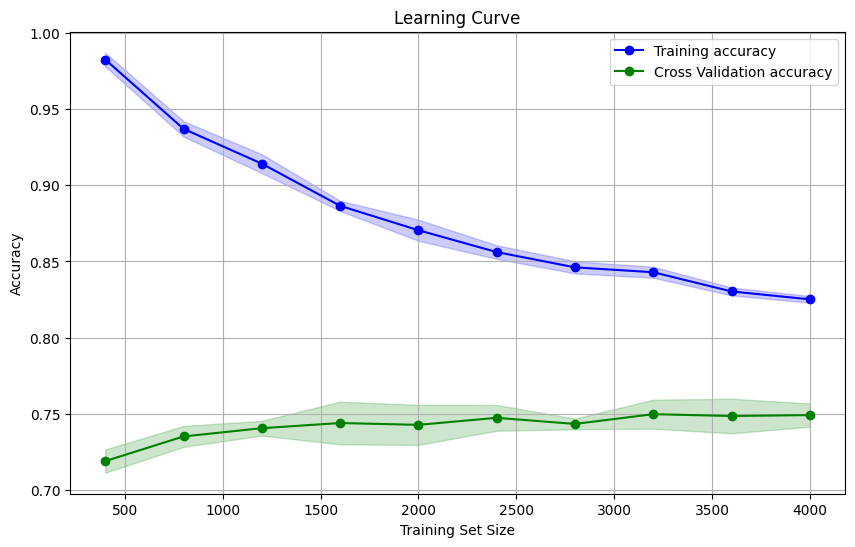

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score


model = RandomForestClassifier(max_depth = 7, min_samples_leaf = 1, n_estimators = 50)

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, train_sizes=train_sizes, cv=5, scoring="accuracy", n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross Validation accuracy")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.savefig("Learning Curve_RF")
plt.show()


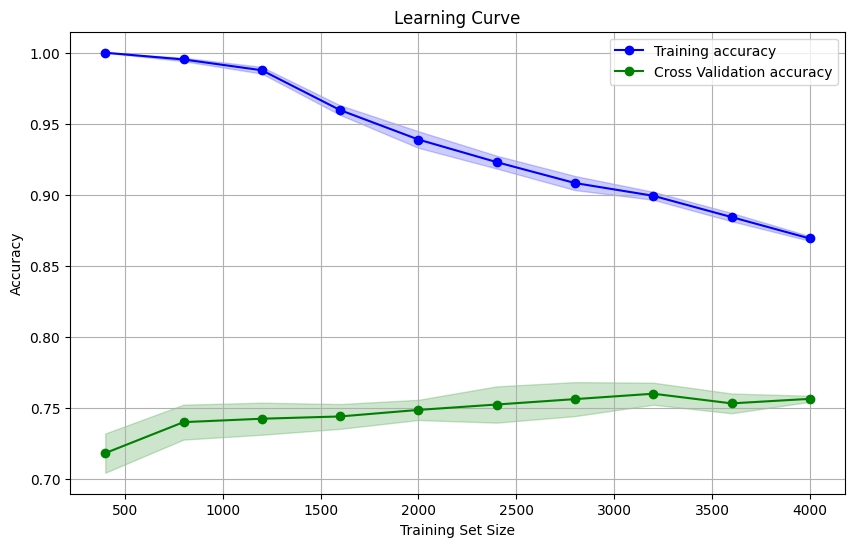

In [10]:

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate =0.035422820194388076 , max_depth = 5, max_features ='sqrt', n_estimators = 198, subsample =1.0)
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, train_sizes=train_sizes, cv=5, scoring="accuracy", n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross Validation accuracy")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.savefig("Learning Curve_GB")
plt.show()